In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.5.0

numpy 1.15.2
sklearn 0.20.0
scipy 1.1.0
matplotlib 3.0.0
tensorflow 1.11.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.158406	최선의 손실: 0.158406	정확도: 96.79%
1	검증 세트 손실: 0.191588	최선의 손실: 0.158406	정확도: 96.79%
2	검증 세트 손실: 1.006910	최선의 손실: 0.158406	정확도: 89.48%
3	검증 세트 손실: 0.128345	최선의 손실: 0.128345	정확도: 97.46%
4	검증 세트 손실: 0.194406	최선의 손실: 0.128345	정확도: 96.33%
5	검증 세트 손실: 0.131275	최선의 손실: 0.128345	정확도: 97.69%
6	검증 세트 손실: 0.489395	최선의 손실: 0.128345	정확도: 96.29%
7	검증 세트 손실: 0.179880	최선의 손실: 0.128345	정확도: 96.05%
8	검증 세트 손실: 0.180179	최선의 손실: 0.128345	정확도: 96.01%
9	검증 세트 손실: 0.165965	최선의 손실: 0.128345	정확도: 96.64%
10	검증 세트 손실: 0.167256	최선의 손실: 0.128345	정확도: 97.50%
11	검증 세트 손실: 0.368652	최선의 손실: 0.128345	정확도: 95.07%
12	검증 세트 손실: 0.152089	최선의 손실: 0.128345	정확도: 97.26%
13	검증 세트 손실: 0.198876	최선의 손실: 0.128345	정확도: 97.26%
14	검증 세트 손실: 0.623777	최선의 손실: 0.128345	정확도: 77.01%
15	검증 세트 손실: 1.134086	최선의 손실: 0.128345	정확도: 48.28%
16	검증 세트 손실: 1.151802	최선의 손실: 0.128345	정확도: 44.33%
17	검증 세트 손실: 1.163442	최선의 손실: 0.128345	정확도: 41.67%
18	검증 세트 손실: 0.976569	최선의 손실: 0.128345	정확도: 53.56%
19	검증 세트 손실: 0.874914	최선의 손실: 0.128345	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.135210	최선의 손실: 0.135210	정확도: 97.19%
1	검증 세트 손실: 0.079218	최선의 손실: 0.079218	정확도: 98.01%
2	검증 세트 손실: 0.143483	최선의 손실: 0.079218	정확도: 96.79%
3	검증 세트 손실: 0.119480	최선의 손실: 0.079218	정확도: 97.30%
4	검증 세트 손실: 0.091971	최선의 손실: 0.079218	정확도: 97.77%
5	검증 세트 손실: 0.113991	최선의 손실: 0.079218	정확도: 97.69%
6	검증 세트 손실: 0.787151	최선의 손실: 0.079218	정확도: 74.71%
7	검증 세트 손실: 0.269481	최선의 손실: 0.079218	정확도: 96.17%
8	검증 세트 손실: 0.268535	최선의 손실: 0.079218	정확도: 96.68%
9	검증 세트 손실: 0.279010	최선의 손실: 0.079218	정확도: 96.87%
10	검증 세트 손실: 0.380495	최선의 손실: 0.079218	정확도: 87.92%
11	검증 세트 손실: 0.262297	최선의 손실: 0.079218	정확도: 95.66%
12	검증 세트 손실: 0.204676	최선의 손실: 0.079218	정확도: 97.81%
13	검증 세트 손실: 0.213231	최선의 손실: 0.079218	정확도: 97.26%
14	검증 세트 손실: 0.688790	최선의 손실: 0.079218	정확도: 69.78%
15	검증 세트 손실: 1.670060	최선의 손실: 0.079218	정확도: 20.91%
16	검증 세트 손실: 0.878664	최선의 손실: 0.079218	정확도: 59.30%
17	검증 세트 손실: 0.943792	최선의 손실: 0.079218	정확도: 60.13%
18	검증 세트 손실: 1.305260	최선의 손실: 0.079218	정확도: 36.75%
19	검증 세트 손실: 1.260602	최선의 손실: 0.079218	정확

DNNClassifier(activation=<function elu at 0x7f4edc3ab7b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9820976843743919

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

*사이킷런 0.22 버전에서 cross_val_score 함수와 GridSearchCV, RandomizedSearchCV 클래스의 cv 매개변수 기본값이 3에서 5로 바뀔 예정입니다. 0.20 버전에서 cv 매개변수를 지정하지 않는 경우 이에 관한 경고 메세지가 출력됩니다. 경고 메세지를 피하기 위해 cv 매개변수 값을 명시적으로 3으로 지정합니다.*

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.286659	최선의 손실: 0.286659	정확도: 93.24%
1	검증 세트 손실: 0.123074	최선의 손실: 0.123074	정확도: 97.30%
2	검증 세트 손실: 0.120591	최선의 손실: 0.120591	정확도: 97.07%
3	검증 세트 손실: 0.127779	최선의 손실: 0.120591	정확도: 96.91%
4	검증 세트 손실: 0.106498	최선의 손실: 0.106498	정확도: 97.19%
5	검증 세트 손실: 0.132649	최선의 손실: 0.106498	정확도: 96.76%
6	검증 세트 손실: 0.216658	최선의 손실: 0.106498	정확도: 94.18%
7	검증 세트 손실: 0.118795	최선의 손실: 0.106498	정확도: 96.72%
8	검증 세트 손실: 0.104600	최선의 손실: 0.104600	정확도: 97.42%
9	검증 세트 손실: 0.127365	최선의 손실: 0.104600	정확도: 96.48%
10	검증 세트 손실: 0.162556	최선의 손실: 0.104600	정확도: 96.72%
11	검증 세트 손실: 0.156763	최선의 손실: 0.104600	정확도: 96.36%
12	검증 세트 손실: 0.189163	최선의 손실: 0.104600	정확도: 95.97%
13	검증 세트 손실: 1.732670	최선의 손실: 0.104600	정확도: 18.73%
14	검증 세트 손실: 1.621623	최선의 손실: 0.104600	정확도: 20.91%
15	검증 세트 손실: 1.615972	최선의 손실: 0.104600	정확도: 22.01%
16	검증 세트 손실: 1.610769	최선의 손실: 0.104600	정확도: 19.08%
17	검증 세트 손실: 1.616291	최선의 손실: 0.104600	정확도: 19.27%
18	검증 세트 손실: 1.681803	최선의 손실: 0.104600	정확도: 22.01%
19	검증 세트 손실: 1.628470	최선의 손실: 0.104600	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


0	검증 세트 손실: 0.185568	최선의 손실: 0.185568	정확도: 95.74%
1	검증 세트 손실: 0.139123	최선의 손실: 0.139123	정확도: 97.11%
2	검증 세트 손실: 0.139343	최선의 손실: 0.139123	정확도: 96.64%
3	검증 세트 손실: 0.187580	최선의 손실: 0.139123	정확도: 96.25%
4	검증 세트 손실: 1.337599	최선의 손실: 0.139123	정확도: 35.89%
5	검증 세트 손실: 1.226708	최선의 손실: 0.139123	정확도: 43.90%
6	검증 세트 손실: 0.794379	최선의 손실: 0.139123	정확도: 63.02%
7	검증 세트 손실: 0.927424	최선의 손실: 0.139123	정확도: 62.63%
8	검증 세트 손실: 0.427080	최선의 손실: 0.139123	정확도: 82.64%
9	검증 세트 손실: 0.378933	최선의 손실: 0.139123	정확도: 87.84%
10	검증 세트 손실: 0.438344	최선의 손실: 0.139123	정확도: 87.84%
11	검증 세트 손실: 0.302510	최선의 손실: 0.139123	정확도: 92.34%
12	검증 세트 손실: 0.294068	최선의 손실: 0.139123	정확도: 92.61%
13	검증 세트 손실: 0.305502	최선의 손실: 0.139123	정확도: 93.67%
14	검증 세트 손실: 0.296342	최선의 손실: 0.139123	정확도: 93.16%
15	검증 세트 손실: 0.886100	최선의 손실: 0.139123	정확도: 58.60%
16	검증 세트 손실: 0.540573	최선의 손실: 0.139123	정확도: 83.93%
17	검증 세트 손실: 0.322576	최선의 손실: 0.139123	정확도: 93.12%
18	검증 세트 손실: 0.332564	최선의 손실: 0.139123	정확도: 91.91%
19	검증 세트 손실: 0.307835	최선의 손실: 0.139123	정확

0	검증 세트 손실: 408.840820	최선의 손실: 408.840820	정확도: 19.23%
1	검증 세트 손실: 14.247935	최선의 손실: 14.247935	정확도: 40.97%
2	검증 세트 손실: 2.741080	최선의 손실: 2.741080	정확도: 41.09%
3	검증 세트 손실: 0.976301	최선의 손실: 0.976301	정확도: 63.84%
4	검증 세트 손실: 35701.242188	최선의 손실: 0.976301	정확도: 27.68%
5	검증 세트 손실: 1083.607788	최선의 손실: 0.976301	정확도: 51.64%
6	검증 세트 손실: 78.945396	최선의 손실: 0.976301	정확도: 82.56%
7	검증 세트 손실: 16891.486328	최선의 손실: 0.976301	정확도: 87.69%
8	검증 세트 손실: 25.562294	최선의 손실: 0.976301	정확도: 88.55%
9	검증 세트 손실: 19.891205	최선의 손실: 0.976301	정확도: 91.79%
10	검증 세트 손실: 40.275269	최선의 손실: 0.976301	정확도: 81.16%
11	검증 세트 손실: 10944.943359	최선의 손실: 0.976301	정확도: 51.60%
12	검증 세트 손실: 4098.828613	최선의 손실: 0.976301	정확도: 60.44%
13	검증 세트 손실: 1907.945679	최선의 손실: 0.976301	정확도: 75.49%
14	검증 세트 손실: 3254.377686	최선의 손실: 0.976301	정확도: 85.42%
15	검증 세트 손실: 1123.550781	최선의 손실: 0.976301	정확도: 92.03%
16	검증 세트 손실: 989.705750	최선의 손실: 0.976301	정확도: 86.47%
17	검증 세트 손실: 1134.789429	최선의 손실: 0.976301	정확도: 91.91%
18	검증 세트 손실: 878.020508	최선의 손실: 0.976301	정확도: 93.6

3	검증 세트 손실: 1064.369629	최선의 손실: 0.212957	정확도: 90.58%
4	검증 세트 손실: 965.655579	최선의 손실: 0.212957	정확도: 90.62%
5	검증 세트 손실: 511.120697	최선의 손실: 0.212957	정확도: 94.18%
6	검증 세트 손실: 3066.225098	최선의 손실: 0.212957	정확도: 73.61%
7	검증 세트 손실: 339.877441	최선의 손실: 0.212957	정확도: 93.20%
8	검증 세트 손실: 362.762482	최선의 손실: 0.212957	정확도: 96.25%
9	검증 세트 손실: 468.337921	최선의 손실: 0.212957	정확도: 91.67%
10	검증 세트 손실: 721.540283	최선의 손실: 0.212957	정확도: 89.64%
11	검증 세트 손실: 2444.670654	최선의 손실: 0.212957	정확도: 94.21%
12	검증 세트 손실: 152779.640625	최선의 손실: 0.212957	정확도: 86.79%
13	검증 세트 손실: 10490.375000	최선의 손실: 0.212957	정확도: 90.77%
14	검증 세트 손실: 9367.679688	최선의 손실: 0.212957	정확도: 92.42%
15	검증 세트 손실: 9034.580078	최선의 손실: 0.212957	정확도: 91.40%
16	검증 세트 손실: 4295.987305	최선의 손실: 0.212957	정확도: 93.24%
17	검증 세트 손실: 5100.275879	최선의 손실: 0.212957	정확도: 92.65%
18	검증 세트 손실: 3462.729492	최선의 손실: 0.212957	정확도: 94.37%
19	검증 세트 손실: 394985.187500	최선의 손실: 0.212957	정확도: 90.03%
20	검증 세트 손실: 14710.354492	최선의 손실: 0.212957	정확도: 94.64%
21	검증 세트 손실: 14590.680664	최선의 손실: 0

24	검증 세트 손실: 0.047876	최선의 손실: 0.037902	정확도: 98.63%
25	검증 세트 손실: 0.090786	최선의 손실: 0.037902	정확도: 98.75%
26	검증 세트 손실: 0.066561	최선의 손실: 0.037902	정확도: 98.87%
27	검증 세트 손실: 0.076682	최선의 손실: 0.037902	정확도: 98.87%
28	검증 세트 손실: 0.069120	최선의 손실: 0.037902	정확도: 98.87%
29	검증 세트 손실: 0.065812	최선의 손실: 0.037902	정확도: 99.06%
30	검증 세트 손실: 0.076101	최선의 손실: 0.037902	정확도: 99.18%
31	검증 세트 손실: 0.071681	최선의 손실: 0.037902	정확도: 98.94%
32	검증 세트 손실: 0.053340	최선의 손실: 0.037902	정확도: 99.02%
33	검증 세트 손실: 0.093576	최선의 손실: 0.037902	정확도: 98.83%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7e8840>, total=   2.9s
[CV] n_neurons=90, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7e8840> 
0	검증 세트 손실: 0.086824	최선의 손실: 0.086824	정확도: 97.42%
1	검증 세트 손실: 0.062775	최선의 손실: 0.062775	정확도: 98.01%
2	검증 세트 손실: 0.059458	최선의 손실: 0.059458	정확도: 98.05%
3	검증 세트 손실: 0.077340	최선의 손실: 0.059458	

0	검증 세트 손실: 0.108754	최선의 손실: 0.108754	정확도: 96.68%
1	검증 세트 손실: 0.076621	최선의 손실: 0.076621	정확도: 97.54%
2	검증 세트 손실: 0.066869	최선의 손실: 0.066869	정확도: 98.08%
3	검증 세트 손실: 0.059805	최선의 손실: 0.059805	정확도: 98.20%
4	검증 세트 손실: 0.050830	최선의 손실: 0.050830	정확도: 98.36%
5	검증 세트 손실: 0.050915	최선의 손실: 0.050830	정확도: 98.32%
6	검증 세트 손실: 0.054091	최선의 손실: 0.050830	정확도: 98.44%
7	검증 세트 손실: 0.041233	최선의 손실: 0.041233	정확도: 98.71%
8	검증 세트 손실: 0.049015	최선의 손실: 0.041233	정확도: 98.51%
9	검증 세트 손실: 0.056155	최선의 손실: 0.041233	정확도: 98.79%
10	검증 세트 손실: 0.073766	최선의 손실: 0.041233	정확도: 98.36%
11	검증 세트 손실: 0.069158	최선의 손실: 0.041233	정확도: 98.48%
12	검증 세트 손실: 0.052186	최선의 손실: 0.041233	정확도: 98.59%
13	검증 세트 손실: 0.045583	최선의 손실: 0.041233	정확도: 98.87%
14	검증 세트 손실: 0.056682	최선의 손실: 0.041233	정확도: 98.71%
15	검증 세트 손실: 0.052591	최선의 손실: 0.041233	정확도: 99.02%
16	검증 세트 손실: 0.063430	최선의 손실: 0.041233	정확도: 98.87%
17	검증 세트 손실: 0.068764	최선의 손실: 0.041233	정확도: 98.71%
18	검증 세트 손실: 0.078828	최선의 손실: 0.041233	정확도: 98.55%
19	검증 세트 손실: 0.070028	최선의 손실: 0.041233	정확

19	검증 세트 손실: 1.619094	최선의 손실: 1.612442	정확도: 22.01%
20	검증 세트 손실: 1.609109	최선의 손실: 1.609109	정확도: 22.01%
21	검증 세트 손실: 1.689012	최선의 손실: 1.609109	정확도: 22.01%
22	검증 세트 손실: 1.618890	최선의 손실: 1.609109	정확도: 18.73%
23	검증 세트 손실: 1.638926	최선의 손실: 1.609109	정확도: 22.01%
24	검증 세트 손실: 1.660615	최선의 손실: 1.609109	정확도: 20.91%
25	검증 세트 손실: 1.619330	최선의 손실: 1.609109	정확도: 19.27%
26	검증 세트 손실: 1.611331	최선의 손실: 1.609109	정확도: 22.01%
27	검증 세트 손실: 1.614303	최선의 손실: 1.609109	정확도: 20.91%
28	검증 세트 손실: 1.628118	최선의 손실: 1.609109	정확도: 19.08%
29	검증 세트 손실: 1.610351	최선의 손실: 1.609109	정확도: 20.91%
30	검증 세트 손실: 1.626937	최선의 손실: 1.609109	정확도: 20.91%
31	검증 세트 손실: 1.633268	최선의 손실: 1.609109	정확도: 18.73%
32	검증 세트 손실: 1.609064	최선의 손실: 1.609064	정확도: 22.01%
33	검증 세트 손실: 1.610650	최선의 손실: 1.609064	정확도: 19.08%
34	검증 세트 손실: 1.616982	최선의 손실: 1.609064	정확도: 22.01%
35	검증 세트 손실: 1.627556	최선의 손실: 1.609064	정확도: 19.27%
36	검증 세트 손실: 1.609165	최선의 손실: 1.609064	정확도: 20.91%
37	검증 세트 손실: 1.626448	최선의 손실: 1.609064	정확도: 19.27%
38	검증 세트 손실: 1.614501	최선의 손실: 1

3	검증 세트 손실: 0.210543	최선의 손실: 0.210543	정확도: 94.41%
4	검증 세트 손실: 0.179005	최선의 손실: 0.179005	정확도: 94.80%
5	검증 세트 손실: 0.177197	최선의 손실: 0.177197	정확도: 95.04%
6	검증 세트 손실: 0.161376	최선의 손실: 0.161376	정확도: 95.04%
7	검증 세트 손실: 0.168189	최선의 손실: 0.161376	정확도: 96.09%
8	검증 세트 손실: 0.149669	최선의 손실: 0.149669	정확도: 96.21%
9	검증 세트 손실: 8.485243	최선의 손실: 0.149669	정확도: 40.27%
10	검증 세트 손실: 5366.295898	최선의 손실: 0.149669	정확도: 45.47%
11	검증 세트 손실: 3.285142	최선의 손실: 0.149669	정확도: 56.80%
12	검증 세트 손실: 1.502092	최선의 손실: 0.149669	정확도: 72.67%
13	검증 세트 손실: 1.399149	최선의 손실: 0.149669	정확도: 70.21%
14	검증 세트 손실: 1.772056	최선의 손실: 0.149669	정확도: 68.33%
15	검증 세트 손실: 1.038470	최선의 손실: 0.149669	정확도: 75.88%
16	검증 세트 손실: 1.165389	최선의 손실: 0.149669	정확도: 72.09%
17	검증 세트 손실: 0.761555	최선의 손실: 0.149669	정확도: 80.92%
18	검증 세트 손실: 0.731311	최선의 손실: 0.149669	정확도: 82.13%
19	검증 세트 손실: 1.006811	최선의 손실: 0.149669	정확도: 77.60%
20	검증 세트 손실: 0.951751	최선의 손실: 0.149669	정확도: 77.33%
21	검증 세트 손실: 1.852939	최선의 손실: 0.149669	정확도: 69.86%
22	검증 세트 손실: 0.617705	최선의 손실: 0.149

3	검증 세트 손실: 0.083927	최선의 손실: 0.068041	정확도: 98.16%
4	검증 세트 손실: 0.225809	최선의 손실: 0.068041	정확도: 97.42%
5	검증 세트 손실: 0.140559	최선의 손실: 0.068041	정확도: 97.38%
6	검증 세트 손실: 0.152836	최선의 손실: 0.068041	정확도: 97.38%
7	검증 세트 손실: 0.118521	최선의 손실: 0.068041	정확도: 98.05%
8	검증 세트 손실: 0.132586	최선의 손실: 0.068041	정확도: 97.89%
9	검증 세트 손실: 0.170955	최선의 손실: 0.068041	정확도: 97.81%
10	검증 세트 손실: 0.157498	최선의 손실: 0.068041	정확도: 98.16%
11	검증 세트 손실: 0.211820	최선의 손실: 0.068041	정확도: 98.01%
12	검증 세트 손실: 0.121305	최선의 손실: 0.068041	정확도: 97.93%
13	검증 세트 손실: 0.171894	최선의 손실: 0.068041	정확도: 97.58%
14	검증 세트 손실: 0.230484	최선의 손실: 0.068041	정확도: 98.20%
15	검증 세트 손실: 0.146502	최선의 손실: 0.068041	정확도: 98.40%
16	검증 세트 손실: 0.085569	최선의 손실: 0.068041	정확도: 98.59%
17	검증 세트 손실: 0.162180	최선의 손실: 0.068041	정확도: 98.51%
18	검증 세트 손실: 0.871386	최선의 손실: 0.068041	정확도: 89.41%
19	검증 세트 손실: 0.139809	최선의 손실: 0.068041	정확도: 97.69%
20	검증 세트 손실: 0.184482	최선의 손실: 0.068041	정확도: 96.68%
21	검증 세트 손실: 0.167694	최선의 손실: 0.068041	정확도: 98.16%
22	검증 세트 손실: 0.154199	최선의 손실: 0.068041

[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8>, total=   3.1s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 1.006766	최선의 손실: 1.006766	정확도: 59.07%
1	검증 세트 손실: 0.485780	최선의 손실: 0.485780	정확도: 76.82%
2	검증 세트 손실: 0.397145	최선의 손실: 0.397145	정확도: 81.24%
3	검증 세트 손실: 0.345554	최선의 손실: 0.345554	정확도: 86.86%
4	검증 세트 손실: 0.252336	최선의 손실: 0.252336	정확도: 93.08%
5	검증 세트 손실: 0.246833	최선의 손실: 0.246833	정확도: 93.35%
6	검증 세트 손실: 0.281149	최선의 손실: 0.246833	정확도: 93.63%
7	검증 세트 손실: 0.194885	최선의 손실: 0.194885	정확도: 94.92%
8	검증 세트 손실: 0.147755	최선의 손실: 0.147755	정확도: 96.25%
9	검증 세트 손실: 0.205902	최선의 손실: 0.147755	정확도: 94.88%
10	검증 세트 손실: 0.136726	최선의 손실: 0.136726	정확도: 96.76%
11	검증 세트 손실: 0.138455	최선의 손실: 0.136726	정확도: 96.40%
12	검증 세트 손실: 0.140158	최선의 손실: 0.136726	정확도: 96.25%
13	검증 세트 손실: 0.134077	최선의 손실: 0.134077	정확도: 97.03%
14	검증 세트 손실: 0.157296	최선의 손실: 0.134077	정확도: 96.25%
15	검증 세트 손실: 0.157520	최선의 손실: 0.

4	검증 세트 손실: 99.384621	최선의 손실: 99.384621	정확도: 72.32%
5	검증 세트 손실: 223.217697	최선의 손실: 99.384621	정확도: 63.64%
6	검증 세트 손실: 108.964424	최선의 손실: 99.384621	정확도: 68.26%
7	검증 세트 손실: 277.088776	최선의 손실: 99.384621	정확도: 67.01%
8	검증 세트 손실: 159.676010	최선의 손실: 99.384621	정확도: 58.99%
9	검증 세트 손실: 326070.562500	최선의 손실: 99.384621	정확도: 20.91%
10	검증 세트 손실: 10569.888672	최선의 손실: 99.384621	정확도: 30.88%
11	검증 세트 손실: 3653.216553	최선의 손실: 99.384621	정확도: 37.80%
12	검증 세트 손실: 4598.258301	최선의 손실: 99.384621	정확도: 33.74%
13	검증 세트 손실: 1245.307495	최선의 손실: 99.384621	정확도: 49.57%
14	검증 세트 손실: 1945.928833	최선의 손실: 99.384621	정확도: 47.26%
15	검증 세트 손실: 554.107971	최선의 손실: 99.384621	정확도: 75.88%
16	검증 세트 손실: 2743.369385	최선의 손실: 99.384621	정확도: 65.79%
17	검증 세트 손실: 885.775635	최선의 손실: 99.384621	정확도: 61.34%
18	검증 세트 손실: 1148.023193	최선의 손실: 99.384621	정확도: 58.72%
19	검증 세트 손실: 325.893127	최선의 손실: 99.384621	정확도: 85.11%
20	검증 세트 손실: 2846.061523	최선의 손실: 99.384621	정확도: 76.97%
21	검증 세트 손실: 494.053223	최선의 손실: 99.384621	정확도: 87.37%
22	검증 세트 손실: 252.545441

27	검증 세트 손실: 2.163730	최선의 손실: 1.677547	정확도: 22.01%
28	검증 세트 손실: 2.621583	최선의 손실: 1.677547	정확도: 19.08%
29	검증 세트 손실: 2.281025	최선의 손실: 1.677547	정확도: 20.91%
30	검증 세트 손실: 1.913920	최선의 손실: 1.677547	정확도: 19.27%
31	검증 세트 손실: 2.141610	최선의 손실: 1.677547	정확도: 19.27%
32	검증 세트 손실: 2.017538	최선의 손실: 1.677547	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f4edc3ab7b8>, total=  55.3s
[CV] n_neurons=100, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 2.055035	최선의 손실: 2.055035	정확도: 19.27%
1	검증 세트 손실: 2.041693	최선의 손실: 2.041693	정확도: 20.91%
2	검증 세트 손실: 2.145117	최선의 손실: 2.041693	정확도: 22.01%
3	검증 세트 손실: 2.180546	최선의 손실: 2.041693	정확도: 22.01%
4	검증 세트 손실: 2.010542	최선의 손실: 2.010542	정확도: 20.91%
5	검증 세트 손실: 2.124298	최선의 손실: 2.010542	정확도: 19.27%
6	검증 세트 손실: 1.798507	최선의 손실: 1.798507	정확도: 19.27%
7	검증 세트 손실: 2.029057	최선의 손실: 1.798507	정확도: 19.08%
8	검증 세트 손실: 2.358272	최선의 손실: 1.798507	정확도: 18.73%
9	검증 세트 손실: 1.772398	최

7	검증 세트 손실: 0.061334	최선의 손실: 0.053611	정확도: 98.16%
8	검증 세트 손실: 0.058785	최선의 손실: 0.053611	정확도: 98.32%
9	검증 세트 손실: 0.045165	최선의 손실: 0.045165	정확도: 98.79%
10	검증 세트 손실: 0.053157	최선의 손실: 0.045165	정확도: 98.40%
11	검증 세트 손실: 0.058009	최선의 손실: 0.045165	정확도: 98.36%
12	검증 세트 손실: 0.067581	최선의 손실: 0.045165	정확도: 98.71%
13	검증 세트 손실: 0.059684	최선의 손실: 0.045165	정확도: 98.71%
14	검증 세트 손실: 0.046418	최선의 손실: 0.045165	정확도: 98.51%
15	검증 세트 손실: 0.077793	최선의 손실: 0.045165	정확도: 98.55%
16	검증 세트 손실: 0.073312	최선의 손실: 0.045165	정확도: 98.48%
17	검증 세트 손실: 0.056268	최선의 손실: 0.045165	정확도: 98.51%
18	검증 세트 손실: 0.081292	최선의 손실: 0.045165	정확도: 98.36%
19	검증 세트 손실: 0.053120	최선의 손실: 0.045165	정확도: 98.79%
20	검증 세트 손실: 0.070079	최선의 손실: 0.045165	정확도: 98.94%
21	검증 세트 손실: 0.077972	최선의 손실: 0.045165	정확도: 98.36%
22	검증 세트 손실: 0.072878	최선의 손실: 0.045165	정확도: 98.87%
23	검증 세트 손실: 0.064015	최선의 손실: 0.045165	정확도: 98.67%
24	검증 세트 손실: 0.065171	최선의 손실: 0.045165	정확도: 98.87%
25	검증 세트 손실: 0.065314	최선의 손실: 0.045165	정확도: 98.51%
26	검증 세트 손실: 0.049066	최선의 손실: 0.04

22	검증 세트 손실: 3.853961	최선의 손실: 0.107758	정확도: 86.98%
23	검증 세트 손실: 1.043488	최선의 손실: 0.107758	정확도: 94.80%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8>, total=   6.2s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8> 
0	검증 세트 손실: 0.121137	최선의 손실: 0.121137	정확도: 96.60%
1	검증 세트 손실: 0.115976	최선의 손실: 0.115976	정확도: 97.19%
2	검증 세트 손실: 0.102365	최선의 손실: 0.102365	정확도: 96.79%
3	검증 세트 손실: 0.154869	최선의 손실: 0.102365	정확도: 97.19%
4	검증 세트 손실: 35.352684	최선의 손실: 0.102365	정확도: 91.44%
5	검증 세트 손실: 9.562115	최선의 손실: 0.102365	정확도: 94.18%
6	검증 세트 손실: 10.794517	최선의 손실: 0.102365	정확도: 92.22%
7	검증 세트 손실: 8.989827	최선의 손실: 0.102365	정확도: 93.35%
8	검증 세트 손실: 2.965050	최선의 손실: 0.102365	정확도: 96.60%
9	검증 세트 손실: 2.971481	최선의 손실: 0.102365	정확도: 96.83%
10	검증 세트 손실: 2.154018	최선의 손실: 0.102365	정확도: 96.40%
11	검증 세트 손실: 2.131452	최선의 손실: 0.102365	정확도:

27	검증 세트 손실: 0.749607	최선의 손실: 0.428326	정확도: 96.13%
28	검증 세트 손실: 1.022735	최선의 손실: 0.428326	정확도: 95.15%
29	검증 세트 손실: 1.067523	최선의 손실: 0.428326	정확도: 96.25%
30	검증 세트 손실: 0.781219	최선의 손실: 0.428326	정확도: 96.83%
31	검증 세트 손실: 1.003464	최선의 손실: 0.428326	정확도: 96.79%
32	검증 세트 손실: 1.022813	최선의 손실: 0.428326	정확도: 96.95%
33	검증 세트 손실: 0.810834	최선의 손실: 0.428326	정확도: 96.44%
34	검증 세트 손실: 0.973420	최선의 손실: 0.428326	정확도: 97.15%
35	검증 세트 손실: 1.103262	최선의 손실: 0.428326	정확도: 96.79%
36	검증 세트 손실: 0.667498	최선의 손실: 0.428326	정확도: 96.60%
37	검증 세트 손실: 0.853623	최선의 손실: 0.428326	정확도: 97.22%
38	검증 세트 손실: 1.444128	최선의 손실: 0.428326	정확도: 97.38%
39	검증 세트 손실: 0.998401	최선의 손실: 0.428326	정확도: 96.44%
40	검증 세트 손실: 1.499864	최선의 손실: 0.428326	정확도: 97.19%
41	검증 세트 손실: 1.514723	최선의 손실: 0.428326	정확도: 97.07%
42	검증 세트 손실: 1.443773	최선의 손실: 0.428326	정확도: 97.22%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8>, total=   3.9s
[CV] n_neurons=140, l

0	검증 세트 손실: 0.566321	최선의 손실: 0.566321	정확도: 74.59%
1	검증 세트 손실: 0.566863	최선의 손실: 0.566321	정확도: 77.17%
2	검증 세트 손실: 0.557666	최선의 손실: 0.557666	정확도: 76.97%
3	검증 세트 손실: 0.312084	최선의 손실: 0.312084	정확도: 91.05%
4	검증 세트 손실: 0.272537	최선의 손실: 0.272537	정확도: 93.08%
5	검증 세트 손실: 0.296156	최선의 손실: 0.272537	정확도: 92.61%
6	검증 세트 손실: 0.275030	최선의 손실: 0.272537	정확도: 93.24%
7	검증 세트 손실: 0.301839	최선의 손실: 0.272537	정확도: 91.48%
8	검증 세트 손실: 0.280629	최선의 손실: 0.272537	정확도: 92.34%
9	검증 세트 손실: 0.291974	최선의 손실: 0.272537	정확도: 93.00%
10	검증 세트 손실: 0.335082	최선의 손실: 0.272537	정확도: 92.53%
11	검증 세트 손실: 0.305106	최선의 손실: 0.272537	정확도: 91.83%
12	검증 세트 손실: 0.285463	최선의 손실: 0.272537	정확도: 91.75%
13	검증 세트 손실: 0.499818	최선의 손실: 0.272537	정확도: 78.38%
14	검증 세트 손실: 0.290467	최선의 손실: 0.272537	정확도: 92.57%
15	검증 세트 손실: 0.290107	최선의 손실: 0.272537	정확도: 91.75%
16	검증 세트 손실: 0.281858	최선의 손실: 0.272537	정확도: 92.18%
17	검증 세트 손실: 0.334719	최선의 손실: 0.272537	정확도: 90.46%
18	검증 세트 손실: 0.332114	최선의 손실: 0.272537	정확도: 90.50%
19	검증 세트 손실: 0.416599	최선의 손실: 0.272537	정확

18	검증 세트 손실: 0.095522	최선의 손실: 0.081292	정확도: 97.54%
19	검증 세트 손실: 0.091406	최선의 손실: 0.081292	정확도: 97.46%
20	검증 세트 손실: 0.100688	최선의 손실: 0.081292	정확도: 97.30%
21	검증 세트 손실: 0.101932	최선의 손실: 0.081292	정확도: 97.54%
22	검증 세트 손실: 0.090189	최선의 손실: 0.081292	정확도: 97.77%
23	검증 세트 손실: 0.100894	최선의 손실: 0.081292	정확도: 97.30%
24	검증 세트 손실: 0.097165	최선의 손실: 0.081292	정확도: 97.73%
25	검증 세트 손실: 0.086964	최선의 손실: 0.081292	정확도: 97.89%
26	검증 세트 손실: 0.112987	최선의 손실: 0.081292	정확도: 97.34%
27	검증 세트 손실: 0.104511	최선의 손실: 0.081292	정확도: 97.54%
28	검증 세트 손실: 0.106577	최선의 손실: 0.081292	정확도: 97.62%
29	검증 세트 손실: 0.109134	최선의 손실: 0.081292	정확도: 97.69%
30	검증 세트 손실: 0.091526	최선의 손실: 0.081292	정확도: 97.77%
31	검증 세트 손실: 0.101824	최선의 손실: 0.081292	정확도: 97.69%
32	검증 세트 손실: 0.106206	최선의 손실: 0.081292	정확도: 97.62%
33	검증 세트 손실: 0.083869	최선의 손실: 0.081292	정확도: 97.81%
34	검증 세트 손실: 0.103975	최선의 손실: 0.081292	정확도: 97.62%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x

6	검증 세트 손실: 0.068178	최선의 손실: 0.064653	정확도: 98.08%
7	검증 세트 손실: 0.103441	최선의 손실: 0.064653	정확도: 98.01%
8	검증 세트 손실: 0.080989	최선의 손실: 0.064653	정확도: 98.05%
9	검증 세트 손실: 0.088924	최선의 손실: 0.064653	정확도: 98.12%
10	검증 세트 손실: 15.545430	최선의 손실: 0.064653	정확도: 71.34%
11	검증 세트 손실: 0.313995	최선의 손실: 0.064653	정확도: 96.17%
12	검증 세트 손실: 0.275350	최선의 손실: 0.064653	정확도: 96.56%
13	검증 세트 손실: 0.279701	최선의 손실: 0.064653	정확도: 96.76%
14	검증 세트 손실: 0.265924	최선의 손실: 0.064653	정확도: 97.19%
15	검증 세트 손실: 0.261881	최선의 손실: 0.064653	정확도: 97.26%
16	검증 세트 손실: 0.242019	최선의 손실: 0.064653	정확도: 97.42%
17	검증 세트 손실: 0.259260	최선의 손실: 0.064653	정확도: 97.22%
18	검증 세트 손실: 0.249299	최선의 손실: 0.064653	정확도: 97.54%
19	검증 세트 손실: 0.257646	최선의 손실: 0.064653	정확도: 97.07%
20	검증 세트 손실: 0.267617	최선의 손실: 0.064653	정확도: 97.77%
21	검증 세트 손실: 0.252929	최선의 손실: 0.064653	정확도: 97.22%
22	검증 세트 손실: 0.282108	최선의 손실: 0.064653	정확도: 97.62%
23	검증 세트 손실: 0.279076	최선의 손실: 0.064653	정확도: 97.77%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function l

4	검증 세트 손실: 0.120267	최선의 손실: 0.120267	정확도: 96.21%
5	검증 세트 손실: 0.174087	최선의 손실: 0.120267	정확도: 96.36%
6	검증 세트 손실: 0.200963	최선의 손실: 0.120267	정확도: 94.96%
7	검증 세트 손실: 1.632011	최선의 손실: 0.120267	정확도: 19.08%
8	검증 세트 손실: 1.611295	최선의 손실: 0.120267	정확도: 22.01%
9	검증 세트 손실: 1.628876	최선의 손실: 0.120267	정확도: 22.01%
10	검증 세트 손실: 1.614426	최선의 손실: 0.120267	정확도: 19.27%
11	검증 세트 손실: 1.629243	최선의 손실: 0.120267	정확도: 22.01%
12	검증 세트 손실: 1.622059	최선의 손실: 0.120267	정확도: 22.01%
13	검증 세트 손실: 1.617645	최선의 손실: 0.120267	정확도: 18.73%
14	검증 세트 손실: 1.618422	최선의 손실: 0.120267	정확도: 22.01%
15	검증 세트 손실: 1.678914	최선의 손실: 0.120267	정확도: 19.08%
16	검증 세트 손실: 1.621691	최선의 손실: 0.120267	정확도: 19.27%
17	검증 세트 손실: 1.697635	최선의 손실: 0.120267	정확도: 20.91%
18	검증 세트 손실: 1.689031	최선의 손실: 0.120267	정확도: 19.27%
19	검증 세트 손실: 1.631662	최선의 손실: 0.120267	정확도: 22.01%
20	검증 세트 손실: 1.672238	최선의 손실: 0.120267	정확도: 19.27%
21	검증 세트 손실: 1.838831	최선의 손실: 0.120267	정확도: 22.01%
22	검증 세트 손실: 1.682060	최선의 손실: 0.120267	정확도: 19.08%
23	검증 세트 손실: 1.774727	최선의 손실: 0.12026

54	검증 세트 손실: 0.824016	최선의 손실: 0.779955	정확도: 67.44%
55	검증 세트 손실: 0.909355	최선의 손실: 0.779955	정확도: 66.38%
56	검증 세트 손실: 0.789674	최선의 손실: 0.779955	정확도: 67.71%
57	검증 세트 손실: 1.032945	최선의 손실: 0.779955	정확도: 56.72%
58	검증 세트 손실: 0.784985	최선의 손실: 0.779955	정확도: 67.67%
59	검증 세트 손실: 0.708325	최선의 손실: 0.708325	정확도: 69.90%
60	검증 세트 손실: 0.960471	최선의 손실: 0.708325	정확도: 67.47%
61	검증 세트 손실: 0.955389	최선의 손실: 0.708325	정확도: 64.82%
62	검증 세트 손실: 0.683407	최선의 손실: 0.683407	정확도: 70.45%
63	검증 세트 손실: 0.832690	최선의 손실: 0.683407	정확도: 68.73%
64	검증 세트 손실: 0.748778	최선의 손실: 0.683407	정확도: 69.23%
65	검증 세트 손실: 0.721443	최선의 손실: 0.683407	정확도: 70.21%
66	검증 세트 손실: 0.766592	최선의 손실: 0.683407	정확도: 69.12%
67	검증 세트 손실: 0.665539	최선의 손실: 0.665539	정확도: 70.80%
68	검증 세트 손실: 0.689344	최선의 손실: 0.665539	정확도: 70.68%
69	검증 세트 손실: 0.660253	최선의 손실: 0.660253	정확도: 72.09%
70	검증 세트 손실: 0.774276	최선의 손실: 0.660253	정확도: 67.94%
71	검증 세트 손실: 0.646269	최선의 손실: 0.646269	정확도: 72.09%
72	검증 세트 손실: 0.599228	최선의 손실: 0.599228	정확도: 78.15%
73	검증 세트 손실: 0.672271	최선의 손실: 0

0	검증 세트 손실: 0.195953	최선의 손실: 0.195953	정확도: 94.41%
1	검증 세트 손실: 0.101580	최선의 손실: 0.101580	정확도: 96.87%
2	검증 세트 손실: 0.073397	최선의 손실: 0.073397	정확도: 97.62%
3	검증 세트 손실: 0.072336	최선의 손실: 0.072336	정확도: 97.77%
4	검증 세트 손실: 0.082063	최선의 손실: 0.072336	정확도: 97.65%
5	검증 세트 손실: 0.068754	최선의 손실: 0.068754	정확도: 98.01%
6	검증 세트 손실: 0.055280	최선의 손실: 0.055280	정확도: 98.24%
7	검증 세트 손실: 0.053970	최선의 손실: 0.053970	정확도: 98.36%
8	검증 세트 손실: 0.072497	최선의 손실: 0.053970	정확도: 97.93%
9	검증 세트 손실: 0.056633	최선의 손실: 0.053970	정확도: 98.67%
10	검증 세트 손실: 0.091137	최선의 손실: 0.053970	정확도: 97.81%
11	검증 세트 손실: 0.057918	최선의 손실: 0.053970	정확도: 98.40%
12	검증 세트 손실: 0.061247	최선의 손실: 0.053970	정확도: 98.59%
13	검증 세트 손실: 0.066005	최선의 손실: 0.053970	정확도: 98.67%
14	검증 세트 손실: 0.057057	최선의 손실: 0.053970	정확도: 98.59%
15	검증 세트 손실: 0.080652	최선의 손실: 0.053970	정확도: 98.55%
16	검증 세트 손실: 0.069294	최선의 손실: 0.053970	정확도: 98.67%
17	검증 세트 손실: 0.064186	최선의 손실: 0.053970	정확도: 98.44%
18	검증 세트 손실: 0.050547	최선의 손실: 0.050547	정확도: 98.48%
19	검증 세트 손실: 0.058535	최선의 손실: 0.050547	정확

0	검증 세트 손실: 0.080869	최선의 손실: 0.080869	정확도: 97.65%
1	검증 세트 손실: 0.084524	최선의 손실: 0.080869	정확도: 97.54%
2	검증 세트 손실: 0.070720	최선의 손실: 0.070720	정확도: 97.77%
3	검증 세트 손실: 0.062466	최선의 손실: 0.062466	정확도: 98.20%
4	검증 세트 손실: 0.046809	최선의 손실: 0.046809	정확도: 98.51%
5	검증 세트 손실: 0.049860	최선의 손실: 0.046809	정확도: 98.16%
6	검증 세트 손실: 0.061508	최선의 손실: 0.046809	정확도: 98.28%
7	검증 세트 손실: 0.063945	최선의 손실: 0.046809	정확도: 97.89%
8	검증 세트 손실: 0.051571	최선의 손실: 0.046809	정확도: 98.75%
9	검증 세트 손실: 0.067334	최선의 손실: 0.046809	정확도: 98.36%
10	검증 세트 손실: 0.080798	최선의 손실: 0.046809	정확도: 98.16%
11	검증 세트 손실: 0.072360	최선의 손실: 0.046809	정확도: 98.08%
12	검증 세트 손실: 0.059157	최선의 손실: 0.046809	정확도: 98.59%
13	검증 세트 손실: 0.079137	최선의 손실: 0.046809	정확도: 98.48%
14	검증 세트 손실: 0.066364	최선의 손실: 0.046809	정확도: 98.63%
15	검증 세트 손실: 0.065470	최선의 손실: 0.046809	정확도: 98.51%
16	검증 세트 손실: 0.058514	최선의 손실: 0.046809	정확도: 98.71%
17	검증 세트 손실: 0.074772	최선의 손실: 0.046809	정확도: 98.59%
18	검증 세트 손실: 0.076262	최선의 손실: 0.046809	정확도: 98.79%
19	검증 세트 손실: 0.083727	최선의 손실: 0.046809	정확

39	검증 세트 손실: 118.976044	최선의 손실: 0.066393	정확도: 60.01%
40	검증 세트 손실: 3836.153564	최선의 손실: 0.066393	정확도: 70.37%
41	검증 세트 손실: 219.082077	최선의 손실: 0.066393	정확도: 81.98%
42	검증 세트 손실: 145.267639	최선의 손실: 0.066393	정확도: 89.05%
43	검증 세트 손실: 72.514503	최선의 손실: 0.066393	정확도: 91.36%
44	검증 세트 손실: 39.597313	최선의 손실: 0.066393	정확도: 91.95%
45	검증 세트 손실: 29.688232	최선의 손실: 0.066393	정확도: 93.04%
46	검증 세트 손실: 27.417797	최선의 손실: 0.066393	정확도: 93.55%
47	검증 세트 손실: 28.153818	최선의 손실: 0.066393	정확도: 93.39%
48	검증 세트 손실: 23.473480	최선의 손실: 0.066393	정확도: 94.14%
49	검증 세트 손실: 20.369251	최선의 손실: 0.066393	정확도: 94.57%
50	검증 세트 손실: 23.122450	최선의 손실: 0.066393	정확도: 93.24%
51	검증 세트 손실: 28.901131	최선의 손실: 0.066393	정확도: 93.16%
52	검증 세트 손실: 31.708956	최선의 손실: 0.066393	정확도: 90.62%
53	검증 세트 손실: 18.402554	최선의 손실: 0.066393	정확도: 93.28%
54	검증 세트 손실: 24.142515	최선의 손실: 0.066393	정확도: 92.61%
55	검증 세트 손실: 16.997669	최선의 손실: 0.066393	정확도: 95.27%
56	검증 세트 손실: 19.736387	최선의 손실: 0.066393	정확도: 94.10%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=5

11	검증 세트 손실: 20.175140	최선의 손실: 0.171719	정확도: 97.07%
12	검증 세트 손실: 13.405211	최선의 손실: 0.171719	정확도: 97.38%
13	검증 세트 손실: 11.238020	최선의 손실: 0.171719	정확도: 97.38%
14	검증 세트 손실: 46.452854	최선의 손실: 0.171719	정확도: 95.07%
15	검증 세트 손실: 9.986033	최선의 손실: 0.171719	정확도: 95.47%
16	검증 세트 손실: 75.354660	최선의 손실: 0.171719	정확도: 95.23%
17	검증 세트 손실: 13.527077	최선의 손실: 0.171719	정확도: 96.83%
18	검증 세트 손실: 9.374765	최선의 손실: 0.171719	정확도: 96.72%
19	검증 세트 손실: 8.967318	최선의 손실: 0.171719	정확도: 97.34%
20	검증 세트 손실: 38.663807	최선의 손실: 0.171719	정확도: 97.26%
21	검증 세트 손실: 30.153217	최선의 손실: 0.171719	정확도: 97.07%
22	검증 세트 손실: 111.605499	최선의 손실: 0.171719	정확도: 97.03%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8>, total=  49.1s
[CV] n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8> 
0	검증 세트 손실: 0.164857	최선의 손실: 0.164857	정확도: 95.93%
1	검증 세트 손실: 1.033678	최선의 손실:

10	검증 세트 손실: 0.456964	최선의 손실: 0.082577	정확도: 77.87%
11	검증 세트 손실: 0.415207	최선의 손실: 0.082577	정확도: 78.93%
12	검증 세트 손실: 0.392361	최선의 손실: 0.082577	정확도: 79.48%
13	검증 세트 손실: 0.370419	최선의 손실: 0.082577	정확도: 79.79%
14	검증 세트 손실: 0.198781	최선의 손실: 0.082577	정확도: 96.68%
15	검증 세트 손실: 0.158719	최선의 손실: 0.082577	정확도: 96.72%
16	검증 세트 손실: 0.158460	최선의 손실: 0.082577	정확도: 96.79%
17	검증 세트 손실: 0.435117	최선의 손실: 0.082577	정확도: 86.71%
18	검증 세트 손실: 0.331379	최선의 손실: 0.082577	정확도: 95.11%
19	검증 세트 손실: 0.480621	최선의 손실: 0.082577	정확도: 95.04%
20	검증 세트 손실: 0.523742	최선의 손실: 0.082577	정확도: 76.86%
21	검증 세트 손실: 3.985155	최선의 손실: 0.082577	정확도: 42.85%
22	검증 세트 손실: 1.656251	최선의 손실: 0.082577	정확도: 18.73%
23	검증 세트 손실: 1.619133	최선의 손실: 0.082577	정확도: 18.73%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8>, total=   4.9s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.097467	최선의 손실: 0.097467	정확도: 97.42%
1	검증 세트 손실: 0.

18	검증 세트 손실: 0.117686	최선의 손실: 0.098109	정확도: 97.26%
19	검증 세트 손실: 0.112336	최선의 손실: 0.098109	정확도: 96.99%
20	검증 세트 손실: 0.111343	최선의 손실: 0.098109	정확도: 97.30%
21	검증 세트 손실: 0.118197	최선의 손실: 0.098109	정확도: 97.03%
22	검증 세트 손실: 0.112279	최선의 손실: 0.098109	정확도: 97.46%
23	검증 세트 손실: 0.104633	최선의 손실: 0.098109	정확도: 97.30%
24	검증 세트 손실: 0.108502	최선의 손실: 0.098109	정확도: 97.30%
25	검증 세트 손실: 0.105584	최선의 손실: 0.098109	정확도: 97.46%
26	검증 세트 손실: 0.107429	최선의 손실: 0.098109	정확도: 97.26%
27	검증 세트 손실: 0.111058	최선의 손실: 0.098109	정확도: 97.22%
28	검증 세트 손실: 0.142851	최선의 손실: 0.098109	정확도: 97.22%
29	검증 세트 손실: 0.093027	최선의 손실: 0.093027	정확도: 97.19%
30	검증 세트 손실: 0.115047	최선의 손실: 0.093027	정확도: 97.50%
31	검증 세트 손실: 0.101228	최선의 손실: 0.093027	정확도: 97.73%
32	검증 세트 손실: 0.148637	최선의 손실: 0.093027	정확도: 95.82%
33	검증 세트 손실: 0.109676	최선의 손실: 0.093027	정확도: 97.42%
34	검증 세트 손실: 0.196944	최선의 손실: 0.093027	정확도: 93.35%
35	검증 세트 손실: 0.119416	최선의 손실: 0.093027	정확도: 97.46%
36	검증 세트 손실: 0.124084	최선의 손실: 0.093027	정확도: 97.30%
37	검증 세트 손실: 0.112154	최선의 손실: 0

0	검증 세트 손실: 0.091183	최선의 손실: 0.091183	정확도: 97.42%
1	검증 세트 손실: 0.070115	최선의 손실: 0.070115	정확도: 98.01%
2	검증 세트 손실: 0.088083	최선의 손실: 0.070115	정확도: 98.05%
3	검증 세트 손실: 0.059813	최선의 손실: 0.059813	정확도: 98.44%
4	검증 세트 손실: 0.046929	최선의 손실: 0.046929	정확도: 98.67%
5	검증 세트 손실: 0.068068	최선의 손실: 0.046929	정확도: 98.51%
6	검증 세트 손실: 0.088733	최선의 손실: 0.046929	정확도: 98.48%
7	검증 세트 손실: 0.141408	최선의 손실: 0.046929	정확도: 97.93%
8	검증 세트 손실: 0.131280	최선의 손실: 0.046929	정확도: 96.48%
9	검증 세트 손실: 0.128637	최선의 손실: 0.046929	정확도: 96.95%
10	검증 세트 손실: 0.093923	최선의 손실: 0.046929	정확도: 97.54%
11	검증 세트 손실: 0.114517	최선의 손실: 0.046929	정확도: 98.24%
12	검증 세트 손실: 0.104850	최선의 손실: 0.046929	정확도: 98.59%
13	검증 세트 손실: 0.081912	최선의 손실: 0.046929	정확도: 98.75%
14	검증 세트 손실: 0.054690	최선의 손실: 0.046929	정확도: 98.94%
15	검증 세트 손실: 0.070134	최선의 손실: 0.046929	정확도: 98.87%
16	검증 세트 손실: 0.143207	최선의 손실: 0.046929	정확도: 97.65%
17	검증 세트 손실: 0.132877	최선의 손실: 0.046929	정확도: 97.46%
18	검증 세트 손실: 0.123451	최선의 손실: 0.046929	정확도: 97.89%
19	검증 세트 손실: 0.218514	최선의 손실: 0.046929	정확

34	검증 세트 손실: 1.088146	최선의 손실: 0.231355	정확도: 42.42%
35	검증 세트 손실: 1.088226	최선의 손실: 0.231355	정확도: 36.90%
36	검증 세트 손실: 1.084705	최선의 손실: 0.231355	정확도: 40.46%
37	검증 세트 손실: 1.096905	최선의 손실: 0.231355	정확도: 38.86%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7f4edc3d7ae8>, total= 1.1min
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8> 
0	검증 세트 손실: 28.043163	최선의 손실: 28.043163	정확도: 70.99%
1	검증 세트 손실: 2.875563	최선의 손실: 2.875563	정확도: 92.18%
2	검증 세트 손실: 15.698863	최선의 손실: 2.875563	정확도: 70.48%
3	검증 세트 손실: 1.804864	최선의 손실: 1.804864	정확도: 93.67%
4	검증 세트 손실: 2.110203	최선의 손실: 1.804864	정확도: 92.06%
5	검증 세트 손실: 1.433433	최선의 손실: 1.433433	정확도: 95.11%
6	검증 세트 손실: 1.341262	최선의 손실: 1.341262	정확도: 94.25%
7	검증 세트 손실: 1.046407	최선의 손실: 1.046407	정확도: 95.90%
8	검증 세트 손실: 0.974187	최선의 손실: 0.974187	정확도: 96.83%
9	검증 세트 손실: 2.079199	최선의 손실: 0.974187	정확도: 87.69%
10	검증 세트 손실: 1.484019	최선의 손실: 

36	검증 세트 손실: 0.217238	최선의 손실: 0.164052	정확도: 96.09%
37	검증 세트 손실: 0.303750	최선의 손실: 0.164052	정확도: 94.84%
38	검증 세트 손실: 0.360778	최선의 손실: 0.164052	정확도: 95.93%
39	검증 세트 손실: 0.240120	최선의 손실: 0.164052	정확도: 94.41%
40	검증 세트 손실: 2.268729	최선의 손실: 0.164052	정확도: 90.89%
41	검증 세트 손실: 0.541277	최선의 손실: 0.164052	정확도: 96.05%
42	검증 세트 손실: 0.359484	최선의 손실: 0.164052	정확도: 95.04%
43	검증 세트 손실: 31924532.000000	최선의 손실: 0.164052	정확도: 19.08%
44	검증 세트 손실: 5654733.500000	최선의 손실: 0.164052	정확도: 48.28%
45	검증 세트 손실: 392560.875000	최선의 손실: 0.164052	정확도: 86.43%
46	검증 세트 손실: 177752.125000	최선의 손실: 0.164052	정확도: 90.42%
47	검증 세트 손실: 94011.031250	최선의 손실: 0.164052	정확도: 92.46%
48	검증 세트 손실: 72009.273438	최선의 손실: 0.164052	정확도: 92.22%
49	검증 세트 손실: 57018.628906	최선의 손실: 0.164052	정확도: 92.73%
50	검증 세트 손실: 49088.042969	최선의 손실: 0.164052	정확도: 91.83%
51	검증 세트 손실: 35395.167969	최선의 손실: 0.164052	정확도: 94.02%
52	검증 세트 손실: 37226.679688	최선의 손실: 0.164052	정확도: 91.13%
53	검증 세트 손실: 39829.261719	최선의 손실: 0.164052	정확도: 92.42%
조기 종료!
[CV]  n_neurons=100, lea

10	검증 세트 손실: 1.686124	최선의 손실: 1.649265	정확도: 22.01%
11	검증 세트 손실: 1.647474	최선의 손실: 1.647474	정확도: 20.91%
12	검증 세트 손실: 1.853963	최선의 손실: 1.647474	정확도: 20.91%
13	검증 세트 손실: 1.669570	최선의 손실: 1.647474	정확도: 22.01%
14	검증 세트 손실: 1.703601	최선의 손실: 1.647474	정확도: 19.27%
15	검증 세트 손실: 1.998326	최선의 손실: 1.647474	정확도: 19.08%
16	검증 세트 손실: 1.656298	최선의 손실: 1.647474	정확도: 20.91%
17	검증 세트 손실: 1.947681	최선의 손실: 1.647474	정확도: 20.91%
18	검증 세트 손실: 2.143588	최선의 손실: 1.647474	정확도: 20.91%
19	검증 세트 손실: 1.900222	최선의 손실: 1.647474	정확도: 20.91%
20	검증 세트 손실: 1.930351	최선의 손실: 1.647474	정확도: 18.73%
21	검증 세트 손실: 1.900985	최선의 손실: 1.647474	정확도: 22.01%
22	검증 세트 손실: 1.750338	최선의 손실: 1.647474	정확도: 19.27%
23	검증 세트 손실: 2.205183	최선의 손실: 1.647474	정확도: 18.73%
24	검증 세트 손실: 1.718396	최선의 손실: 1.647474	정확도: 22.01%
25	검증 세트 손실: 1.836215	최선의 손실: 1.647474	정확도: 22.01%
26	검증 세트 손실: 1.777828	최선의 손실: 1.647474	정확도: 22.01%
27	검증 세트 손실: 1.763804	최선의 손실: 1.647474	정확도: 19.27%
28	검증 세트 손실: 1.860308	최선의 손실: 1.647474	정확도: 19.27%
29	검증 세트 손실: 1.954945	최선의 손실: 1

22	검증 세트 손실: 73.843124	최선의 손실: 0.236503	정확도: 77.68%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7e8840>, total=   6.2s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7e8840> 
0	검증 세트 손실: 0.195893	최선의 손실: 0.195893	정확도: 95.47%
1	검증 세트 손실: 0.116801	최선의 손실: 0.116801	정확도: 96.72%
2	검증 세트 손실: 0.437395	최선의 손실: 0.116801	정확도: 92.06%
3	검증 세트 손실: 0.134500	최선의 손실: 0.116801	정확도: 95.82%
4	검증 세트 손실: 0.091714	최선의 손실: 0.091714	정확도: 97.38%
5	검증 세트 손실: 0.091559	최선의 손실: 0.091559	정확도: 97.58%
6	검증 세트 손실: 0.087323	최선의 손실: 0.087323	정확도: 97.54%
7	검증 세트 손실: 0.096989	최선의 손실: 0.087323	정확도: 97.69%
8	검증 세트 손실: 0.078137	최선의 손실: 0.078137	정확도: 97.81%
9	검증 세트 손실: 3.249858	최선의 손실: 0.078137	정확도: 78.54%
10	검증 세트 손실: 0.912261	최선의 손실: 0.078137	정확도: 83.93%
11	검증 세트 손실: 0.638993	최선의 손실: 0.078137	정확도: 79.20%
12	검증 세트 손실: 0.417048	최선의 손실: 0.078137	정확도:

15	검증 세트 손실: 1.962755	최선의 손실: 1.647392	정확도: 20.91%
16	검증 세트 손실: 1.886140	최선의 손실: 1.647392	정확도: 18.73%
17	검증 세트 손실: 1.892864	최선의 손실: 1.647392	정확도: 19.08%
18	검증 세트 손실: 1.981895	최선의 손실: 1.647392	정확도: 19.08%
19	검증 세트 손실: 1.750127	최선의 손실: 1.647392	정확도: 22.01%
20	검증 세트 손실: 2.134341	최선의 손실: 1.647392	정확도: 19.27%
21	검증 세트 손실: 1.879304	최선의 손실: 1.647392	정확도: 22.01%
22	검증 세트 손실: 2.148499	최선의 손실: 1.647392	정확도: 19.08%
23	검증 세트 손실: 2.088906	최선의 손실: 1.647392	정확도: 22.01%
24	검증 세트 손실: 1.838559	최선의 손실: 1.647392	정확도: 20.91%
25	검증 세트 손실: 1.905607	최선의 손실: 1.647392	정확도: 19.08%
26	검증 세트 손실: 2.406298	최선의 손실: 1.647392	정확도: 19.08%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f4edc3ab7b8>, total=  45.2s
[CV] n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 1.805815	최선의 손실: 1.805815	정확도: 22.01%
1	검증 세트 손실: 1.988685	최선의 손실: 1.805815	정확도: 19.27%
2	검증 세트 손실: 1.932326	최선의 손실: 1.805815	정확도: 19.08%
3	검증 세트 손실: 1.8536

44	검증 세트 손실: 0.069355	최선의 손실: 0.038876	정확도: 98.75%
45	검증 세트 손실: 0.059147	최선의 손실: 0.038876	정확도: 98.87%
46	검증 세트 손실: 0.065638	최선의 손실: 0.038876	정확도: 98.79%
47	검증 세트 손실: 0.102586	최선의 손실: 0.038876	정확도: 98.71%
48	검증 세트 손실: 0.082645	최선의 손실: 0.038876	정확도: 98.71%
49	검증 세트 손실: 0.084741	최선의 손실: 0.038876	정확도: 98.83%
50	검증 세트 손실: 0.088558	최선의 손실: 0.038876	정확도: 98.83%
51	검증 세트 손실: 0.089868	최선의 손실: 0.038876	정확도: 98.83%
52	검증 세트 손실: 0.090965	최선의 손실: 0.038876	정확도: 98.83%
53	검증 세트 손실: 0.091879	최선의 손실: 0.038876	정확도: 98.83%
54	검증 세트 손실: 0.092656	최선의 손실: 0.038876	정확도: 98.83%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x7f4edc3d7ae8>, total=   3.8s
[CV] n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x7f4edc3d7ae8> 
0	검증 세트 손실: 0.089085	최선의 손실: 0.089085	정확도: 97.30%
1	검증 세트 손실: 0.060839	최선의 손실: 0.060839	정확도: 97.97%
2	검증 세트 손실: 0.070174	최선의 손실: 0.060839	정확도: 97.77%
3	검증 세트 손실: 0.055754	최선의 손실: 0.055754	정확도: 98.24%
4	검증 세트 손실: 0.0

1	검증 세트 손실: 0.323743	최선의 손실: 0.139385	정확도: 94.41%
2	검증 세트 손실: 1.646512	최선의 손실: 0.139385	정확도: 20.91%
3	검증 세트 손실: 1.653064	최선의 손실: 0.139385	정확도: 22.01%
4	검증 세트 손실: 1.697310	최선의 손실: 0.139385	정확도: 19.27%
5	검증 세트 손실: 1.629954	최선의 손실: 0.139385	정확도: 20.91%
6	검증 세트 손실: 1.698536	최선의 손실: 0.139385	정확도: 19.27%
7	검증 세트 손실: 1.840602	최선의 손실: 0.139385	정확도: 18.73%
8	검증 세트 손실: 1.857794	최선의 손실: 0.139385	정확도: 18.73%
9	검증 세트 손실: 1.772505	최선의 손실: 0.139385	정확도: 20.91%
10	검증 세트 손실: 1.753447	최선의 손실: 0.139385	정확도: 19.08%
11	검증 세트 손실: 1.669985	최선의 손실: 0.139385	정확도: 22.01%
12	검증 세트 손실: 1.813191	최선의 손실: 0.139385	정확도: 20.91%
13	검증 세트 손실: 1.664920	최선의 손실: 0.139385	정확도: 19.08%
14	검증 세트 손실: 1.668156	최선의 손실: 0.139385	정확도: 19.08%
15	검증 세트 손실: 1.727064	최선의 손실: 0.139385	정확도: 19.08%
16	검증 세트 손실: 1.664012	최선의 손실: 0.139385	정확도: 18.73%
17	검증 세트 손실: 1.660611	최선의 손실: 0.139385	정확도: 19.27%
18	검증 세트 손실: 1.635823	최선의 손실: 0.139385	정확도: 20.91%
19	검증 세트 손실: 1.648300	최선의 손실: 0.139385	정확도: 19.27%
20	검증 세트 손실: 1.684344	최선의 손실: 0.139385	정

12	검증 세트 손실: 8.339291	최선의 손실: 3.727696	정확도: 94.68%
13	검증 세트 손실: 4.165280	최선의 손실: 3.727696	정확도: 96.72%
14	검증 세트 손실: 2.578941	최선의 손실: 2.578941	정확도: 97.26%
15	검증 세트 손실: 5.743981	최선의 손실: 2.578941	정확도: 95.19%
16	검증 세트 손실: 2.600217	최선의 손실: 2.578941	정확도: 96.36%
17	검증 세트 손실: 1.900381	최선의 손실: 1.900381	정확도: 96.99%
18	검증 세트 손실: 1.692941	최선의 손실: 1.692941	정확도: 96.21%
19	검증 세트 손실: 1.741815	최선의 손실: 1.692941	정확도: 96.95%
20	검증 세트 손실: 1.959449	최선의 손실: 1.692941	정확도: 95.54%
21	검증 세트 손실: 1.724908	최선의 손실: 1.692941	정확도: 96.72%
22	검증 세트 손실: 2.834050	최선의 손실: 1.692941	정확도: 93.43%
23	검증 세트 손실: 1.494266	최선의 손실: 1.494266	정확도: 96.36%
24	검증 세트 손실: 1.692152	최선의 손실: 1.494266	정확도: 96.76%
25	검증 세트 손실: 1.744102	최선의 손실: 1.494266	정확도: 95.00%
26	검증 세트 손실: 1.729699	최선의 손실: 1.494266	정확도: 96.13%
27	검증 세트 손실: 1.203843	최선의 손실: 1.203843	정확도: 97.65%
28	검증 세트 손실: 1.009774	최선의 손실: 1.009774	정확도: 96.95%
29	검증 세트 손실: 1.090490	최선의 손실: 1.009774	정확도: 97.22%
30	검증 세트 손실: 1.081566	최선의 손실: 1.009774	정확도: 97.34%
31	검증 세트 손실: 1.075406	최선의 손실: 1

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 39.7min finished


0	검증 세트 손실: 0.069587	최선의 손실: 0.069587	정확도: 98.12%
1	검증 세트 손실: 0.045465	최선의 손실: 0.045465	정확도: 98.48%
2	검증 세트 손실: 0.042573	최선의 손실: 0.042573	정확도: 98.55%
3	검증 세트 손실: 0.047413	최선의 손실: 0.042573	정확도: 98.59%
4	검증 세트 손실: 0.052701	최선의 손실: 0.042573	정확도: 98.40%
5	검증 세트 손실: 0.039347	최선의 손실: 0.039347	정확도: 98.79%
6	검증 세트 손실: 0.043687	최선의 손실: 0.039347	정확도: 98.87%
7	검증 세트 손실: 0.032036	최선의 손실: 0.032036	정확도: 98.79%
8	검증 세트 손실: 0.049579	최선의 손실: 0.032036	정확도: 98.79%
9	검증 세트 손실: 0.046131	최선의 손실: 0.032036	정확도: 98.71%
10	검증 세트 손실: 0.046350	최선의 손실: 0.032036	정확도: 98.83%
11	검증 세트 손실: 0.043114	최선의 손실: 0.032036	정확도: 98.94%
12	검증 세트 손실: 0.041913	최선의 손실: 0.032036	정확도: 98.83%
13	검증 세트 손실: 0.068678	최선의 손실: 0.032036	정확도: 98.79%
14	검증 세트 손실: 0.038746	최선의 손실: 0.032036	정확도: 99.06%
15	검증 세트 손실: 0.039242	최선의 손실: 0.032036	정확도: 99.14%
16	검증 세트 손실: 0.065113	최선의 손실: 0.032036	정확도: 98.75%
17	검증 세트 손실: 0.044598	최선의 손실: 0.032036	정확도: 98.98%
18	검증 세트 손실: 0.057432	최선의 손실: 0.032036	정확도: 98.63%
19	검증 세트 손실: 0.036557	최선의 손실: 0.032036	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f4edc3ab7b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f4edc3d7ae8>, <function elu at 0x7f4edc3ab7b8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7e8840>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7ac8c8>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          ret

In [14]:
rnd_search.best_params_

{'n_neurons': 90,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9900758902510216

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.072004	최선의 손실: 0.072004	정확도: 97.77%
1	검증 세트 손실: 0.058453	최선의 손실: 0.058453	정확도: 98.28%
2	검증 세트 손실: 0.042786	최선의 손실: 0.042786	정확도: 98.59%
3	검증 세트 손실: 0.057794	최선의 손실: 0.042786	정확도: 98.20%
4	검증 세트 손실: 0.060251	최선의 손실: 0.042786	정확도: 98.36%
5	검증 세트 손실: 0.040290	최선의 손실: 0.040290	정확도: 98.67%
6	검증 세트 손실: 0.035965	최선의 손실: 0.035965	정확도: 99.02%
7	검증 세트 손실: 0.044410	최선의 손실: 0.035965	정확도: 99.02%
8	검증 세트 손실: 0.050531	최선의 손실: 0.035965	정확도: 98.87%
9	검증 세트 손실: 0.060365	최선의 손실: 0.035965	정확도: 98.48%
10	검증 세트 손실: 0.050297	최선의 손실: 0.035965	정확도: 98.44%
11	검증 세트 손실: 0.056425	최선의 손실: 0.035965	정확도: 98.67%
12	검증 세트 손실: 0.048052	최선의 손실: 0.035965	정확도: 98.67%
13	검증 세트 손실: 0.051564	최선의 손실: 0.035965	정확도: 98.75%
14	검증 세트 손실: 0.057320	최선의 손실: 0.035965	정확도: 98.94%
15	검증 세트 손실: 0.047235	최선의 손실: 0.035965	정확도: 99.02%
16	검증 세트 손실: 0.063109	최선의 손실: 0.035965	정확도: 98.91%
17	검증 세트 손실: 0.079488	최선의 손실: 0.035965	정확도: 98.83%
18	검증 세트 손실: 0.069093	최선의 손실: 0.035965	정확도: 98.75%
19	검증 세트 손실: 0.045578	최선의 손실: 0.035965	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4edc7c1950>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.046406	최선의 손실: 0.046406	정확도: 98.71%
1	검증 세트 손실: 0.054555	최선의 손실: 0.046406	정확도: 98.08%
2	검증 세트 손실: 0.046552	최선의 손실: 0.046406	정확도: 98.79%
3	검증 세트 손실: 0.045265	최선의 손실: 0.045265	정확도: 98.59%
4	검증 세트 손실: 0.042282	최선의 손실: 0.042282	정확도: 98.67%
5	검증 세트 손실: 0.035525	최선의 손실: 0.035525	정확도: 99.18%
6	검증 세트 손실: 0.041108	최선의 손실: 0.035525	정확도: 98.87%
7	검증 세트 손실: 0.044411	최선의 손실: 0.035525	정확도: 98.87%
8	검증 세트 손실: 0.047103	최선의 손실: 0.035525	정확도: 98.87%
9	검증 세트 손실: 0.039426	최선의 손실: 0.035525	정확도: 98.79%
10	검증 세트 손실: 0.034386	최선의 손실: 0.034386	정확도: 99.02%
11	검증 세트 손실: 0.040186	최선의 손실: 0.034386	정확도: 98.98%
12	검증 세트 손실: 0.034909	최선의 손실: 0.034386	정확도: 98.98%
13	검증 세트 손실: 0.037082	최선의 손실: 0.034386	정확도: 99.10%
14	검증 세트 손실: 0.030645	최선의 손실: 0.030645	정확도: 99.30%
15	검증 세트 손실: 0.048916	최선의 손실: 0.030645	정확도: 99.10%
16	검증 세트 손실: 0.035588	최선의 손실: 0.030645	정확도: 99.22%
17	검증 세트 손실: 0.036732	최선의 손실: 0.030645	정확도: 99.14%
18	검증 세트 손실: 0.031716	최선의 손실: 0.030645	정확도: 99.14%
19	검증 세트 손실: 0.051467	최선의 손실: 0.030645	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4eac30f620>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f4edc3d7ae8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.085115	최선의 손실: 0.085115	정확도: 97.97%
1	검증 세트 손실: 0.098248	최선의 손실: 0.085115	정확도: 97.97%
2	검증 세트 손실: 0.071246	최선의 손실: 0.071246	정확도: 98.12%
3	검증 세트 손실: 0.053937	최선의 손실: 0.053937	정확도: 98.28%
4	검증 세트 손실: 0.051069	최선의 손실: 0.051069	정확도: 98.71%
5	검증 세트 손실: 0.048542	최선의 손실: 0.048542	정확도: 98.91%
6	검증 세트 손실: 0.042189	최선의 손실: 0.042189	정확도: 98.79%
7	검증 세트 손실: 0.036889	최선의 손실: 0.036889	정확도: 99.02%
8	검증 세트 손실: 0.050026	최선의 손실: 0.036889	정확도: 98.55%
9	검증 세트 손실: 0.041971	최선의 손실: 0.036889	정확도: 98.87%
10	검증 세트 손실: 0.046208	최선의 손실: 0.036889	정확도: 98.91%
11	검증 세트 손실: 0.044283	최선의 손실: 0.036889	정확도: 98.87%
12	검증 세트 손실: 0.047453	최선의 손실: 0.036889	정확도: 98.87%
13	검증 세트 손실: 0.059383	최선의 손실: 0.036889	정확도: 98.87%
14	검증 세트 손실: 0.092037	최선의 손실: 0.036889	정확도: 98.08%
15	검증 세트 손실: 0.040474	최선의 손실: 0.036889	정확도: 99.18%
16	검증 세트 손실: 0.046997	최선의 손실: 0.036889	정확도: 98.94%
17	검증 세트 손실: 0.067344	최선의 손실: 0.036889	정확도: 98.44%
18	검증 세트 손실: 0.059359	최선의 손실: 0.036889	정확도: 98.75%
19	검증 세트 손실: 0.048339	최선의 손실: 0.036889	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


0	검증 세트 손실: 0.098139	최선의 손실: 0.098139	정확도: 97.38%
1	검증 세트 손실: 0.072150	최선의 손실: 0.072150	정확도: 98.05%
2	검증 세트 손실: 0.054946	최선의 손실: 0.054946	정확도: 98.59%
3	검증 세트 손실: 0.041621	최선의 손실: 0.041621	정확도: 98.75%
4	검증 세트 손실: 0.055051	최선의 손실: 0.041621	정확도: 98.55%
5	검증 세트 손실: 0.052407	최선의 손실: 0.041621	정확도: 98.59%
6	검증 세트 손실: 0.051406	최선의 손실: 0.041621	정확도: 98.48%
7	검증 세트 손실: 0.045416	최선의 손실: 0.041621	정확도: 98.51%
8	검증 세트 손실: 0.046238	최선의 손실: 0.041621	정확도: 98.87%
9	검증 세트 손실: 0.039835	최선의 손실: 0.039835	정확도: 98.91%
10	검증 세트 손실: 0.054167	최선의 손실: 0.039835	정확도: 98.51%
11	검증 세트 손실: 0.056667	최선의 손실: 0.039835	정확도: 98.59%
12	검증 세트 손실: 0.042477	최선의 손실: 0.039835	정확도: 98.71%
13	검증 세트 손실: 0.057378	최선의 손실: 0.039835	정확도: 98.48%
14	검증 세트 손실: 0.046939	최선의 손실: 0.039835	정확도: 98.71%
15	검증 세트 손실: 0.063163	최선의 손실: 0.039835	정확도: 98.63%
16	검증 세트 손실: 0.053757	최선의 손실: 0.039835	정확도: 98.87%
17	검증 세트 손실: 0.049371	최선의 손실: 0.039835	정확도: 98.79%
18	검증 세트 손실: 0.061894	최선의 손실: 0.039835	정확도: 98.75%
19	검증 세트 손실: 0.046317	최선의 손실: 0.039835	정확

37	검증 세트 손실: 0.054960	최선의 손실: 0.035201	정확도: 98.75%
38	검증 세트 손실: 0.065486	최선의 손실: 0.035201	정확도: 98.01%
39	검증 세트 손실: 0.043498	최선의 손실: 0.035201	정확도: 98.83%
40	검증 세트 손실: 0.056034	최선의 손실: 0.035201	정확도: 98.36%
41	검증 세트 손실: 0.053053	최선의 손실: 0.035201	정확도: 98.75%
42	검증 세트 손실: 0.039744	최선의 손실: 0.035201	정확도: 98.87%
43	검증 세트 손실: 0.044691	최선의 손실: 0.035201	정확도: 98.98%
44	검증 세트 손실: 0.044412	최선의 손실: 0.035201	정확도: 98.63%
45	검증 세트 손실: 0.048259	최선의 손실: 0.035201	정확도: 98.71%
46	검증 세트 손실: 0.045094	최선의 손실: 0.035201	정확도: 99.10%
47	검증 세트 손실: 0.069363	최선의 손실: 0.035201	정확도: 98.51%
48	검증 세트 손실: 0.044840	최선의 손실: 0.035201	정확도: 98.91%
49	검증 세트 손실: 0.043792	최선의 손실: 0.035201	정확도: 98.91%
50	검증 세트 손실: 0.055006	최선의 손실: 0.035201	정확도: 98.83%
51	검증 세트 손실: 0.051433	최선의 손실: 0.035201	정확도: 98.71%
52	검증 세트 손실: 0.053732	최선의 손실: 0.035201	정확도: 98.87%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8>, total= 5.9mi

12	검증 세트 손실: 0.047052	최선의 손실: 0.041312	정확도: 98.71%
13	검증 세트 손실: 0.046507	최선의 손실: 0.041312	정확도: 98.91%
14	검증 세트 손실: 0.058655	최선의 손실: 0.041312	정확도: 98.63%
15	검증 세트 손실: 0.040791	최선의 손실: 0.040791	정확도: 98.79%
16	검증 세트 손실: 0.050652	최선의 손실: 0.040791	정확도: 98.67%
17	검증 세트 손실: 0.056524	최선의 손실: 0.040791	정확도: 98.44%
18	검증 세트 손실: 0.060223	최선의 손실: 0.040791	정확도: 98.55%
19	검증 세트 손실: 0.059815	최선의 손실: 0.040791	정확도: 98.48%
20	검증 세트 손실: 0.063625	최선의 손실: 0.040791	정확도: 98.67%
21	검증 세트 손실: 0.062305	최선의 손실: 0.040791	정확도: 98.67%
22	검증 세트 손실: 0.048215	최선의 손실: 0.040791	정확도: 98.87%
23	검증 세트 손실: 0.047644	최선의 손실: 0.040791	정확도: 98.87%
24	검증 세트 손실: 0.046137	최선의 손실: 0.040791	정확도: 98.87%
25	검증 세트 손실: 0.056782	최선의 손실: 0.040791	정확도: 98.75%
26	검증 세트 손실: 0.033326	최선의 손실: 0.033326	정확도: 99.10%
27	검증 세트 손실: 0.045737	최선의 손실: 0.033326	정확도: 98.79%
28	검증 세트 손실: 0.049256	최선의 손실: 0.033326	정확도: 98.94%
29	검증 세트 손실: 0.055320	최선의 손실: 0.033326	정확도: 98.67%
30	검증 세트 손실: 0.059568	최선의 손실: 0.033326	정확도: 98.87%
31	검증 세트 손실: 0.064918	최선의 손실: 0

33	검증 세트 손실: 0.041693	최선의 손실: 0.037143	정확도: 98.83%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8>, total= 3.8min
[CV] n_neurons=160, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8> 
0	검증 세트 손실: 0.117765	최선의 손실: 0.117765	정확도: 96.44%
1	검증 세트 손실: 0.070112	최선의 손실: 0.070112	정확도: 97.97%
2	검증 세트 손실: 0.067806	최선의 손실: 0.067806	정확도: 97.69%
3	검증 세트 손실: 0.048975	최선의 손실: 0.048975	정확도: 98.48%
4	검증 세트 손실: 0.051387	최선의 손실: 0.048975	정확도: 98.67%
5	검증 세트 손실: 0.050654	최선의 손실: 0.048975	정확도: 98.48%
6	검증 세트 손실: 0.045201	최선의 손실: 0.045201	정확도: 98.83%
7	검증 세트 손실: 0.045728	최선의 손실: 0.045201	정확도: 98.51%
8	검증 세트 손실: 0.043218	최선의 손실: 0.043218	정확도: 98.83%
9	검증 세트 손실: 0.077359	최선의 손실: 0.043218	정확도: 98.05%
10	검증 세트 손실: 0.045744	최선의 손실: 0.043218	정확도: 98.51%
11	검증 세트 손실: 0.070613	최선의 손실: 0.043218	정확도: 

5	검증 세트 손실: 0.050643	최선의 손실: 0.050643	정확도: 98.67%
6	검증 세트 손실: 0.078652	최선의 손실: 0.050643	정확도: 97.89%
7	검증 세트 손실: 0.069438	최선의 손실: 0.050643	정확도: 98.08%
8	검증 세트 손실: 0.050853	최선의 손실: 0.050643	정확도: 98.55%
9	검증 세트 손실: 0.062072	최선의 손실: 0.050643	정확도: 98.55%
10	검증 세트 손실: 0.044562	최선의 손실: 0.044562	정확도: 98.71%
11	검증 세트 손실: 0.041249	최선의 손실: 0.041249	정확도: 98.75%
12	검증 세트 손실: 0.047482	최선의 손실: 0.041249	정확도: 98.87%
13	검증 세트 손실: 0.051644	최선의 손실: 0.041249	정확도: 98.75%
14	검증 세트 손실: 0.070527	최선의 손실: 0.041249	정확도: 98.55%
15	검증 세트 손실: 0.049846	최선의 손실: 0.041249	정확도: 98.67%
16	검증 세트 손실: 0.045852	최선의 손실: 0.041249	정확도: 98.83%
17	검증 세트 손실: 0.059416	최선의 손실: 0.041249	정확도: 98.83%
18	검증 세트 손실: 0.078204	최선의 손실: 0.041249	정확도: 98.20%
19	검증 세트 손실: 0.051706	최선의 손실: 0.041249	정확도: 98.71%
20	검증 세트 손실: 0.049005	최선의 손실: 0.041249	정확도: 98.87%
21	검증 세트 손실: 0.053107	최선의 손실: 0.041249	정확도: 99.26%
22	검증 세트 손실: 0.070914	최선의 손실: 0.041249	정확도: 98.28%
23	검증 세트 손실: 0.071357	최선의 손실: 0.041249	정확도: 98.67%
24	검증 세트 손실: 0.042752	최선의 손실: 0.0412

25	검증 세트 손실: 0.132853	최선의 손실: 0.057704	정확도: 98.87%
26	검증 세트 손실: 0.124420	최선의 손실: 0.057704	정확도: 98.59%
27	검증 세트 손실: 0.110265	최선의 손실: 0.057704	정확도: 98.71%
28	검증 세트 손실: 0.146549	최선의 손실: 0.057704	정확도: 98.87%
29	검증 세트 손실: 0.140515	최선의 손실: 0.057704	정확도: 98.87%
30	검증 세트 손실: 0.110088	최선의 손실: 0.057704	정확도: 98.94%
31	검증 세트 손실: 0.139820	최선의 손실: 0.057704	정확도: 98.79%
32	검증 세트 손실: 0.084934	최선의 손실: 0.057704	정확도: 99.14%
33	검증 세트 손실: 0.152955	최선의 손실: 0.057704	정확도: 98.59%
34	검증 세트 손실: 0.102728	최선의 손실: 0.057704	정확도: 98.98%
35	검증 세트 손실: 0.148658	최선의 손실: 0.057704	정확도: 98.87%
36	검증 세트 손실: 0.118178	최선의 손실: 0.057704	정확도: 98.87%
37	검증 세트 손실: 0.154562	최선의 손실: 0.057704	정확도: 98.75%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7f4edc3ab7b8>, total=  27.1s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.166986	최선의 손실: 0.166986	정확도: 95.97%
1	검증 세트 손실: 0.0

23	검증 세트 손실: 0.074635	최선의 손실: 0.055929	정확도: 98.67%
24	검증 세트 손실: 0.081365	최선의 손실: 0.055929	정확도: 98.48%
25	검증 세트 손실: 0.069371	최선의 손실: 0.055929	정확도: 98.67%
26	검증 세트 손실: 0.062066	최선의 손실: 0.055929	정확도: 98.98%
27	검증 세트 손실: 0.101078	최선의 손실: 0.055929	정확도: 98.44%
28	검증 세트 손실: 0.113734	최선의 손실: 0.055929	정확도: 98.36%
29	검증 세트 손실: 0.081593	최선의 손실: 0.055929	정확도: 98.59%
30	검증 세트 손실: 0.082522	최선의 손실: 0.055929	정확도: 98.51%
31	검증 세트 손실: 0.063991	최선의 손실: 0.055929	정확도: 98.79%
32	검증 세트 손실: 0.106042	최선의 손실: 0.055929	정확도: 98.51%
33	검증 세트 손실: 0.089876	최선의 손실: 0.055929	정확도: 98.48%
34	검증 세트 손실: 0.110612	최선의 손실: 0.055929	정확도: 98.05%
35	검증 세트 손실: 0.074291	최선의 손실: 0.055929	정확도: 98.59%
36	검증 세트 손실: 0.064767	최선의 손실: 0.055929	정확도: 98.83%
37	검증 세트 손실: 0.069550	최선의 손실: 0.055929	정확도: 98.59%
38	검증 세트 손실: 0.065674	최선의 손실: 0.055929	정확도: 98.91%
39	검증 세트 손실: 0.059099	최선의 손실: 0.055929	정확도: 98.98%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function elu at 0x7f4edc3ab7b8>,

13	검증 세트 손실: 0.049501	최선의 손실: 0.034852	정확도: 98.83%
14	검증 세트 손실: 0.053263	최선의 손실: 0.034852	정확도: 98.71%
15	검증 세트 손실: 0.057048	최선의 손실: 0.034852	정확도: 98.59%
16	검증 세트 손실: 0.048283	최선의 손실: 0.034852	정확도: 98.63%
17	검증 세트 손실: 0.111501	최선의 손실: 0.034852	정확도: 97.73%
18	검증 세트 손실: 0.068033	최선의 손실: 0.034852	정확도: 98.67%
19	검증 세트 손실: 0.052329	최선의 손실: 0.034852	정확도: 98.75%
20	검증 세트 손실: 0.059737	최선의 손실: 0.034852	정확도: 98.59%
21	검증 세트 손실: 0.065021	최선의 손실: 0.034852	정확도: 98.71%
22	검증 세트 손실: 0.039769	최선의 손실: 0.034852	정확도: 98.98%
23	검증 세트 손실: 0.052673	최선의 손실: 0.034852	정확도: 98.98%
24	검증 세트 손실: 0.058121	최선의 손실: 0.034852	정확도: 98.79%
25	검증 세트 손실: 0.052079	최선의 손실: 0.034852	정확도: 98.75%
26	검증 세트 손실: 0.056343	최선의 손실: 0.034852	정확도: 98.67%
27	검증 세트 손실: 0.054032	최선의 손실: 0.034852	정확도: 98.67%
28	검증 세트 손실: 0.058989	최선의 손실: 0.034852	정확도: 99.18%
29	검증 세트 손실: 0.054332	최선의 손실: 0.034852	정확도: 98.79%
30	검증 세트 손실: 0.072833	최선의 손실: 0.034852	정확도: 98.51%
31	검증 세트 손실: 0.060491	최선의 손실: 0.034852	정확도: 99.14%
32	검증 세트 손실: 0.060391	최선의 손실: 0

5	검증 세트 손실: 0.085294	최선의 손실: 0.076132	정확도: 97.50%
6	검증 세트 손실: 0.073631	최선의 손실: 0.073631	정확도: 97.69%
7	검증 세트 손실: 0.069033	최선의 손실: 0.069033	정확도: 97.73%
8	검증 세트 손실: 0.076674	최선의 손실: 0.069033	정확도: 97.54%
9	검증 세트 손실: 0.073872	최선의 손실: 0.069033	정확도: 97.85%
10	검증 세트 손실: 0.075000	최선의 손실: 0.069033	정확도: 97.81%
11	검증 세트 손실: 0.088476	최선의 손실: 0.069033	정확도: 97.46%
12	검증 세트 손실: 0.070524	최선의 손실: 0.069033	정확도: 97.93%
13	검증 세트 손실: 0.075294	최선의 손실: 0.069033	정확도: 97.93%
14	검증 세트 손실: 0.075758	최선의 손실: 0.069033	정확도: 97.93%
15	검증 세트 손실: 0.077123	최선의 손실: 0.069033	정확도: 97.69%
16	검증 세트 손실: 0.081832	최선의 손실: 0.069033	정확도: 97.69%
17	검증 세트 손실: 0.078050	최선의 손실: 0.069033	정확도: 98.05%
18	검증 세트 손실: 0.071775	최선의 손실: 0.069033	정확도: 98.16%
19	검증 세트 손실: 0.073595	최선의 손실: 0.069033	정확도: 97.89%
20	검증 세트 손실: 0.085214	최선의 손실: 0.069033	정확도: 98.05%
21	검증 세트 손실: 0.073109	최선의 손실: 0.069033	정확도: 97.93%
22	검증 세트 손실: 0.079520	최선의 손실: 0.069033	정확도: 97.93%
23	검증 세트 손실: 0.077146	최선의 손실: 0.069033	정확도: 97.65%
24	검증 세트 손실: 0.068210	최선의 손실: 0.0682

26	검증 세트 손실: 0.090316	최선의 손실: 0.048365	정확도: 98.40%
27	검증 세트 손실: 0.072759	최선의 손실: 0.048365	정확도: 99.02%
28	검증 세트 손실: 0.093841	최선의 손실: 0.048365	정확도: 98.48%
29	검증 세트 손실: 0.090788	최선의 손실: 0.048365	정확도: 98.59%
30	검증 세트 손실: 0.072396	최선의 손실: 0.048365	정확도: 98.98%
31	검증 세트 손실: 0.075081	최선의 손실: 0.048365	정확도: 98.75%
32	검증 세트 손실: 0.082939	최선의 손실: 0.048365	정확도: 98.75%
33	검증 세트 손실: 0.080442	최선의 손실: 0.048365	정확도: 98.48%
34	검증 세트 손실: 0.101726	최선의 손실: 0.048365	정확도: 98.51%
35	검증 세트 손실: 0.082017	최선의 손실: 0.048365	정확도: 98.75%
36	검증 세트 손실: 0.072973	최선의 손실: 0.048365	정확도: 98.63%
37	검증 세트 손실: 0.068413	최선의 손실: 0.048365	정확도: 98.87%
38	검증 세트 손실: 0.079587	최선의 손실: 0.048365	정확도: 98.79%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total=  56.5s
[CV] n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 

76	검증 세트 손실: 0.058963	최선의 손실: 0.043745	정확도: 98.83%
77	검증 세트 손실: 0.065743	최선의 손실: 0.043745	정확도: 99.02%
78	검증 세트 손실: 0.057763	최선의 손실: 0.043745	정확도: 99.02%
79	검증 세트 손실: 0.072550	최선의 손실: 0.043745	정확도: 98.75%
80	검증 세트 손실: 0.045110	최선의 손실: 0.043745	정확도: 99.10%
81	검증 세트 손실: 0.074438	최선의 손실: 0.043745	정확도: 98.75%
82	검증 세트 손실: 0.052022	최선의 손실: 0.043745	정확도: 99.18%
83	검증 세트 손실: 0.051526	최선의 손실: 0.043745	정확도: 99.14%
84	검증 세트 손실: 0.076548	최선의 손실: 0.043745	정확도: 98.59%
85	검증 세트 손실: 0.062364	최선의 손실: 0.043745	정확도: 98.98%
86	검증 세트 손실: 0.048025	최선의 손실: 0.043745	정확도: 99.18%
87	검증 세트 손실: 0.050788	최선의 손실: 0.043745	정확도: 98.98%
88	검증 세트 손실: 0.054873	최선의 손실: 0.043745	정확도: 99.10%
89	검증 세트 손실: 0.076799	최선의 손실: 0.043745	정확도: 98.79%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total= 2.1min
[CV] n_neurons=10, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<functi

10	검증 세트 손실: 0.144246	최선의 손실: 0.135593	정확도: 97.38%
11	검증 세트 손실: 0.263348	최선의 손실: 0.135593	정확도: 95.04%
12	검증 세트 손실: 0.115005	최선의 손실: 0.115005	정확도: 97.46%
13	검증 세트 손실: 0.144932	최선의 손실: 0.115005	정확도: 97.22%
14	검증 세트 손실: 0.140837	최선의 손실: 0.115005	정확도: 97.22%
15	검증 세트 손실: 0.202889	최선의 손실: 0.115005	정확도: 96.33%
16	검증 세트 손실: 0.133397	최선의 손실: 0.115005	정확도: 97.65%
17	검증 세트 손실: 0.230353	최선의 손실: 0.115005	정확도: 96.33%
18	검증 세트 손실: 0.119205	최선의 손실: 0.115005	정확도: 97.58%
19	검증 세트 손실: 0.242488	최선의 손실: 0.115005	정확도: 96.44%
20	검증 세트 손실: 0.174849	최선의 손실: 0.115005	정확도: 96.76%
21	검증 세트 손실: 0.170686	최선의 손실: 0.115005	정확도: 96.95%
22	검증 세트 손실: 0.135419	최선의 손실: 0.115005	정확도: 97.30%
23	검증 세트 손실: 0.129767	최선의 손실: 0.115005	정확도: 97.54%
24	검증 세트 손실: 0.131970	최선의 손실: 0.115005	정확도: 97.69%
25	검증 세트 손실: 0.153826	최선의 손실: 0.115005	정확도: 96.87%
26	검증 세트 손실: 0.147007	최선의 손실: 0.115005	정확도: 97.50%
27	검증 세트 손실: 0.193873	최선의 손실: 0.115005	정확도: 96.64%
28	검증 세트 손실: 0.145801	최선의 손실: 0.115005	정확도: 97.65%
29	검증 세트 손실: 0.152614	최선의 손실: 0

25	검증 세트 손실: 0.037713	최선의 손실: 0.032994	정확도: 99.02%
26	검증 세트 손실: 0.050694	최선의 손실: 0.032994	정확도: 98.98%
27	검증 세트 손실: 0.038565	최선의 손실: 0.032994	정확도: 99.14%
28	검증 세트 손실: 0.041312	최선의 손실: 0.032994	정확도: 99.02%
29	검증 세트 손실: 0.052370	최선의 손실: 0.032994	정확도: 99.02%
30	검증 세트 손실: 0.041578	최선의 손실: 0.032994	정확도: 99.18%
31	검증 세트 손실: 0.036172	최선의 손실: 0.032994	정확도: 99.22%
32	검증 세트 손실: 0.031173	최선의 손실: 0.031173	정확도: 99.30%
33	검증 세트 손실: 0.039070	최선의 손실: 0.031173	정확도: 99.18%
34	검증 세트 손실: 0.049010	최선의 손실: 0.031173	정확도: 98.94%
35	검증 세트 손실: 0.031434	최선의 손실: 0.031173	정확도: 99.18%
36	검증 세트 손실: 0.041397	최선의 손실: 0.031173	정확도: 99.10%
37	검증 세트 손실: 0.048927	최선의 손실: 0.031173	정확도: 99.10%
38	검증 세트 손실: 0.031797	최선의 손실: 0.031173	정확도: 99.26%
39	검증 세트 손실: 0.035780	최선의 손실: 0.031173	정확도: 99.34%
40	검증 세트 손실: 0.035189	최선의 손실: 0.031173	정확도: 99.41%
41	검증 세트 손실: 0.041166	최선의 손실: 0.031173	정확도: 99.06%
42	검증 세트 손실: 0.042279	최선의 손실: 0.031173	정확도: 99.14%
43	검증 세트 손실: 0.095377	최선의 손실: 0.031173	정확도: 98.75%
44	검증 세트 손실: 0.036068	최선의 손실: 0

5	검증 세트 손실: 0.273295	최선의 손실: 0.089896	정확도: 93.35%
6	검증 세트 손실: 0.083587	최선의 손실: 0.083587	정확도: 97.89%
7	검증 세트 손실: 0.256819	최선의 손실: 0.083587	정확도: 96.87%
8	검증 세트 손실: 0.142086	최선의 손실: 0.083587	정확도: 97.03%
9	검증 세트 손실: 0.066685	최선의 손실: 0.066685	정확도: 98.48%
10	검증 세트 손실: 0.084956	최선의 손실: 0.066685	정확도: 98.16%
11	검증 세트 손실: 0.078640	최선의 손실: 0.066685	정확도: 97.93%
12	검증 세트 손실: 0.061383	최선의 손실: 0.061383	정확도: 98.12%
13	검증 세트 손실: 0.047512	최선의 손실: 0.047512	정확도: 98.83%
14	검증 세트 손실: 0.046684	최선의 손실: 0.046684	정확도: 98.55%
15	검증 세트 손실: 0.063168	최선의 손실: 0.046684	정확도: 98.08%
16	검증 세트 손실: 0.058200	최선의 손실: 0.046684	정확도: 98.40%
17	검증 세트 손실: 0.065131	최선의 손실: 0.046684	정확도: 98.20%
18	검증 세트 손실: 0.054762	최선의 손실: 0.046684	정확도: 98.59%
19	검증 세트 손실: 0.046570	최선의 손실: 0.046570	정확도: 98.71%
20	검증 세트 손실: 0.056467	최선의 손실: 0.046570	정확도: 98.32%
21	검증 세트 손실: 0.051888	최선의 손실: 0.046570	정확도: 98.75%
22	검증 세트 손실: 0.045279	최선의 손실: 0.045279	정확도: 98.59%
23	검증 세트 손실: 0.061018	최선의 손실: 0.045279	정확도: 98.55%
24	검증 세트 손실: 0.059881	최선의 손실: 0.0452

53	검증 세트 손실: 0.124885	최선의 손실: 0.047073	정확도: 98.94%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x7f4edc3ab7b8>, total=  38.1s
[CV] n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.089018	최선의 손실: 0.089018	정확도: 97.19%
1	검증 세트 손실: 0.081036	최선의 손실: 0.081036	정확도: 97.19%
2	검증 세트 손실: 0.066445	최선의 손실: 0.066445	정확도: 97.89%
3	검증 세트 손실: 0.060933	최선의 손실: 0.060933	정확도: 98.24%
4	검증 세트 손실: 0.073245	최선의 손실: 0.060933	정확도: 97.73%
5	검증 세트 손실: 0.073728	최선의 손실: 0.060933	정확도: 97.89%
6	검증 세트 손실: 0.051147	최선의 손실: 0.051147	정확도: 98.32%
7	검증 세트 손실: 0.068193	최선의 손실: 0.051147	정확도: 98.28%
8	검증 세트 손실: 0.045650	최선의 손실: 0.045650	정확도: 98.87%
9	검증 세트 손실: 0.053633	최선의 손실: 0.045650	정확도: 98.32%
10	검증 세트 손실: 0.045234	최선의 손실: 0.045234	정확도: 98.94%
11	검증 세트 손실: 0.047382	최선의 손실: 0.045234	정확도: 98.67%
12	검증 세트 손실: 0.061280	최선의 손실: 0.045234	정확도: 98.44%
13	검증 세트 손실: 0.043068	

20	검증 세트 손실: 0.040013	최선의 손실: 0.034999	정확도: 99.02%
21	검증 세트 손실: 0.039298	최선의 손실: 0.034999	정확도: 99.14%
22	검증 세트 손실: 0.046210	최선의 손실: 0.034999	정확도: 99.26%
23	검증 세트 손실: 0.079328	최선의 손실: 0.034999	정확도: 98.67%
24	검증 세트 손실: 0.098487	최선의 손실: 0.034999	정확도: 98.94%
25	검증 세트 손실: 0.071496	최선의 손실: 0.034999	정확도: 98.87%
26	검증 세트 손실: 0.054357	최선의 손실: 0.034999	정확도: 98.71%
27	검증 세트 손실: 0.062730	최선의 손실: 0.034999	정확도: 98.87%
28	검증 세트 손실: 0.051366	최선의 손실: 0.034999	정확도: 99.26%
29	검증 세트 손실: 0.092637	최선의 손실: 0.034999	정확도: 98.87%
30	검증 세트 손실: 0.159029	최선의 손실: 0.034999	정확도: 98.44%
31	검증 세트 손실: 0.167242	최선의 손실: 0.034999	정확도: 98.67%
32	검증 세트 손실: 0.066284	최선의 손실: 0.034999	정확도: 99.14%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.9, activation=<function elu at 0x7f4edc3ab7b8>, total=  45.0s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f4edc3d7ae8> 
0	검증 세트 손실: 0.193212	최선의 손실: 0.193212	정확도: 96.99%
1	검증 세트 손실: 0.1

35	검증 세트 손실: 0.083511	최선의 손실: 0.039356	정확도: 98.98%
36	검증 세트 손실: 0.072570	최선의 손실: 0.039356	정확도: 98.83%
37	검증 세트 손실: 0.063148	최선의 손실: 0.039356	정확도: 98.87%
38	검증 세트 손실: 0.073075	최선의 손실: 0.039356	정확도: 99.14%
39	검증 세트 손실: 0.060423	최선의 손실: 0.039356	정확도: 98.91%
40	검증 세트 손실: 0.081342	최선의 손실: 0.039356	정확도: 98.91%
41	검증 세트 손실: 0.053405	최선의 손실: 0.039356	정확도: 98.91%
42	검증 세트 손실: 0.061200	최선의 손실: 0.039356	정확도: 98.87%
43	검증 세트 손실: 0.086279	최선의 손실: 0.039356	정확도: 98.79%
44	검증 세트 손실: 0.076338	최선의 손실: 0.039356	정확도: 98.91%
45	검증 세트 손실: 0.074574	최선의 손실: 0.039356	정확도: 98.91%
46	검증 세트 손실: 0.082302	최선의 손실: 0.039356	정확도: 98.75%
47	검증 세트 손실: 0.054989	최선의 손실: 0.039356	정확도: 99.02%
48	검증 세트 손실: 0.051679	최선의 손실: 0.039356	정확도: 99.18%
49	검증 세트 손실: 0.057337	최선의 손실: 0.039356	정확도: 99.34%
50	검증 세트 손실: 0.057230	최선의 손실: 0.039356	정확도: 99.18%
51	검증 세트 손실: 0.070611	최선의 손실: 0.039356	정확도: 98.98%
52	검증 세트 손실: 0.083952	최선의 손실: 0.039356	정확도: 98.98%
53	검증 세트 손실: 0.051331	최선의 손실: 0.039356	정확도: 99.18%
조기 종료!
[CV]  n_neurons=70, lear

18	검증 세트 손실: 0.055056	최선의 손실: 0.026316	정확도: 99.06%
19	검증 세트 손실: 0.048782	최선의 손실: 0.026316	정확도: 98.91%
20	검증 세트 손실: 0.041869	최선의 손실: 0.026316	정확도: 99.18%
21	검증 세트 손실: 0.038885	최선의 손실: 0.026316	정확도: 99.02%
22	검증 세트 손실: 0.059966	최선의 손실: 0.026316	정확도: 98.79%
23	검증 세트 손실: 0.044089	최선의 손실: 0.026316	정확도: 98.94%
24	검증 세트 손실: 0.045871	최선의 손실: 0.026316	정확도: 98.98%
25	검증 세트 손실: 0.044036	최선의 손실: 0.026316	정확도: 98.94%
26	검증 세트 손실: 0.041003	최선의 손실: 0.026316	정확도: 99.26%
27	검증 세트 손실: 0.054307	최선의 손실: 0.026316	정확도: 98.83%
28	검증 세트 손실: 0.055143	최선의 손실: 0.026316	정확도: 98.87%
29	검증 세트 손실: 0.031623	최선의 손실: 0.026316	정확도: 99.22%
30	검증 세트 손실: 0.050905	최선의 손실: 0.026316	정확도: 98.91%
31	검증 세트 손실: 0.039938	최선의 손실: 0.026316	정확도: 98.91%
32	검증 세트 손실: 0.042501	최선의 손실: 0.026316	정확도: 99.02%
33	검증 세트 손실: 0.032938	최선의 손실: 0.026316	정확도: 99.18%
34	검증 세트 손실: 0.031262	최선의 손실: 0.026316	정확도: 99.26%
35	검증 세트 손실: 0.042623	최선의 손실: 0.026316	정확도: 98.94%
36	검증 세트 손실: 0.040884	최선의 손실: 0.026316	정확도: 98.98%
37	검증 세트 손실: 0.035293	최선의 손실: 0

10	검증 세트 손실: 0.057312	최선의 손실: 0.050630	정확도: 98.28%
11	검증 세트 손실: 0.071689	최선의 손실: 0.050630	정확도: 98.32%
12	검증 세트 손실: 0.056592	최선의 손실: 0.050630	정확도: 98.63%
13	검증 세트 손실: 0.066925	최선의 손실: 0.050630	정확도: 98.48%
14	검증 세트 손실: 0.063269	최선의 손실: 0.050630	정확도: 98.59%
15	검증 세트 손실: 0.052261	최선의 손실: 0.050630	정확도: 98.79%
16	검증 세트 손실: 0.054999	최선의 손실: 0.050630	정확도: 98.71%
17	검증 세트 손실: 0.067095	최선의 손실: 0.050630	정확도: 98.67%
18	검증 세트 손실: 0.077623	최선의 손실: 0.050630	정확도: 98.08%
19	검증 세트 손실: 0.072224	최선의 손실: 0.050630	정확도: 98.55%
20	검증 세트 손실: 0.054783	최선의 손실: 0.050630	정확도: 98.79%
21	검증 세트 손실: 0.063270	최선의 손실: 0.050630	정확도: 98.55%
22	검증 세트 손실: 0.071754	최선의 손실: 0.050630	정확도: 98.71%
23	검증 세트 손실: 0.094815	최선의 손실: 0.050630	정확도: 98.01%
24	검증 세트 손실: 0.057488	최선의 손실: 0.050630	정확도: 98.79%
25	검증 세트 손실: 0.072839	최선의 손실: 0.050630	정확도: 98.83%
26	검증 세트 손실: 0.064673	최선의 손실: 0.050630	정확도: 98.87%
27	검증 세트 손실: 0.065458	최선의 손실: 0.050630	정확도: 98.83%
28	검증 세트 손실: 0.063095	최선의 손실: 0.050630	정확도: 98.79%
29	검증 세트 손실: 0.067161	최선의 손실: 0

34	검증 세트 손실: 0.087165	최선의 손실: 0.037704	정확도: 98.59%
35	검증 세트 손실: 0.062900	최선의 손실: 0.037704	정확도: 98.83%
36	검증 세트 손실: 0.053789	최선의 손실: 0.037704	정확도: 98.91%
37	검증 세트 손실: 0.039970	최선의 손실: 0.037704	정확도: 99.26%
38	검증 세트 손실: 0.046988	최선의 손실: 0.037704	정확도: 99.18%
39	검증 세트 손실: 0.062232	최선의 손실: 0.037704	정확도: 98.98%
40	검증 세트 손실: 0.049738	최선의 손실: 0.037704	정확도: 99.14%
41	검증 세트 손실: 0.064175	최선의 손실: 0.037704	정확도: 99.06%
42	검증 세트 손실: 0.067484	최선의 손실: 0.037704	정확도: 98.71%
43	검증 세트 손실: 0.080183	최선의 손실: 0.037704	정확도: 98.59%
44	검증 세트 손실: 0.057055	최선의 손실: 0.037704	정확도: 99.06%
45	검증 세트 손실: 0.062232	최선의 손실: 0.037704	정확도: 98.98%
46	검증 세트 손실: 0.063904	최선의 손실: 0.037704	정확도: 98.94%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7f4edc3ab7b8>, total=  33.3s
[CV] n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.089264	최선의 손실: 0.089264	정확도: 97.34%
1	검증 세트 손실:

0	검증 세트 손실: 0.195917	최선의 손실: 0.195917	정확도: 95.23%
1	검증 세트 손실: 0.098978	최선의 손실: 0.098978	정확도: 97.54%
2	검증 세트 손실: 0.301683	최선의 손실: 0.098978	정확도: 95.00%
3	검증 세트 손실: 0.089259	최선의 손실: 0.089259	정확도: 98.20%
4	검증 세트 손실: 0.087363	최선의 손실: 0.087363	정확도: 98.01%
5	검증 세트 손실: 0.128476	최선의 손실: 0.087363	정확도: 97.30%
6	검증 세트 손실: 0.731285	최선의 손실: 0.087363	정확도: 96.36%
7	검증 세트 손실: 0.077542	최선의 손실: 0.077542	정확도: 98.36%
8	검증 세트 손실: 0.052621	최선의 손실: 0.052621	정확도: 98.59%
9	검증 세트 손실: 0.051086	최선의 손실: 0.051086	정확도: 98.71%
10	검증 세트 손실: 0.090649	최선의 손실: 0.051086	정확도: 98.36%
11	검증 세트 손실: 0.081156	최선의 손실: 0.051086	정확도: 98.71%
12	검증 세트 손실: 0.173116	최선의 손실: 0.051086	정확도: 98.08%
13	검증 세트 손실: 0.050113	최선의 손실: 0.050113	정확도: 98.83%
14	검증 세트 손실: 0.052631	최선의 손실: 0.050113	정확도: 98.87%
15	검증 세트 손실: 0.072974	최선의 손실: 0.050113	정확도: 98.87%
16	검증 세트 손실: 0.148709	최선의 손실: 0.050113	정확도: 97.07%
17	검증 세트 손실: 0.674115	최선의 손실: 0.050113	정확도: 97.03%
18	검증 세트 손실: 0.106255	최선의 손실: 0.050113	정확도: 98.98%
19	검증 세트 손실: 0.062059	최선의 손실: 0.050113	정확

8	검증 세트 손실: 0.093991	최선의 손실: 0.083022	정확도: 97.58%
9	검증 세트 손실: 0.073219	최선의 손실: 0.073219	정확도: 98.01%
10	검증 세트 손실: 0.080795	최선의 손실: 0.073219	정확도: 97.81%
11	검증 세트 손실: 0.082980	최선의 손실: 0.073219	정확도: 97.58%
12	검증 세트 손실: 0.083957	최선의 손실: 0.073219	정확도: 97.81%
13	검증 세트 손실: 0.071540	최선의 손실: 0.071540	정확도: 97.65%
14	검증 세트 손실: 0.108410	최선의 손실: 0.071540	정확도: 97.30%
15	검증 세트 손실: 0.090831	최선의 손실: 0.071540	정확도: 97.77%
16	검증 세트 손실: 0.101292	최선의 손실: 0.071540	정확도: 97.73%
17	검증 세트 손실: 0.096859	최선의 손실: 0.071540	정확도: 97.62%
18	검증 세트 손실: 0.080314	최선의 손실: 0.071540	정확도: 97.73%
19	검증 세트 손실: 0.105261	최선의 손실: 0.071540	정확도: 97.19%
20	검증 세트 손실: 0.073482	최선의 손실: 0.071540	정확도: 98.01%
21	검증 세트 손실: 0.127987	최선의 손실: 0.071540	정확도: 97.07%
22	검증 세트 손실: 0.110195	최선의 손실: 0.071540	정확도: 97.77%
23	검증 세트 손실: 0.077253	최선의 손실: 0.071540	정확도: 98.48%
24	검증 세트 손실: 0.097656	최선의 손실: 0.071540	정확도: 97.81%
25	검증 세트 손실: 0.079806	최선의 손실: 0.071540	정확도: 98.32%
26	검증 세트 손실: 0.082351	최선의 손실: 0.071540	정확도: 98.12%
27	검증 세트 손실: 0.072823	최선의 손실: 0.0

2	검증 세트 손실: 0.060869	최선의 손실: 0.060869	정확도: 98.51%
3	검증 세트 손실: 0.055766	최선의 손실: 0.055766	정확도: 98.44%
4	검증 세트 손실: 0.053973	최선의 손실: 0.053973	정확도: 98.63%
5	검증 세트 손실: 0.054823	최선의 손실: 0.053973	정확도: 98.59%
6	검증 세트 손실: 0.043558	최선의 손실: 0.043558	정확도: 98.67%
7	검증 세트 손실: 0.042563	최선의 손실: 0.042563	정확도: 98.79%
8	검증 세트 손실: 0.043116	최선의 손실: 0.042563	정확도: 98.63%
9	검증 세트 손실: 0.041163	최선의 손실: 0.041163	정확도: 98.94%
10	검증 세트 손실: 0.044377	최선의 손실: 0.041163	정확도: 98.75%
11	검증 세트 손실: 0.048322	최선의 손실: 0.041163	정확도: 98.87%
12	검증 세트 손실: 0.042685	최선의 손실: 0.041163	정확도: 98.94%
13	검증 세트 손실: 0.038133	최선의 손실: 0.038133	정확도: 98.98%
14	검증 세트 손실: 0.047100	최선의 손실: 0.038133	정확도: 98.59%
15	검증 세트 손실: 0.044240	최선의 손실: 0.038133	정확도: 98.87%
16	검증 세트 손실: 0.065115	최선의 손실: 0.038133	정확도: 98.51%
17	검증 세트 손실: 0.060868	최선의 손실: 0.038133	정확도: 98.51%
18	검증 세트 손실: 0.048857	최선의 손실: 0.038133	정확도: 98.98%
19	검증 세트 손실: 0.044113	최선의 손실: 0.038133	정확도: 98.91%
20	검증 세트 손실: 0.051362	최선의 손실: 0.038133	정확도: 98.67%
21	검증 세트 손실: 0.058644	최선의 손실: 0.038133	

1	검증 세트 손실: 0.068093	최선의 손실: 0.068093	정확도: 98.05%
2	검증 세트 손실: 0.041868	최선의 손실: 0.041868	정확도: 98.48%
3	검증 세트 손실: 0.075718	최선의 손실: 0.041868	정확도: 97.97%
4	검증 세트 손실: 0.051694	최선의 손실: 0.041868	정확도: 98.55%
5	검증 세트 손실: 0.037153	최선의 손실: 0.037153	정확도: 98.67%
6	검증 세트 손실: 0.044540	최선의 손실: 0.037153	정확도: 98.75%
7	검증 세트 손실: 0.045953	최선의 손실: 0.037153	정확도: 98.71%
8	검증 세트 손실: 0.037340	최선의 손실: 0.037153	정확도: 98.83%
9	검증 세트 손실: 0.050719	최선의 손실: 0.037153	정확도: 98.79%
10	검증 세트 손실: 0.041455	최선의 손실: 0.037153	정확도: 98.91%
11	검증 세트 손실: 0.033958	최선의 손실: 0.033958	정확도: 99.02%
12	검증 세트 손실: 0.048710	최선의 손실: 0.033958	정확도: 98.94%
13	검증 세트 손실: 0.040123	최선의 손실: 0.033958	정확도: 98.83%
14	검증 세트 손실: 0.037760	최선의 손실: 0.033958	정확도: 99.10%
15	검증 세트 손실: 0.043012	최선의 손실: 0.033958	정확도: 98.91%
16	검증 세트 손실: 0.047622	최선의 손실: 0.033958	정확도: 99.02%
17	검증 세트 손실: 0.055534	최선의 손실: 0.033958	정확도: 98.98%
18	검증 세트 손실: 0.045590	최선의 손실: 0.033958	정확도: 99.02%
19	검증 세트 손실: 0.044269	최선의 손실: 0.033958	정확도: 98.98%
20	검증 세트 손실: 0.056309	최선의 손실: 0.033958	정

6	검증 세트 손실: 0.127626	최선의 손실: 0.073944	정확도: 97.03%
7	검증 세트 손실: 0.099447	최선의 손실: 0.073944	정확도: 97.81%
8	검증 세트 손실: 0.092774	최선의 손실: 0.073944	정확도: 97.89%
9	검증 세트 손실: 0.060150	최선의 손실: 0.060150	정확도: 98.51%
10	검증 세트 손실: 0.118989	최선의 손실: 0.060150	정확도: 98.01%
11	검증 세트 손실: 0.057385	최선의 손실: 0.057385	정확도: 98.67%
12	검증 세트 손실: 0.094090	최선의 손실: 0.057385	정확도: 98.24%
13	검증 세트 손실: 0.093019	최선의 손실: 0.057385	정확도: 98.08%
14	검증 세트 손실: 0.058890	최선의 손실: 0.057385	정확도: 98.79%
15	검증 세트 손실: 0.067635	최선의 손실: 0.057385	정확도: 98.67%
16	검증 세트 손실: 0.046071	최선의 손실: 0.046071	정확도: 98.98%
17	검증 세트 손실: 0.058058	최선의 손실: 0.046071	정확도: 98.63%
18	검증 세트 손실: 0.061515	최선의 손실: 0.046071	정확도: 98.83%
19	검증 세트 손실: 0.055118	최선의 손실: 0.046071	정확도: 98.98%
20	검증 세트 손실: 0.068337	최선의 손실: 0.046071	정확도: 98.67%
21	검증 세트 손실: 0.069456	최선의 손실: 0.046071	정확도: 98.71%
22	검증 세트 손실: 0.064883	최선의 손실: 0.046071	정확도: 98.67%
23	검증 세트 손실: 0.067227	최선의 손실: 0.046071	정확도: 98.98%
24	검증 세트 손실: 0.081753	최선의 손실: 0.046071	정확도: 98.48%
25	검증 세트 손실: 0.068248	최선의 손실: 0.046

26	검증 세트 손실: 0.037509	최선의 손실: 0.034907	정확도: 98.94%
27	검증 세트 손실: 0.040557	최선의 손실: 0.034907	정확도: 98.71%
28	검증 세트 손실: 0.038945	최선의 손실: 0.034907	정확도: 98.98%
29	검증 세트 손실: 0.039542	최선의 손실: 0.034907	정확도: 98.91%
30	검증 세트 손실: 0.040424	최선의 손실: 0.034907	정확도: 98.79%
31	검증 세트 손실: 0.036782	최선의 손실: 0.034907	정확도: 98.91%
32	검증 세트 손실: 0.039514	최선의 손실: 0.034907	정확도: 98.87%
33	검증 세트 손실: 0.044854	최선의 손실: 0.034907	정확도: 98.83%
34	검증 세트 손실: 0.049138	최선의 손실: 0.034907	정확도: 98.79%
35	검증 세트 손실: 0.039964	최선의 손실: 0.034907	정확도: 98.71%
36	검증 세트 손실: 0.044767	최선의 손실: 0.034907	정확도: 98.79%
37	검증 세트 손실: 0.046905	최선의 손실: 0.034907	정확도: 98.67%
38	검증 세트 손실: 0.053104	최선의 손실: 0.034907	정확도: 98.75%
39	검증 세트 손실: 0.045546	최선의 손실: 0.034907	정확도: 98.91%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function elu at 0x7f4edc3ab7b8>, total= 4.1min
[CV] n_neurons=50, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.

37	검증 세트 손실: 0.079743	최선의 손실: 0.036442	정확도: 98.63%
38	검증 세트 손실: 0.060107	최선의 손실: 0.036442	정확도: 98.51%
39	검증 세트 손실: 0.108346	최선의 손실: 0.036442	정확도: 98.51%
40	검증 세트 손실: 0.054794	최선의 손실: 0.036442	정확도: 98.91%
41	검증 세트 손실: 0.059511	최선의 손실: 0.036442	정확도: 98.87%
42	검증 세트 손실: 0.040456	최선의 손실: 0.036442	정확도: 98.94%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8>, total= 4.8min
[CV] n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8> 
0	검증 세트 손실: 0.128149	최선의 손실: 0.128149	정확도: 96.36%
1	검증 세트 손실: 0.066735	최선의 손실: 0.066735	정확도: 98.08%
2	검증 세트 손실: 0.067914	최선의 손실: 0.066735	정확도: 97.77%
3	검증 세트 손실: 0.080590	최선의 손실: 0.066735	정확도: 97.42%
4	검증 세트 손실: 0.170472	최선의 손실: 0.066735	정확도: 93.67%
5	검증 세트 손실: 0.174011	최선의 손실: 0.066735	정확도: 94.80%
6	검증 세트 손실: 0.073371	최선의 손실: 0.066735	정확

0	검증 세트 손실: 0.077486	최선의 손실: 0.077486	정확도: 98.08%
1	검증 세트 손실: 0.075189	최선의 손실: 0.075189	정확도: 97.58%
2	검증 세트 손실: 0.063049	최선의 손실: 0.063049	정확도: 98.24%
3	검증 세트 손실: 0.045379	최선의 손실: 0.045379	정확도: 98.67%
4	검증 세트 손실: 0.039189	최선의 손실: 0.039189	정확도: 98.94%
5	검증 세트 손실: 0.039324	최선의 손실: 0.039189	정확도: 98.98%
6	검증 세트 손실: 0.040653	최선의 손실: 0.039189	정확도: 98.83%
7	검증 세트 손실: 0.050613	최선의 손실: 0.039189	정확도: 98.83%
8	검증 세트 손실: 0.064932	최선의 손실: 0.039189	정확도: 98.59%
9	검증 세트 손실: 0.029232	최선의 손실: 0.029232	정확도: 99.18%
10	검증 세트 손실: 0.042084	최선의 손실: 0.029232	정확도: 98.83%
11	검증 세트 손실: 0.038179	최선의 손실: 0.029232	정확도: 99.18%
12	검증 세트 손실: 0.042280	최선의 손실: 0.029232	정확도: 98.91%
13	검증 세트 손실: 0.049026	최선의 손실: 0.029232	정확도: 98.79%
14	검증 세트 손실: 0.043592	최선의 손실: 0.029232	정확도: 98.94%
15	검증 세트 손실: 0.036576	최선의 손실: 0.029232	정확도: 99.26%
16	검증 세트 손실: 0.052723	최선의 손실: 0.029232	정확도: 98.63%
17	검증 세트 손실: 0.030770	최선의 손실: 0.029232	정확도: 99.18%
18	검증 세트 손실: 0.050373	최선의 손실: 0.029232	정확도: 98.75%
19	검증 세트 손실: 0.035806	최선의 손실: 0.029232	정확

64	검증 세트 손실: 0.188607	최선의 손실: 0.153186	정확도: 98.79%
65	검증 세트 손실: 0.161636	최선의 손실: 0.153186	정확도: 98.94%
66	검증 세트 손실: 0.154975	최선의 손실: 0.153186	정확도: 98.71%
67	검증 세트 손실: 0.283088	최선의 손실: 0.153186	정확도: 98.05%
68	검증 세트 손실: 0.222054	최선의 손실: 0.153186	정확도: 98.24%
69	검증 세트 손실: 0.199266	최선의 손실: 0.153186	정확도: 98.63%
70	검증 세트 손실: 0.198229	최선의 손실: 0.153186	정확도: 98.67%
71	검증 세트 손실: 0.248264	최선의 손실: 0.153186	정확도: 98.44%
72	검증 세트 손실: 0.232581	최선의 손실: 0.153186	정확도: 98.59%
73	검증 세트 손실: 0.307540	최선의 손실: 0.153186	정확도: 98.05%
74	검증 세트 손실: 0.223745	최선의 손실: 0.153186	정확도: 98.55%
75	검증 세트 손실: 0.261149	최선의 손실: 0.153186	정확도: 98.63%
76	검증 세트 손실: 0.241530	최선의 손실: 0.153186	정확도: 98.55%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7f4edc3ab7b8>, total=  14.2s
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 455.859558	최선의 손실: 455.859558	정확도: 73.34%
1	검증 

143	검증 세트 손실: 0.056314	최선의 손실: 0.055803	정확도: 99.26%
144	검증 세트 손실: 0.056269	최선의 손실: 0.055803	정확도: 99.26%
145	검증 세트 손실: 0.056251	최선의 손실: 0.055803	정확도: 99.26%
146	검증 세트 손실: 0.056309	최선의 손실: 0.055803	정확도: 99.26%
147	검증 세트 손실: 0.057170	최선의 손실: 0.055803	정확도: 99.26%
148	검증 세트 손실: 0.192919	최선의 손실: 0.055803	정확도: 98.40%
149	검증 세트 손실: 1207.649048	최선의 손실: 0.055803	정확도: 65.91%
150	검증 세트 손실: 107.323631	최선의 손실: 0.055803	정확도: 75.84%
151	검증 세트 손실: 122.414253	최선의 손실: 0.055803	정확도: 86.08%
152	검증 세트 손실: 78.608299	최선의 손실: 0.055803	정확도: 86.16%
153	검증 세트 손실: 21.739056	최선의 손실: 0.055803	정확도: 91.91%
154	검증 세트 손실: 12.226467	최선의 손실: 0.055803	정확도: 93.94%
155	검증 세트 손실: 4.328802	최선의 손실: 0.055803	정확도: 96.60%
156	검증 세트 손실: 3.632702	최선의 손실: 0.055803	정확도: 96.52%
157	검증 세트 손실: 2.692919	최선의 손실: 0.055803	정확도: 96.87%
158	검증 세트 손실: 1.857721	최선의 손실: 0.055803	정확도: 97.38%
159	검증 세트 손실: 1.768091	최선의 손실: 0.055803	정확도: 96.99%
160	검증 세트 손실: 1.280183	최선의 손실: 0.055803	정확도: 97.77%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_

18	검증 세트 손실: 0.076878	최선의 손실: 0.045524	정확도: 98.20%
19	검증 세트 손실: 0.073477	최선의 손실: 0.045524	정확도: 98.55%
20	검증 세트 손실: 0.079587	최선의 손실: 0.045524	정확도: 98.55%
21	검증 세트 손실: 0.077741	최선의 손실: 0.045524	정확도: 98.36%
22	검증 세트 손실: 0.094521	최선의 손실: 0.045524	정확도: 98.32%
23	검증 세트 손실: 0.109990	최선의 손실: 0.045524	정확도: 98.12%
24	검증 세트 손실: 0.091975	최선의 손실: 0.045524	정확도: 98.48%
25	검증 세트 손실: 0.040480	최선의 손실: 0.040480	정확도: 98.94%
26	검증 세트 손실: 0.067455	최선의 손실: 0.040480	정확도: 98.79%
27	검증 세트 손실: 0.072432	최선의 손실: 0.040480	정확도: 98.75%
28	검증 세트 손실: 0.073754	최선의 손실: 0.040480	정확도: 98.83%
29	검증 세트 손실: 0.072915	최선의 손실: 0.040480	정확도: 98.71%
30	검증 세트 손실: 0.104525	최선의 손실: 0.040480	정확도: 98.67%
31	검증 세트 손실: 0.089863	최선의 손실: 0.040480	정확도: 98.32%
32	검증 세트 손실: 0.096141	최선의 손실: 0.040480	정확도: 98.71%
33	검증 세트 손실: 0.107846	최선의 손실: 0.040480	정확도: 98.20%
34	검증 세트 손실: 0.065215	최선의 손실: 0.040480	정확도: 98.71%
35	검증 세트 손실: 0.106094	최선의 손실: 0.040480	정확도: 98.48%
36	검증 세트 손실: 0.086424	최선의 손실: 0.040480	정확도: 98.71%
37	검증 세트 손실: 0.196876	최선의 손실: 0

22	검증 세트 손실: 0.071310	최선의 손실: 0.045203	정확도: 98.48%
23	검증 세트 손실: 0.060336	최선의 손실: 0.045203	정확도: 98.67%
24	검증 세트 손실: 0.063324	최선의 손실: 0.045203	정확도: 98.63%
25	검증 세트 손실: 0.055443	최선의 손실: 0.045203	정확도: 98.79%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total=   6.1s
[CV] n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8> 
0	검증 세트 손실: 0.279983	최선의 손실: 0.279983	정확도: 95.15%
1	검증 세트 손실: 0.097544	최선의 손실: 0.097544	정확도: 97.58%
2	검증 세트 손실: 0.067058	최선의 손실: 0.067058	정확도: 98.12%
3	검증 세트 손실: 0.057646	최선의 손실: 0.057646	정확도: 98.55%
4	검증 세트 손실: 0.049001	최선의 손실: 0.049001	정확도: 98.59%
5	검증 세트 손실: 0.054726	최선의 손실: 0.049001	정확도: 98.16%
6	검증 세트 손실: 0.049781	최선의 손실: 0.049001	정확도: 98.87%
7	검증 세트 손실: 0.056493	최선의 손실: 0.049001	정확도: 98.51%
8	검증 세트 손실: 0.053570	최선의 손실: 0.049001	정확도:

17	검증 세트 손실: 0.066754	최선의 손실: 0.034822	정확도: 98.67%
18	검증 세트 손실: 0.036746	최선의 손실: 0.034822	정확도: 99.10%
19	검증 세트 손실: 0.047269	최선의 손실: 0.034822	정확도: 99.02%
20	검증 세트 손실: 0.074163	최선의 손실: 0.034822	정확도: 98.55%
21	검증 세트 손실: 0.053478	최선의 손실: 0.034822	정확도: 99.02%
22	검증 세트 손실: 0.042303	최선의 손실: 0.034822	정확도: 99.10%
23	검증 세트 손실: 0.048273	최선의 손실: 0.034822	정확도: 98.91%
24	검증 세트 손실: 0.044065	최선의 손실: 0.034822	정확도: 98.94%
25	검증 세트 손실: 0.050532	최선의 손실: 0.034822	정확도: 99.18%
26	검증 세트 손실: 0.054167	최선의 손실: 0.034822	정확도: 98.79%
27	검증 세트 손실: 0.108560	최선의 손실: 0.034822	정확도: 98.55%
28	검증 세트 손실: 0.062983	최선의 손실: 0.034822	정확도: 98.71%
29	검증 세트 손실: 0.057536	최선의 손실: 0.034822	정확도: 99.10%
30	검증 세트 손실: 0.056614	최선의 손실: 0.034822	정확도: 99.10%
31	검증 세트 손실: 0.068215	최선의 손실: 0.034822	정확도: 98.71%
32	검증 세트 손실: 0.045829	최선의 손실: 0.034822	정확도: 98.87%
33	검증 세트 손실: 0.050329	최선의 손실: 0.034822	정확도: 98.67%
34	검증 세트 손실: 0.061597	최선의 손실: 0.034822	정확도: 98.83%
35	검증 세트 손실: 0.063308	최선의 손실: 0.034822	정확도: 98.79%
조기 종료!
[CV]  n_neurons=160, lea

4	검증 세트 손실: 0.081314	최선의 손실: 0.071734	정확도: 97.42%
5	검증 세트 손실: 0.066071	최선의 손실: 0.066071	정확도: 97.89%
6	검증 세트 손실: 0.058201	최선의 손실: 0.058201	정확도: 98.48%
7	검증 세트 손실: 0.073284	최선의 손실: 0.058201	정확도: 97.65%
8	검증 세트 손실: 0.055848	최선의 손실: 0.055848	정확도: 98.16%
9	검증 세트 손실: 0.054828	최선의 손실: 0.054828	정확도: 98.36%
10	검증 세트 손실: 0.059667	최선의 손실: 0.054828	정확도: 98.32%
11	검증 세트 손실: 0.063095	최선의 손실: 0.054828	정확도: 98.12%
12	검증 세트 손실: 0.059874	최선의 손실: 0.054828	정확도: 98.55%
13	검증 세트 손실: 0.080147	최선의 손실: 0.054828	정확도: 98.08%
14	검증 세트 손실: 0.051652	최선의 손실: 0.051652	정확도: 98.63%
15	검증 세트 손실: 0.087891	최선의 손실: 0.051652	정확도: 98.28%
16	검증 세트 손실: 0.051739	최선의 손실: 0.051652	정확도: 98.71%
17	검증 세트 손실: 0.071333	최선의 손실: 0.051652	정확도: 98.12%
18	검증 세트 손실: 0.062493	최선의 손실: 0.051652	정확도: 98.59%
19	검증 세트 손실: 0.055549	최선의 손실: 0.051652	정확도: 98.55%
20	검증 세트 손실: 0.069910	최선의 손실: 0.051652	정확도: 98.75%
21	검증 세트 손실: 0.081905	최선의 손실: 0.051652	정확도: 98.36%
22	검증 세트 손실: 0.091428	최선의 손실: 0.051652	정확도: 98.05%
23	검증 세트 손실: 0.070479	최선의 손실: 0.05165

48	검증 세트 손실: 0.058745	최선의 손실: 0.038376	정확도: 98.79%
49	검증 세트 손실: 0.058109	최선의 손실: 0.038376	정확도: 99.02%
50	검증 세트 손실: 0.061880	최선의 손실: 0.038376	정확도: 98.75%
51	검증 세트 손실: 0.047383	최선의 손실: 0.038376	정확도: 99.02%
52	검증 세트 손실: 0.059059	최선의 손실: 0.038376	정확도: 98.71%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total=  10.8s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x7f4edc3d7ae8> 
0	검증 세트 손실: 0.064182	최선의 손실: 0.064182	정확도: 98.28%
1	검증 세트 손실: 0.048151	최선의 손실: 0.048151	정확도: 98.59%
2	검증 세트 손실: 0.046307	최선의 손실: 0.046307	정확도: 98.59%
3	검증 세트 손실: 0.053802	최선의 손실: 0.046307	정확도: 98.44%
4	검증 세트 손실: 0.033899	최선의 손실: 0.033899	정확도: 99.02%
5	검증 세트 손실: 0.055098	최선의 손실: 0.033899	정확도: 98.36%
6	검증 세트 손실: 0.051856	최선의 손실: 0.033899	정확도: 98.40%
7	검증 세트 손실: 0.062134	최선의 손실: 0.033899	정확도: 98.51%
8	검증 세트 손실: 0.038865	최선의 손실: 0.0

8	검증 세트 손실: 0.052001	최선의 손실: 0.041755	정확도: 98.67%
9	검증 세트 손실: 0.052038	최선의 손실: 0.041755	정확도: 98.71%
10	검증 세트 손실: 0.038222	최선의 손실: 0.038222	정확도: 99.22%
11	검증 세트 손실: 0.067103	최선의 손실: 0.038222	정확도: 98.20%
12	검증 세트 손실: 0.044726	최선의 손실: 0.038222	정확도: 98.91%
13	검증 세트 손실: 0.041156	최선의 손실: 0.038222	정확도: 98.91%
14	검증 세트 손실: 0.041803	최선의 손실: 0.038222	정확도: 98.94%
15	검증 세트 손실: 0.059258	최선의 손실: 0.038222	정확도: 98.59%
16	검증 세트 손실: 0.045520	최선의 손실: 0.038222	정확도: 99.06%
17	검증 세트 손실: 0.046217	최선의 손실: 0.038222	정확도: 99.06%
18	검증 세트 손실: 0.044858	최선의 손실: 0.038222	정확도: 99.14%
19	검증 세트 손실: 0.056239	최선의 손실: 0.038222	정확도: 98.83%
20	검증 세트 손실: 0.045819	최선의 손실: 0.038222	정확도: 99.02%
21	검증 세트 손실: 0.052823	최선의 손실: 0.038222	정확도: 98.71%
22	검증 세트 손실: 0.049877	최선의 손실: 0.038222	정확도: 98.94%
23	검증 세트 손실: 0.047692	최선의 손실: 0.038222	정확도: 98.79%
24	검증 세트 손실: 0.049483	최선의 손실: 0.038222	정확도: 98.98%
25	검증 세트 손실: 0.039697	최선의 손실: 0.038222	정확도: 98.98%
26	검증 세트 손실: 0.065047	최선의 손실: 0.038222	정확도: 98.67%
27	검증 세트 손실: 0.044731	최선의 손실: 0.0

16	검증 세트 손실: 0.449973	최선의 손실: 0.123969	정확도: 96.83%
17	검증 세트 손실: 0.234876	최선의 손실: 0.123969	정확도: 98.28%
18	검증 세트 손실: 0.134518	최선의 손실: 0.123969	정확도: 98.59%
19	검증 세트 손실: 0.177966	최선의 손실: 0.123969	정확도: 98.55%
20	검증 세트 손실: 0.225019	최선의 손실: 0.123969	정확도: 97.42%
21	검증 세트 손실: 0.313224	최선의 손실: 0.123969	정확도: 98.08%
22	검증 세트 손실: 0.252011	최선의 손실: 0.123969	정확도: 98.05%
23	검증 세트 손실: 0.204709	최선의 손실: 0.123969	정확도: 98.51%
24	검증 세트 손실: 0.226753	최선의 손실: 0.123969	정확도: 98.63%
25	검증 세트 손실: 0.221649	최선의 손실: 0.123969	정확도: 98.36%
26	검증 세트 손실: 0.206052	최선의 손실: 0.123969	정확도: 98.48%
27	검증 세트 손실: 0.472881	최선의 손실: 0.123969	정확도: 97.93%
28	검증 세트 손실: 0.366978	최선의 손실: 0.123969	정확도: 97.22%
29	검증 세트 손실: 1.452154	최선의 손실: 0.123969	정확도: 95.39%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total= 3.4min
[CV] n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<funct

17	검증 세트 손실: 0.054361	최선의 손실: 0.041263	정확도: 98.75%
18	검증 세트 손실: 0.063094	최선의 손실: 0.041263	정확도: 98.55%
19	검증 세트 손실: 0.068191	최선의 손실: 0.041263	정확도: 98.87%
20	검증 세트 손실: 0.049702	최선의 손실: 0.041263	정확도: 98.87%
21	검증 세트 손실: 0.057905	최선의 손실: 0.041263	정확도: 98.67%
22	검증 세트 손실: 0.058483	최선의 손실: 0.041263	정확도: 98.67%
23	검증 세트 손실: 0.042778	최선의 손실: 0.041263	정확도: 98.83%
24	검증 세트 손실: 0.056136	최선의 손실: 0.041263	정확도: 98.87%
25	검증 세트 손실: 0.057083	최선의 손실: 0.041263	정확도: 98.71%
26	검증 세트 손실: 0.048990	최선의 손실: 0.041263	정확도: 98.91%
27	검증 세트 손실: 0.056754	최선의 손실: 0.041263	정확도: 98.87%
28	검증 세트 손실: 0.057177	최선의 손실: 0.041263	정확도: 98.83%
29	검증 세트 손실: 0.043733	최선의 손실: 0.041263	정확도: 99.06%
30	검증 세트 손실: 0.044588	최선의 손실: 0.041263	정확도: 99.02%
31	검증 세트 손실: 0.040018	최선의 손실: 0.040018	정확도: 99.14%
32	검증 세트 손실: 0.038571	최선의 손실: 0.038571	정확도: 99.22%
33	검증 세트 손실: 0.072661	최선의 손실: 0.038571	정확도: 98.48%
34	검증 세트 손실: 0.066347	최선의 손실: 0.038571	정확도: 98.67%
35	검증 세트 손실: 0.056631	최선의 손실: 0.038571	정확도: 98.87%
36	검증 세트 손실: 0.082843	최선의 손실: 0

15	검증 세트 손실: 0.086174	최선의 손실: 0.055369	정확도: 97.97%
16	검증 세트 손실: 0.052270	최선의 손실: 0.052270	정확도: 98.55%
17	검증 세트 손실: 0.092962	최선의 손실: 0.052270	정확도: 97.97%
18	검증 세트 손실: 0.058906	최선의 손실: 0.052270	정확도: 98.24%
19	검증 세트 손실: 0.071790	최선의 손실: 0.052270	정확도: 98.48%
20	검증 세트 손실: 0.118316	최선의 손실: 0.052270	정확도: 98.01%
21	검증 세트 손실: 0.045419	최선의 손실: 0.045419	정확도: 98.59%
22	검증 세트 손실: 0.055784	최선의 손실: 0.045419	정확도: 98.16%
23	검증 세트 손실: 0.056963	최선의 손실: 0.045419	정확도: 98.59%
24	검증 세트 손실: 0.072116	최선의 손실: 0.045419	정확도: 98.20%
25	검증 세트 손실: 0.056440	최선의 손실: 0.045419	정확도: 98.51%
26	검증 세트 손실: 0.049217	최선의 손실: 0.045419	정확도: 98.79%
27	검증 세트 손실: 0.055862	최선의 손실: 0.045419	정확도: 98.36%
28	검증 세트 손실: 0.047481	최선의 손실: 0.045419	정확도: 98.63%
29	검증 세트 손실: 0.060359	최선의 손실: 0.045419	정확도: 98.20%
30	검증 세트 손실: 0.066842	최선의 손실: 0.045419	정확도: 98.51%
31	검증 세트 손실: 0.063472	최선의 손실: 0.045419	정확도: 98.51%
32	검증 세트 손실: 0.043929	최선의 손실: 0.043929	정확도: 98.94%
33	검증 세트 손실: 0.118859	최선의 손실: 0.043929	정확도: 97.58%
34	검증 세트 손실: 0.057871	최선의 손실: 0

10	검증 세트 손실: 0.058209	최선의 손실: 0.047027	정확도: 98.44%
11	검증 세트 손실: 0.064920	최선의 손실: 0.047027	정확도: 98.40%
12	검증 세트 손실: 0.062482	최선의 손실: 0.047027	정확도: 98.48%
13	검증 세트 손실: 0.075319	최선의 손실: 0.047027	정확도: 98.55%
14	검증 세트 손실: 0.105545	최선의 손실: 0.047027	정확도: 98.16%
15	검증 세트 손실: 0.054614	최선의 손실: 0.047027	정확도: 98.87%
16	검증 세트 손실: 0.067580	최선의 손실: 0.047027	정확도: 98.40%
17	검증 세트 손실: 0.070966	최선의 손실: 0.047027	정확도: 98.67%
18	검증 세트 손실: 0.077792	최선의 손실: 0.047027	정확도: 98.24%
19	검증 세트 손실: 0.057092	최선의 손실: 0.047027	정확도: 98.67%
20	검증 세트 손실: 0.066457	최선의 손실: 0.047027	정확도: 98.91%
21	검증 세트 손실: 0.068174	최선의 손실: 0.047027	정확도: 98.71%
22	검증 세트 손실: 0.120822	최선의 손실: 0.047027	정확도: 98.44%
23	검증 세트 손실: 0.075621	최선의 손실: 0.047027	정확도: 98.28%
24	검증 세트 손실: 0.079855	최선의 손실: 0.047027	정확도: 98.87%
25	검증 세트 손실: 0.076382	최선의 손실: 0.047027	정확도: 98.59%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total=  38.4

6	검증 세트 손실: 0.150546	최선의 손실: 0.107572	정확도: 97.38%
7	검증 세트 손실: 0.129801	최선의 손실: 0.107572	정확도: 97.89%
8	검증 세트 손실: 0.173817	최선의 손실: 0.107572	정확도: 97.38%
9	검증 세트 손실: 0.302088	최선의 손실: 0.107572	정확도: 95.97%
10	검증 세트 손실: 0.229450	최선의 손실: 0.107572	정확도: 97.07%
11	검증 세트 손실: 0.215776	최선의 손실: 0.107572	정확도: 97.38%
12	검증 세트 손실: 0.231361	최선의 손실: 0.107572	정확도: 97.11%
13	검증 세트 손실: 0.196910	최선의 손실: 0.107572	정확도: 97.69%
14	검증 세트 손실: 0.194007	최선의 손실: 0.107572	정확도: 97.89%
15	검증 세트 손실: 0.197950	최선의 손실: 0.107572	정확도: 97.89%
16	검증 세트 손실: 0.171616	최선의 손실: 0.107572	정확도: 98.16%
17	검증 세트 손실: 0.255606	최선의 손실: 0.107572	정확도: 97.46%
18	검증 세트 손실: 0.193581	최선의 손실: 0.107572	정확도: 97.97%
19	검증 세트 손실: 0.183010	최선의 손실: 0.107572	정확도: 98.28%
20	검증 세트 손실: 0.179005	최선의 손실: 0.107572	정확도: 98.05%
21	검증 세트 손실: 0.174727	최선의 손실: 0.107572	정확도: 98.24%
22	검증 세트 손실: 0.230963	최선의 손실: 0.107572	정확도: 97.65%
23	검증 세트 손실: 0.182122	최선의 손실: 0.107572	정확도: 98.24%
24	검증 세트 손실: 0.269708	최선의 손실: 0.107572	정확도: 97.65%
조기 종료!
[CV]  n_neurons=30, learning

11	검증 세트 손실: 0.059952	최선의 손실: 0.050538	정확도: 98.32%
12	검증 세트 손실: 0.075008	최선의 손실: 0.050538	정확도: 97.89%
13	검증 세트 손실: 0.070060	최선의 손실: 0.050538	정확도: 97.97%
14	검증 세트 손실: 0.113601	최선의 손실: 0.050538	정확도: 96.64%
15	검증 세트 손실: 0.043653	최선의 손실: 0.043653	정확도: 98.71%
16	검증 세트 손실: 0.037885	최선의 손실: 0.037885	정확도: 98.87%
17	검증 세트 손실: 0.077334	최선의 손실: 0.037885	정확도: 98.01%
18	검증 세트 손실: 0.078642	최선의 손실: 0.037885	정확도: 97.93%
19	검증 세트 손실: 0.044947	최선의 손실: 0.037885	정확도: 98.98%
20	검증 세트 손실: 0.040392	최선의 손실: 0.037885	정확도: 98.75%
21	검증 세트 손실: 0.047989	최선의 손실: 0.037885	정확도: 98.44%
22	검증 세트 손실: 0.048297	최선의 손실: 0.037885	정확도: 98.55%
23	검증 세트 손실: 0.053602	최선의 손실: 0.037885	정확도: 98.63%
24	검증 세트 손실: 0.044744	최선의 손실: 0.037885	정확도: 98.79%
25	검증 세트 손실: 0.071724	최선의 손실: 0.037885	정확도: 98.01%
26	검증 세트 손실: 0.038367	최선의 손실: 0.037885	정확도: 98.79%
27	검증 세트 손실: 0.105425	최선의 손실: 0.037885	정확도: 96.56%
28	검증 세트 손실: 0.072756	최선의 손실: 0.037885	정확도: 98.32%
29	검증 세트 손실: 0.058792	최선의 손실: 0.037885	정확도: 98.63%
30	검증 세트 손실: 0.058966	최선의 손실: 0

6	검증 세트 손실: 0.058343	최선의 손실: 0.044509	정확도: 98.44%
7	검증 세트 손실: 0.041559	최선의 손실: 0.041559	정확도: 98.94%
8	검증 세트 손실: 0.046338	최선의 손실: 0.041559	정확도: 98.83%
9	검증 세트 손실: 0.045114	최선의 손실: 0.041559	정확도: 98.83%
10	검증 세트 손실: 0.065693	최선의 손실: 0.041559	정확도: 98.63%
11	검증 세트 손실: 0.037196	최선의 손실: 0.037196	정확도: 98.91%
12	검증 세트 손실: 0.042550	최선의 손실: 0.037196	정확도: 99.22%
13	검증 세트 손실: 0.047638	최선의 손실: 0.037196	정확도: 98.67%
14	검증 세트 손실: 0.040761	최선의 손실: 0.037196	정확도: 99.18%
15	검증 세트 손실: 0.047671	최선의 손실: 0.037196	정확도: 98.87%
16	검증 세트 손실: 0.038677	최선의 손실: 0.037196	정확도: 98.98%
17	검증 세트 손실: 0.050485	최선의 손실: 0.037196	정확도: 98.94%
18	검증 세트 손실: 0.039689	최선의 손실: 0.037196	정확도: 98.98%
19	검증 세트 손실: 0.051411	최선의 손실: 0.037196	정확도: 98.83%
20	검증 세트 손실: 0.061888	최선의 손실: 0.037196	정확도: 98.55%
21	검증 세트 손실: 0.047139	최선의 손실: 0.037196	정확도: 98.98%
22	검증 세트 손실: 0.058170	최선의 손실: 0.037196	정확도: 98.59%
23	검증 세트 손실: 0.087864	최선의 손실: 0.037196	정확도: 98.51%
24	검증 세트 손실: 0.059028	최선의 손실: 0.037196	정확도: 98.83%
25	검증 세트 손실: 0.042851	최선의 손실: 0.037

29	검증 세트 손실: 0.043690	최선의 손실: 0.032259	정확도: 98.91%
30	검증 세트 손실: 0.043806	최선의 손실: 0.032259	정확도: 98.79%
31	검증 세트 손실: 0.035574	최선의 손실: 0.032259	정확도: 99.10%
32	검증 세트 손실: 0.027030	최선의 손실: 0.027030	정확도: 98.94%
33	검증 세트 손실: 0.033332	최선의 손실: 0.027030	정확도: 98.94%
34	검증 세트 손실: 0.048033	최선의 손실: 0.027030	정확도: 98.63%
35	검증 세트 손실: 0.036921	최선의 손실: 0.027030	정확도: 99.02%
36	검증 세트 손실: 0.035912	최선의 손실: 0.027030	정확도: 98.98%
37	검증 세트 손실: 0.030620	최선의 손실: 0.027030	정확도: 99.06%
38	검증 세트 손실: 0.031832	최선의 손실: 0.027030	정확도: 98.94%
39	검증 세트 손실: 0.026924	최선의 손실: 0.026924	정확도: 99.10%
40	검증 세트 손실: 0.033337	최선의 손실: 0.026924	정확도: 99.14%
41	검증 세트 손실: 0.034518	최선의 손실: 0.026924	정확도: 99.18%
42	검증 세트 손실: 0.042945	최선의 손실: 0.026924	정확도: 99.02%
43	검증 세트 손실: 0.034629	최선의 손실: 0.026924	정확도: 98.94%
44	검증 세트 손실: 0.033669	최선의 손실: 0.026924	정확도: 99.14%
45	검증 세트 손실: 0.031789	최선의 손실: 0.026924	정확도: 98.91%
46	검증 세트 손실: 0.029582	최선의 손실: 0.026924	정확도: 99.18%
47	검증 세트 손실: 0.035242	최선의 손실: 0.026924	정확도: 99.02%
48	검증 세트 손실: 0.028915	최선의 손실: 0

31	검증 세트 손실: 0.066724	최선의 손실: 0.032014	정확도: 98.79%
32	검증 세트 손실: 0.055657	최선의 손실: 0.032014	정확도: 98.87%
33	검증 세트 손실: 0.064757	최선의 손실: 0.032014	정확도: 98.79%
34	검증 세트 손실: 0.065273	최선의 손실: 0.032014	정확도: 98.75%
35	검증 세트 손실: 0.118237	최선의 손실: 0.032014	정확도: 98.51%
36	검증 세트 손실: 0.091977	최선의 손실: 0.032014	정확도: 98.75%
37	검증 세트 손실: 0.183475	최선의 손실: 0.032014	정확도: 98.44%
38	검증 세트 손실: 0.058907	최선의 손실: 0.032014	정확도: 98.75%
39	검증 세트 손실: 0.064064	최선의 손실: 0.032014	정확도: 98.87%
40	검증 세트 손실: 0.066495	최선의 손실: 0.032014	정확도: 98.83%
41	검증 세트 손실: 0.081574	최선의 손실: 0.032014	정확도: 98.87%
42	검증 세트 손실: 0.200708	최선의 손실: 0.032014	정확도: 98.32%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>, total=  32.8s
[CV] n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8> 
0	검증 세트 손실: 0.272271	최선의 손실: 0.272

0	검증 세트 손실: 0.195748	최선의 손실: 0.195748	정확도: 95.19%
1	검증 세트 손실: 0.088732	최선의 손실: 0.088732	정확도: 97.58%
2	검증 세트 손실: 0.104945	최선의 손실: 0.088732	정확도: 97.54%
3	검증 세트 손실: 0.086137	최선의 손실: 0.086137	정확도: 97.54%
4	검증 세트 손실: 0.245272	최선의 손실: 0.086137	정확도: 94.02%
5	검증 세트 손실: 0.053691	최선의 손실: 0.053691	정확도: 98.55%
6	검증 세트 손실: 0.072457	최선의 손실: 0.053691	정확도: 98.16%
7	검증 세트 손실: 0.069943	최선의 손실: 0.053691	정확도: 98.40%
8	검증 세트 손실: 0.078817	최선의 손실: 0.053691	정확도: 98.20%
9	검증 세트 손실: 0.067081	최선의 손실: 0.053691	정확도: 98.51%
10	검증 세트 손실: 0.058623	최선의 손실: 0.053691	정확도: 98.44%
11	검증 세트 손실: 0.064374	최선의 손실: 0.053691	정확도: 98.55%
12	검증 세트 손실: 0.043502	최선의 손실: 0.043502	정확도: 98.91%
13	검증 세트 손실: 0.074729	최선의 손실: 0.043502	정확도: 98.28%
14	검증 세트 손실: 0.090708	최선의 손실: 0.043502	정확도: 98.59%
15	검증 세트 손실: 0.474657	최선의 손실: 0.043502	정확도: 95.93%
16	검증 세트 손실: 0.077707	최선의 손실: 0.043502	정확도: 98.44%
17	검증 세트 손실: 0.062151	최선의 손실: 0.043502	정확도: 98.83%
18	검증 세트 손실: 0.051340	최선의 손실: 0.043502	정확도: 98.71%
19	검증 세트 손실: 0.037402	최선의 손실: 0.037402	정확

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 219.0min finished


0	검증 세트 손실: 0.067907	최선의 손실: 0.067907	정확도: 98.12%
1	검증 세트 손실: 0.058052	최선의 손실: 0.058052	정확도: 98.16%
2	검증 세트 손실: 0.043603	최선의 손실: 0.043603	정확도: 98.75%
3	검증 세트 손실: 0.060107	최선의 손실: 0.043603	정확도: 97.97%
4	검증 세트 손실: 0.041756	최선의 손실: 0.041756	정확도: 98.55%
5	검증 세트 손실: 0.033399	최선의 손실: 0.033399	정확도: 99.02%
6	검증 세트 손실: 0.037992	최선의 손실: 0.033399	정확도: 98.71%
7	검증 세트 손실: 0.053388	최선의 손실: 0.033399	정확도: 98.63%
8	검증 세트 손실: 0.027912	최선의 손실: 0.027912	정확도: 99.06%
9	검증 세트 손실: 0.029445	최선의 손실: 0.027912	정확도: 99.22%
10	검증 세트 손실: 0.032402	최선의 손실: 0.027912	정확도: 99.02%
11	검증 세트 손실: 0.024964	최선의 손실: 0.024964	정확도: 99.26%
12	검증 세트 손실: 0.026735	최선의 손실: 0.024964	정확도: 99.22%
13	검증 세트 손실: 0.033564	최선의 손실: 0.024964	정확도: 98.91%
14	검증 세트 손실: 0.024432	최선의 손실: 0.024432	정확도: 99.10%
15	검증 세트 손실: 0.031930	최선의 손실: 0.024432	정확도: 98.87%
16	검증 세트 손실: 0.023812	최선의 손실: 0.023812	정확도: 99.10%
17	검증 세트 손실: 0.030705	최선의 손실: 0.023812	정확도: 99.10%
18	검증 세트 손실: 0.028329	최선의 손실: 0.023812	정확도: 99.14%
19	검증 세트 손실: 0.031125	최선의 손실: 0.023812	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f4edc3ab7b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f4edc3d7ae8>, <function elu at 0x7f4edc3ab7b8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9908c8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d9906a8>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'batch_size': 10,
 'batch_norm_momentum': 0.98,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9935785172212492

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.997824381196947

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.131122	최선의 손실: 0.131122	정확도: 96.79%
1	검증 세트 손실: 0.102670	최선의 손실: 0.102670	정확도: 97.42%
2	검증 세트 손실: 0.095854	최선의 손실: 0.095854	정확도: 97.38%
3	검증 세트 손실: 0.089201	최선의 손실: 0.089201	정확도: 97.97%
4	검증 세트 손실: 0.087967	최선의 손실: 0.087967	정확도: 98.01%
5	검증 세트 손실: 0.075281	최선의 손실: 0.075281	정확도: 98.12%
6	검증 세트 손실: 0.072996	최선의 손실: 0.072996	정확도: 98.16%
7	검증 세트 손실: 0.084226	최선의 손실: 0.072996	정확도: 98.24%
8	검증 세트 손실: 0.063840	최선의 손실: 0.063840	정확도: 98.36%
9	검증 세트 손실: 0.069758	최선의 손실: 0.063840	정확도: 98.32%
10	검증 세트 손실: 0.068660	최선의 손실: 0.063840	정확도: 98.40%
11	검증 세트 손실: 0.073538	최선의 손실: 0.063840	정확도: 98.08%
12	검증 세트 손실: 0.076094	최선의 손실: 0.063840	정확도: 97.85%
13	검증 세트 손실: 0.070361	최선의 손실: 0.063840	정확도: 98.08%
14	검증 세트 손실: 0.069667	최선의 손실: 0.063840	정확도: 98.48%
15	검증 세트 손실: 0.089560	최선의 손실: 0.063840	정확도: 98.05%
16	검증 세트 손실: 0.068444	최선의 손실: 0.063840	정확도: 98.20%
17	검증 세트 손실: 0.070765	최선의 손실: 0.063840	정확도: 98.36%
18	검증 세트 손실: 0.076005	최선의 손실: 0.063840	정확도: 98.28%
19	검증 세트 손실: 0.064827	최선의 손실: 0.063840	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e9d990d08>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.987935395991438

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7f4edc3d7ae8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.226756	최선의 손실: 0.226756	정확도: 94.21%
1	검증 세트 손실: 0.211357	최선의 손실: 0.211357	정확도: 94.61%
2	검증 세트 손실: 0.202216	최선의 손실: 0.202216	정확도: 95.23%
3	검증 세트 손실: 0.189202	최선의 손실: 0.189202	정확도: 95.15%
4	검증 세트 손실: 0.196628	최선의 손실: 0.189202	정확도: 95.19%
5	검증 세트 손실: 0.181730	최선의 손실: 0.181730	정확도: 95.74%
6	검증 세트 손실: 0.201610	최선의 손실: 0.181730	정확도: 95.78%
7	검증 세트 손실: 0.165586	최선의 손실: 0.165586	정확도: 96.09%
8	검증 세트 손실: 0.170907	최선의 손실: 0.165586	정확도: 96.05%
9	검증 세트 손실: 0.172409	최선의 손실: 0.165586	정확도: 95.78%
10	검증 세트 손실: 0.163143	최선의 손실: 0.163143	정확도: 96.13%
11	검증 세트 손실: 0.167710	최선의 손실: 0.163143	정확도: 96.21%
12	검증 세트 손실: 0.174460	최선의 손실: 0.163143	정확도: 96.48%
13	검증 세트 손실: 0.211677	최선의 손실: 0.163143	정확도: 96.44%
14	검증 세트 손실: 0.195516	최선의 손실: 0.163143	정확도: 96.36%
15	검증 세트 손실: 0.159977	최선의 손실: 0.159977	정확도: 96.29%
16	검증 세트 손실: 0.162414	최선의 손실: 0.159977	정확도: 96.48%
17	검증 세트 손실: 0.147661	최선의 손실: 0.147661	정확도: 96.33%
18	검증 세트 손실: 0.153755	최선의 손실: 0.147661	정확도: 96.48%
19	검증 세트 손실: 0.146973	최선의 손실: 0.146973	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s


0	검증 세트 손실: 0.274837	최선의 손실: 0.274837	정확도: 93.55%
1	검증 세트 손실: 0.203875	최선의 손실: 0.203875	정확도: 95.47%
2	검증 세트 손실: 0.184159	최선의 손실: 0.184159	정확도: 96.01%
3	검증 세트 손실: 0.187308	최선의 손실: 0.184159	정확도: 95.27%
4	검증 세트 손실: 0.172130	최선의 손실: 0.172130	정확도: 95.93%
5	검증 세트 손실: 0.195672	최선의 손실: 0.172130	정확도: 96.17%
6	검증 세트 손실: 0.156926	최선의 손실: 0.156926	정확도: 96.44%
7	검증 세트 손실: 0.136784	최선의 손실: 0.136784	정확도: 96.44%
8	검증 세트 손실: 0.155049	최선의 손실: 0.136784	정확도: 96.40%
9	검증 세트 손실: 0.136203	최선의 손실: 0.136203	정확도: 96.87%
10	검증 세트 손실: 0.137976	최선의 손실: 0.136203	정확도: 96.25%
11	검증 세트 손실: 0.150520	최선의 손실: 0.136203	정확도: 96.40%
12	검증 세트 손실: 0.136026	최선의 손실: 0.136026	정확도: 96.64%
13	검증 세트 손실: 0.180287	최선의 손실: 0.136026	정확도: 95.78%
14	검증 세트 손실: 0.152833	최선의 손실: 0.136026	정확도: 96.83%
15	검증 세트 손실: 0.134256	최선의 손실: 0.134256	정확도: 96.87%
16	검증 세트 손실: 0.156000	최선의 손실: 0.134256	정확도: 96.91%
17	검증 세트 손실: 0.155890	최선의 손실: 0.134256	정확도: 97.03%
18	검증 세트 손실: 0.141441	최선의 손실: 0.134256	정확도: 96.91%
19	검증 세트 손실: 0.133009	최선의 손실: 0.133009	정확

0	검증 세트 손실: 0.956367	최선의 손실: 0.956367	정확도: 53.05%
1	검증 세트 손실: 16.224321	최선의 손실: 0.956367	정확도: 20.17%
2	검증 세트 손실: 48.538166	최선의 손실: 0.956367	정확도: 19.08%
3	검증 세트 손실: 79.728455	최선의 손실: 0.956367	정확도: 19.12%
4	검증 세트 손실: 13.027448	최선의 손실: 0.956367	정확도: 40.89%
5	검증 세트 손실: 3.934587	최선의 손실: 0.956367	정확도: 45.50%
6	검증 세트 손실: 15.386333	최선의 손실: 0.956367	정확도: 43.94%
7	검증 세트 손실: 9.890985	최선의 손실: 0.956367	정확도: 35.46%
8	검증 세트 손실: 5.342665	최선의 손실: 0.956367	정확도: 46.05%
9	검증 세트 손실: 133.568344	최선의 손실: 0.956367	정확도: 19.70%
10	검증 세트 손실: 77.693398	최선의 손실: 0.956367	정확도: 20.25%
11	검증 세트 손실: 3941.533691	최선의 손실: 0.956367	정확도: 8.25%
12	검증 세트 손실: 163.999680	최선의 손실: 0.956367	정확도: 19.12%
13	검증 세트 손실: 139.421143	최선의 손실: 0.956367	정확도: 22.01%
14	검증 세트 손실: 56.715569	최선의 손실: 0.956367	정확도: 36.79%
15	검증 세트 손실: 33.327312	최선의 손실: 0.956367	정확도: 34.05%
16	검증 세트 손실: 37.810608	최선의 손실: 0.956367	정확도: 35.97%
17	검증 세트 손실: 38.218391	최선의 손실: 0.956367	정확도: 28.97%
18	검증 세트 손실: 9.570091	최선의 손실: 0.956367	정확도: 42.96%
19	검증 세트 손실: 62.892799	

14	검증 세트 손실: 0.098596	최선의 손실: 0.078728	정확도: 97.89%
15	검증 세트 손실: 0.097641	최선의 손실: 0.078728	정확도: 97.38%
16	검증 세트 손실: 0.087265	최선의 손실: 0.078728	정확도: 98.05%
17	검증 세트 손실: 0.076621	최선의 손실: 0.076621	정확도: 98.01%
18	검증 세트 손실: 0.089950	최선의 손실: 0.076621	정확도: 97.81%
19	검증 세트 손실: 0.090876	최선의 손실: 0.076621	정확도: 97.89%
20	검증 세트 손실: 0.088914	최선의 손실: 0.076621	정확도: 98.08%
21	검증 세트 손실: 0.103636	최선의 손실: 0.076621	정확도: 97.81%
22	검증 세트 손실: 0.088664	최선의 손실: 0.076621	정확도: 98.01%
23	검증 세트 손실: 0.087375	최선의 손실: 0.076621	정확도: 97.58%
24	검증 세트 손실: 0.101431	최선의 손실: 0.076621	정확도: 97.65%
25	검증 세트 손실: 0.089474	최선의 손실: 0.076621	정확도: 98.05%
26	검증 세트 손실: 0.090896	최선의 손실: 0.076621	정확도: 98.05%
27	검증 세트 손실: 0.083394	최선의 손실: 0.076621	정확도: 97.85%
28	검증 세트 손실: 0.083361	최선의 손실: 0.076621	정확도: 97.81%
29	검증 세트 손실: 0.112568	최선의 손실: 0.076621	정확도: 97.81%
30	검증 세트 손실: 0.089156	최선의 손실: 0.076621	정확도: 97.85%
31	검증 세트 손실: 0.092026	최선의 손실: 0.076621	정확도: 97.85%
32	검증 세트 손실: 0.091274	최선의 손실: 0.076621	정확도: 97.69%
33	검증 세트 손실: 0.112695	최선의 손실: 0

0	검증 세트 손실: 20.220779	최선의 손실: 20.220779	정확도: 36.32%
1	검증 세트 손실: 119.739349	최선의 손실: 20.220779	정확도: 20.91%
2	검증 세트 손실: 27.973204	최선의 손실: 20.220779	정확도: 28.62%
3	검증 세트 손실: 238.207443	최선의 손실: 20.220779	정확도: 20.91%
4	검증 세트 손실: 169.604721	최선의 손실: 20.220779	정확도: 19.08%
5	검증 세트 손실: 410.527161	최선의 손실: 20.220779	정확도: 20.91%
6	검증 세트 손실: 446.865631	최선의 손실: 20.220779	정확도: 19.19%
7	검증 세트 손실: 878.901489	최선의 손실: 20.220779	정확도: 19.08%
8	검증 세트 손실: 659.762512	최선의 손실: 20.220779	정확도: 19.27%
9	검증 세트 손실: 543.306274	최선의 손실: 20.220779	정확도: 19.27%
10	검증 세트 손실: 2273.064453	최선의 손실: 20.220779	정확도: 19.08%
11	검증 세트 손실: 311.358582	최선의 손실: 20.220779	정확도: 19.27%
12	검증 세트 손실: 1004.197815	최선의 손실: 20.220779	정확도: 20.91%
13	검증 세트 손실: 1645.335449	최선의 손실: 20.220779	정확도: 20.91%
14	검증 세트 손실: 1105.261475	최선의 손실: 20.220779	정확도: 18.73%
15	검증 세트 손실: 389.485107	최선의 손실: 20.220779	정확도: 25.22%
16	검증 세트 손실: 2098.511230	최선의 손실: 20.220779	정확도: 19.16%
17	검증 세트 손실: 758.734436	최선의 손실: 20.220779	정확도: 25.29%
18	검증 세트 손실: 2706.528809	최선의 손실: 20

19	검증 세트 손실: 1.658600	최선의 손실: 1.658600	정확도: 18.73%
20	검증 세트 손실: 1.686903	최선의 손실: 1.658600	정확도: 22.01%
21	검증 세트 손실: 1.757867	최선의 손실: 1.658600	정확도: 19.27%
22	검증 세트 손실: 1.647109	최선의 손실: 1.647109	정확도: 19.08%
23	검증 세트 손실: 2.047710	최선의 손실: 1.647109	정확도: 22.01%
24	검증 세트 손실: 1.670335	최선의 손실: 1.647109	정확도: 20.91%
25	검증 세트 손실: 1.754385	최선의 손실: 1.647109	정확도: 19.27%
26	검증 세트 손실: 1.705320	최선의 손실: 1.647109	정확도: 19.08%
27	검증 세트 손실: 2.114882	최선의 손실: 1.647109	정확도: 18.73%
28	검증 세트 손실: 1.852467	최선의 손실: 1.647109	정확도: 19.08%
29	검증 세트 손실: 1.719234	최선의 손실: 1.647109	정확도: 18.73%
30	검증 세트 손실: 1.802578	최선의 손실: 1.647109	정확도: 18.73%
31	검증 세트 손실: 1.675575	최선의 손실: 1.647109	정확도: 22.01%
32	검증 세트 손실: 1.705436	최선의 손실: 1.647109	정확도: 18.73%
33	검증 세트 손실: 1.743212	최선의 손실: 1.647109	정확도: 19.08%
34	검증 세트 손실: 1.746768	최선의 손실: 1.647109	정확도: 22.01%
35	검증 세트 손실: 2.117568	최선의 손실: 1.647109	정확도: 19.08%
36	검증 세트 손실: 1.900891	최선의 손실: 1.647109	정확도: 18.73%
37	검증 세트 손실: 1.981214	최선의 손실: 1.647109	정확도: 19.27%
38	검증 세트 손실: 2.040885	최선의 손실: 1

15	검증 세트 손실: 1.598663	최선의 손실: 0.130195	정확도: 20.68%
16	검증 세트 손실: 1.626599	최선의 손실: 0.130195	정확도: 19.27%
17	검증 세트 손실: 1.633893	최선의 손실: 0.130195	정확도: 19.08%
18	검증 세트 손실: 1.668905	최선의 손실: 0.130195	정확도: 22.01%
19	검증 세트 손실: 1.642424	최선의 손실: 0.130195	정확도: 20.91%
20	검증 세트 손실: 1.637112	최선의 손실: 0.130195	정확도: 18.73%
21	검증 세트 손실: 1.688291	최선의 손실: 0.130195	정확도: 18.73%
22	검증 세트 손실: 1.647618	최선의 손실: 0.130195	정확도: 19.27%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8>, total=   6.6s
[CV] n_neurons=70, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.112600	최선의 손실: 0.112600	정확도: 97.22%
1	검증 세트 손실: 0.128899	최선의 손실: 0.112600	정확도: 96.83%
2	검증 세트 손실: 0.148021	최선의 손실: 0.112600	정확도: 96.64%
3	검증 세트 손실: 0.487018	최선의 손실: 0.112600	정확도: 94.72%
4	검증 세트 손실: 1.577451	최선의 손실: 0.112600	정확도: 36.79%
5	검증 세트 손실: 1.449024	최선의 손실: 0.112600	정확도: 30.88%
6	검증 세트 손실: 1.660095	최선의 손실: 0.112

8	검증 세트 손실: 0.161020	최선의 손실: 0.161020	정확도: 95.86%
9	검증 세트 손실: 0.142366	최선의 손실: 0.142366	정확도: 96.29%
10	검증 세트 손실: 0.178504	최선의 손실: 0.142366	정확도: 95.23%
11	검증 세트 손실: 0.172450	최선의 손실: 0.142366	정확도: 95.78%
12	검증 세트 손실: 0.171534	최선의 손실: 0.142366	정확도: 95.90%
13	검증 세트 손실: 0.163535	최선의 손실: 0.142366	정확도: 95.74%
14	검증 세트 손실: 0.182635	최선의 손실: 0.142366	정확도: 95.47%
15	검증 세트 손실: 0.157222	최선의 손실: 0.142366	정확도: 95.90%
16	검증 세트 손실: 0.166963	최선의 손실: 0.142366	정확도: 94.96%
17	검증 세트 손실: 0.147407	최선의 손실: 0.142366	정확도: 96.01%
18	검증 세트 손실: 0.178155	최선의 손실: 0.142366	정확도: 95.82%
19	검증 세트 손실: 0.155983	최선의 손실: 0.142366	정확도: 95.47%
20	검증 세트 손실: 0.158274	최선의 손실: 0.142366	정확도: 96.25%
21	검증 세트 손실: 0.141091	최선의 손실: 0.141091	정확도: 96.21%
22	검증 세트 손실: 0.148913	최선의 손실: 0.141091	정확도: 95.97%
23	검증 세트 손실: 0.177154	최선의 손실: 0.141091	정확도: 95.31%
24	검증 세트 손실: 0.157579	최선의 손실: 0.141091	정확도: 95.93%
25	검증 세트 손실: 0.151933	최선의 손실: 0.141091	정확도: 95.97%
26	검증 세트 손실: 0.151402	최선의 손실: 0.141091	정확도: 96.21%
27	검증 세트 손실: 0.173961	최선의 손실: 0.1

13	검증 세트 손실: 0.115364	최선의 손실: 0.115364	정확도: 96.79%
14	검증 세트 손실: 0.135249	최선의 손실: 0.115364	정확도: 96.64%
15	검증 세트 손실: 0.122895	최선의 손실: 0.115364	정확도: 96.79%
16	검증 세트 손실: 0.121256	최선의 손실: 0.115364	정확도: 96.64%
17	검증 세트 손실: 0.119506	최선의 손실: 0.115364	정확도: 96.79%
18	검증 세트 손실: 0.126520	최선의 손실: 0.115364	정확도: 96.72%
19	검증 세트 손실: 0.111325	최선의 손실: 0.111325	정확도: 97.22%
20	검증 세트 손실: 0.108736	최선의 손실: 0.108736	정확도: 97.46%
21	검증 세트 손실: 0.118498	최선의 손실: 0.108736	정확도: 97.03%
22	검증 세트 손실: 0.120036	최선의 손실: 0.108736	정확도: 97.15%
23	검증 세트 손실: 0.123478	최선의 손실: 0.108736	정확도: 96.48%
24	검증 세트 손실: 0.118336	최선의 손실: 0.108736	정확도: 97.07%
25	검증 세트 손실: 0.105142	최선의 손실: 0.105142	정확도: 97.26%
26	검증 세트 손실: 0.109066	최선의 손실: 0.105142	정확도: 97.07%
27	검증 세트 손실: 0.111295	최선의 손실: 0.105142	정확도: 96.83%
28	검증 세트 손실: 0.106343	최선의 손실: 0.105142	정확도: 97.38%
29	검증 세트 손실: 0.118076	최선의 손실: 0.105142	정확도: 96.60%
30	검증 세트 손실: 0.123729	최선의 손실: 0.105142	정확도: 96.40%
31	검증 세트 손실: 0.117420	최선의 손실: 0.105142	정확도: 97.03%
32	검증 세트 손실: 0.123437	최선의 손실: 0

45	검증 세트 손실: 0.057652	최선의 손실: 0.057652	정확도: 98.55%
46	검증 세트 손실: 0.065255	최선의 손실: 0.057652	정확도: 97.93%
47	검증 세트 손실: 0.063057	최선의 손실: 0.057652	정확도: 98.48%
48	검증 세트 손실: 0.060270	최선의 손실: 0.057652	정확도: 98.44%
49	검증 세트 손실: 0.067489	최선의 손실: 0.057652	정확도: 98.24%
50	검증 세트 손실: 0.062016	최선의 손실: 0.057652	정확도: 98.40%
51	검증 세트 손실: 0.062847	최선의 손실: 0.057652	정확도: 98.55%
52	검증 세트 손실: 0.061206	최선의 손실: 0.057652	정확도: 98.48%
53	검증 세트 손실: 0.066058	최선의 손실: 0.057652	정확도: 98.32%
54	검증 세트 손실: 0.062593	최선의 손실: 0.057652	정확도: 98.48%
55	검증 세트 손실: 0.059938	최선의 손실: 0.057652	정확도: 98.32%
56	검증 세트 손실: 0.056412	최선의 손실: 0.056412	정확도: 98.48%
57	검증 세트 손실: 0.058274	최선의 손실: 0.056412	정확도: 98.48%
58	검증 세트 손실: 0.061356	최선의 손실: 0.056412	정확도: 98.40%
59	검증 세트 손실: 0.063416	최선의 손실: 0.056412	정확도: 98.24%
60	검증 세트 손실: 0.068449	최선의 손실: 0.056412	정확도: 98.20%
61	검증 세트 손실: 0.059188	최선의 손실: 0.056412	정확도: 98.51%
62	검증 세트 손실: 0.066004	최선의 손실: 0.056412	정확도: 98.55%
63	검증 세트 손실: 0.068739	최선의 손실: 0.056412	정확도: 98.32%
64	검증 세트 손실: 0.063070	최선의 손실: 0

42	검증 세트 손실: 0.063441	최선의 손실: 0.053707	정확도: 98.48%
43	검증 세트 손실: 0.056445	최선의 손실: 0.053707	정확도: 98.55%
44	검증 세트 손실: 0.057874	최선의 손실: 0.053707	정확도: 98.44%
45	검증 세트 손실: 0.056918	최선의 손실: 0.053707	정확도: 98.36%
46	검증 세트 손실: 0.060401	최선의 손실: 0.053707	정확도: 98.40%
47	검증 세트 손실: 0.054930	최선의 손실: 0.053707	정확도: 98.44%
48	검증 세트 손실: 0.054633	최선의 손실: 0.053707	정확도: 98.59%
49	검증 세트 손실: 0.061150	최선의 손실: 0.053707	정확도: 98.55%
50	검증 세트 손실: 0.058414	최선의 손실: 0.053707	정확도: 98.48%
51	검증 세트 손실: 0.064210	최선의 손실: 0.053707	정확도: 98.51%
52	검증 세트 손실: 0.058352	최선의 손실: 0.053707	정확도: 98.55%
53	검증 세트 손실: 0.055057	최선의 손실: 0.053707	정확도: 98.59%
54	검증 세트 손실: 0.054284	최선의 손실: 0.053707	정확도: 98.51%
55	검증 세트 손실: 0.053284	최선의 손실: 0.053284	정확도: 98.59%
56	검증 세트 손실: 0.055469	최선의 손실: 0.053284	정확도: 98.44%
57	검증 세트 손실: 0.052962	최선의 손실: 0.052962	정확도: 98.63%
58	검증 세트 손실: 0.055730	최선의 손실: 0.052962	정확도: 98.51%
59	검증 세트 손실: 0.062989	최선의 손실: 0.052962	정확도: 98.40%
60	검증 세트 손실: 0.056909	최선의 손실: 0.052962	정확도: 98.55%
61	검증 세트 손실: 0.058857	최선의 손실: 0

0	검증 세트 손실: 0.110087	최선의 손실: 0.110087	정확도: 97.15%
1	검증 세트 손실: 0.094778	최선의 손실: 0.094778	정확도: 98.05%
2	검증 세트 손실: 0.101673	최선의 손실: 0.094778	정확도: 97.50%
3	검증 세트 손실: 0.102473	최선의 손실: 0.094778	정확도: 97.69%
4	검증 세트 손실: 0.081969	최선의 손실: 0.081969	정확도: 97.93%
5	검증 세트 손실: 0.087361	최선의 손실: 0.081969	정확도: 97.81%
6	검증 세트 손실: 0.063894	최선의 손실: 0.063894	정확도: 98.44%
7	검증 세트 손실: 0.086972	최선의 손실: 0.063894	정확도: 98.08%
8	검증 세트 손실: 0.125816	최선의 손실: 0.063894	정확도: 97.38%
9	검증 세트 손실: 0.083628	최선의 손실: 0.063894	정확도: 97.69%
10	검증 세트 손실: 0.075196	최선의 손실: 0.063894	정확도: 98.16%
11	검증 세트 손실: 0.080542	최선의 손실: 0.063894	정확도: 98.36%
12	검증 세트 손실: 0.120500	최선의 손실: 0.063894	정확도: 98.05%
13	검증 세트 손실: 0.108934	최선의 손실: 0.063894	정확도: 98.08%
14	검증 세트 손실: 0.099358	최선의 손실: 0.063894	정확도: 97.85%
15	검증 세트 손실: 0.220812	최선의 손실: 0.063894	정확도: 97.93%
16	검증 세트 손실: 0.084091	최선의 손실: 0.063894	정확도: 98.08%
17	검증 세트 손실: 0.084135	최선의 손실: 0.063894	정확도: 98.24%
18	검증 세트 손실: 0.058333	최선의 손실: 0.058333	정확도: 98.44%
19	검증 세트 손실: 0.074188	최선의 손실: 0.058333	정확

24	검증 세트 손실: 43430.343750	최선의 손실: 8664.150391	정확도: 18.73%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8>, total=  15.0s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8> 
0	검증 세트 손실: 6354.847168	최선의 손실: 6354.847168	정확도: 19.27%
1	검증 세트 손실: 9706.609375	최선의 손실: 6354.847168	정확도: 19.08%
2	검증 세트 손실: 87276.929688	최선의 손실: 6354.847168	정확도: 19.08%
3	검증 세트 손실: 12340.421875	최선의 손실: 6354.847168	정확도: 21.93%
4	검증 세트 손실: 27043.287109	최선의 손실: 6354.847168	정확도: 19.08%
5	검증 세트 손실: 181731.546875	최선의 손실: 6354.847168	정확도: 18.73%
6	검증 세트 손실: 75911.304688	최선의 손실: 6354.847168	정확도: 12.28%
7	검증 세트 손실: 90592.023438	최선의 손실: 6354.847168	정확도: 18.73%
8	검증 세트 손실: 91957.226562	최선의 손실: 6354.847168	정확도: 19.08%
9	검증 세트 손실: 3605926.250000	최선의 손실: 6354.847168	정확도: 20.91%
10	검증 세트 손실: 600232.937500	최선의 손실: 

3	검증 세트 손실: 2.745731	최선의 손실: 2.041548	정확도: 19.27%
4	검증 세트 손실: 1.994075	최선의 손실: 1.994075	정확도: 20.91%
5	검증 세트 손실: 1.898842	최선의 손실: 1.898842	정확도: 20.91%
6	검증 세트 손실: 2.058537	최선의 손실: 1.898842	정확도: 18.73%
7	검증 세트 손실: 2.055342	최선의 손실: 1.898842	정확도: 22.01%
8	검증 세트 손실: 2.590172	최선의 손실: 1.898842	정확도: 19.08%
9	검증 세트 손실: 3.222670	최선의 손실: 1.898842	정확도: 19.27%
10	검증 세트 손실: 1.837353	최선의 손실: 1.837353	정확도: 19.27%
11	검증 세트 손실: 1.989855	최선의 손실: 1.837353	정확도: 19.08%
12	검증 세트 손실: 2.190426	최선의 손실: 1.837353	정확도: 19.08%
13	검증 세트 손실: 2.189043	최선의 손실: 1.837353	정확도: 22.01%
14	검증 세트 손실: 3.171730	최선의 손실: 1.837353	정확도: 18.73%
15	검증 세트 손실: 2.131679	최선의 손실: 1.837353	정확도: 18.73%
16	검증 세트 손실: 2.687476	최선의 손실: 1.837353	정확도: 20.91%
17	검증 세트 손실: 2.697011	최선의 손실: 1.837353	정확도: 20.91%
18	검증 세트 손실: 3.757200	최선의 손실: 1.837353	정확도: 22.01%
19	검증 세트 손실: 2.939928	최선의 손실: 1.837353	정확도: 22.01%
20	검증 세트 손실: 3.761106	최선의 손실: 1.837353	정확도: 22.01%
21	검증 세트 손실: 1.901670	최선의 손실: 1.837353	정확도: 20.91%
22	검증 세트 손실: 2.038303	최선의 손실: 1.837353

24	검증 세트 손실: 1.612184	최선의 손실: 1.609188	정확도: 22.01%
25	검증 세트 손실: 1.615083	최선의 손실: 1.609188	정확도: 22.01%
26	검증 세트 손실: 1.607682	최선의 손실: 1.607682	정확도: 22.01%
27	검증 세트 손실: 1.611636	최선의 손실: 1.607682	정확도: 22.01%
28	검증 세트 손실: 1.626023	최선의 손실: 1.607682	정확도: 18.73%
29	검증 세트 손실: 1.609977	최선의 손실: 1.607682	정확도: 18.73%
30	검증 세트 손실: 1.611090	최선의 손실: 1.607682	정확도: 19.08%
31	검증 세트 손실: 1.611651	최선의 손실: 1.607682	정확도: 19.27%
32	검증 세트 손실: 1.612803	최선의 손실: 1.607682	정확도: 18.73%
33	검증 세트 손실: 1.608830	최선의 손실: 1.607682	정확도: 20.91%
34	검증 세트 손실: 1.613910	최선의 손실: 1.607682	정확도: 22.01%
35	검증 세트 손실: 1.610116	최선의 손실: 1.607682	정확도: 22.01%
36	검증 세트 손실: 1.613157	최선의 손실: 1.607682	정확도: 20.91%
37	검증 세트 손실: 1.609833	최선의 손실: 1.607682	정확도: 22.01%
38	검증 세트 손실: 1.620759	최선의 손실: 1.607682	정확도: 22.01%
39	검증 세트 손실: 1.623759	최선의 손실: 1.607682	정확도: 19.27%
40	검증 세트 손실: 1.609532	최선의 손실: 1.607682	정확도: 22.01%
41	검증 세트 손실: 1.609141	최선의 손실: 1.607682	정확도: 22.01%
42	검증 세트 손실: 1.622814	최선의 손실: 1.607682	정확도: 19.27%
43	검증 세트 손실: 1.617256	최선의 손실: 1

5	검증 세트 손실: 0.834000	최선의 손실: 0.439708	정확도: 64.31%
6	검증 세트 손실: 0.733398	최선의 손실: 0.439708	정확도: 70.91%
7	검증 세트 손실: 1.217779	최선의 손실: 0.439708	정확도: 43.51%
8	검증 세트 손실: 1.228751	최선의 손실: 0.439708	정확도: 40.81%
9	검증 세트 손실: 1.231279	최선의 손실: 0.439708	정확도: 41.52%
10	검증 세트 손실: 1.214073	최선의 손실: 0.439708	정확도: 39.99%
11	검증 세트 손실: 1.218686	최선의 손실: 0.439708	정확도: 39.37%
12	검증 세트 손실: 1.202077	최선의 손실: 0.439708	정확도: 39.87%
13	검증 세트 손실: 1.208603	최선의 손실: 0.439708	정확도: 39.60%
14	검증 세트 손실: 1.205481	최선의 손실: 0.439708	정확도: 39.72%
15	검증 세트 손실: 1.186769	최선의 손실: 0.439708	정확도: 40.42%
16	검증 세트 손실: 1.198980	최선의 손실: 0.439708	정확도: 40.30%
17	검증 세트 손실: 1.208254	최선의 손실: 0.439708	정확도: 38.94%
18	검증 세트 손실: 1.193532	최선의 손실: 0.439708	정확도: 40.23%
19	검증 세트 손실: 1.213235	최선의 손실: 0.439708	정확도: 39.68%
20	검증 세트 손실: 1.188346	최선의 손실: 0.439708	정확도: 40.15%
21	검증 세트 손실: 1.196657	최선의 손실: 0.439708	정확도: 39.80%
22	검증 세트 손실: 1.193310	최선의 손실: 0.439708	정확도: 40.27%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activa

0	검증 세트 손실: 1.614526	최선의 손실: 1.614526	정확도: 20.91%
1	검증 세트 손실: 1.666889	최선의 손실: 1.614526	정확도: 19.08%
2	검증 세트 손실: 1.616546	최선의 손실: 1.614526	정확도: 22.01%
3	검증 세트 손실: 1.657018	최선의 손실: 1.614526	정확도: 19.08%
4	검증 세트 손실: 1.737094	최선의 손실: 1.614526	정확도: 19.08%
5	검증 세트 손실: 1.674882	최선의 손실: 1.614526	정확도: 20.91%
6	검증 세트 손실: 1.699650	최선의 손실: 1.614526	정확도: 19.27%
7	검증 세트 손실: 1.629832	최선의 손실: 1.614526	정확도: 22.01%
8	검증 세트 손실: 1.753284	최선의 손실: 1.614526	정확도: 18.73%
9	검증 세트 손실: 1.679765	최선의 손실: 1.614526	정확도: 22.01%
10	검증 세트 손실: 3.237329	최선의 손실: 1.614526	정확도: 22.01%
11	검증 세트 손실: 1.647565	최선의 손실: 1.614526	정확도: 18.73%
12	검증 세트 손실: 1.715858	최선의 손실: 1.614526	정확도: 20.91%
13	검증 세트 손실: 1.677814	최선의 손실: 1.614526	정확도: 22.01%
14	검증 세트 손실: 1.851596	최선의 손실: 1.614526	정확도: 18.73%
15	검증 세트 손실: 2.009701	최선의 손실: 1.614526	정확도: 20.91%
16	검증 세트 손실: 1.623658	최선의 손실: 1.614526	정확도: 22.01%
17	검증 세트 손실: 1.612663	최선의 손실: 1.612663	정확도: 20.91%
18	검증 세트 손실: 1.613282	최선의 손실: 1.612663	정확도: 22.01%
19	검증 세트 손실: 2.827126	최선의 손실: 1.612663	정확

37	검증 세트 손실: 1.660735	최선의 손실: 1.643730	정확도: 19.27%
38	검증 세트 손실: 1.949131	최선의 손실: 1.643730	정확도: 22.01%
39	검증 세트 손실: 1.912296	최선의 손실: 1.643730	정확도: 18.73%
40	검증 세트 손실: 1.672286	최선의 손실: 1.643730	정확도: 20.91%
41	검증 세트 손실: 1.702202	최선의 손실: 1.643730	정확도: 18.73%
42	검증 세트 손실: 1.688600	최선의 손실: 1.643730	정확도: 19.08%
43	검증 세트 손실: 1.690123	최선의 손실: 1.643730	정확도: 22.01%
44	검증 세트 손실: 1.698575	최선의 손실: 1.643730	정확도: 18.73%
45	검증 세트 손실: 1.696439	최선의 손실: 1.643730	정확도: 20.91%
46	검증 세트 손실: 1.841277	최선의 손실: 1.643730	정확도: 20.91%
47	검증 세트 손실: 1.963793	최선의 손실: 1.643730	정확도: 19.27%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8>, total=  13.3s
[CV] n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 1.631552	최선의 손실: 1.631552	정확도: 22.01%
1	검증 세트 손실: 1.883743	최선의 손실: 1.631552	정확도: 19.08%
2	검증 세트 손실: 1.675749	최선의 손실: 1.631552	정확도: 19.08%
3	검증 세트 손실: 1.765547	최선의 손실: 1.

36	검증 세트 손실: 0.121493	최선의 손실: 0.101501	정확도: 96.76%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8>, total=   3.3s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.359997	최선의 손실: 0.359997	정확도: 79.91%
1	검증 세트 손실: 0.173868	최선의 손실: 0.173868	정확도: 95.23%
2	검증 세트 손실: 0.149724	최선의 손실: 0.149724	정확도: 95.93%
3	검증 세트 손실: 0.126375	최선의 손실: 0.126375	정확도: 96.36%
4	검증 세트 손실: 0.128073	최선의 손실: 0.126375	정확도: 96.56%
5	검증 세트 손실: 0.120902	최선의 손실: 0.120902	정확도: 96.76%
6	검증 세트 손실: 0.108975	최선의 손실: 0.108975	정확도: 96.79%
7	검증 세트 손실: 0.111779	최선의 손실: 0.108975	정확도: 97.11%
8	검증 세트 손실: 0.105571	최선의 손실: 0.105571	정확도: 97.26%
9	검증 세트 손실: 0.100903	최선의 손실: 0.100903	정확도: 97.30%
10	검증 세트 손실: 0.123578	최선의 손실: 0.100903	정확도: 96.36%
11	검증 세트 손실: 0.104059	최선의 손실: 0.100903	정확도: 97.46%
12	검증 세트 손실: 0.110142	최선의 손실: 0.100903	정확도: 97.34%
13	검증 세트 손실: 0.111643	최선의 손실: 0.100903

14	검증 세트 손실: 58712.007812	최선의 손실: 6407.479492	정확도: 95.93%
15	검증 세트 손실: 44329.058594	최선의 손실: 6407.479492	정확도: 96.05%
16	검증 세트 손실: 36904.210938	최선의 손실: 6407.479492	정확도: 96.09%
17	검증 세트 손실: 229829.046875	최선의 손실: 6407.479492	정확도: 83.19%
18	검증 세트 손실: 47005.339844	최선의 손실: 6407.479492	정확도: 96.48%
19	검증 세트 손실: 47181.117188	최선의 손실: 6407.479492	정확도: 95.39%
20	검증 세트 손실: 36580.511719	최선의 손실: 6407.479492	정확도: 93.90%
21	검증 세트 손실: 34681.339844	최선의 손실: 6407.479492	정확도: 95.00%
22	검증 세트 손실: 116485.320312	최선의 손실: 6407.479492	정확도: 96.60%
23	검증 세트 손실: 21172614.000000	최선의 손실: 6407.479492	정확도: 94.64%
24	검증 세트 손실: 4594444.000000	최선의 손실: 6407.479492	정확도: 92.81%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881ee488>, total=  15.0s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8> 
0	검증 세트 손실: 1.3694

0	검증 세트 손실: 0.486840	최선의 손실: 0.486840	정확도: 80.45%
1	검증 세트 손실: 0.509725	최선의 손실: 0.486840	정확도: 85.07%
2	검증 세트 손실: 0.657423	최선의 손실: 0.486840	정확도: 73.26%
3	검증 세트 손실: 0.842180	최선의 손실: 0.486840	정확도: 68.61%
4	검증 세트 손실: 1.023389	최선의 손실: 0.486840	정확도: 52.81%
5	검증 세트 손실: 0.962092	최선의 손실: 0.486840	정확도: 53.17%
6	검증 세트 손실: 1.482062	최선의 손실: 0.486840	정확도: 43.12%
7	검증 세트 손실: 1.761028	최선의 손실: 0.486840	정확도: 44.92%
8	검증 세트 손실: 1.220328	최선의 손실: 0.486840	정확도: 50.04%
9	검증 세트 손실: 1.208992	최선의 손실: 0.486840	정확도: 46.21%
10	검증 세트 손실: 1.033228	최선의 손실: 0.486840	정확도: 55.16%
11	검증 세트 손실: 1.194506	최선의 손실: 0.486840	정확도: 43.28%
12	검증 세트 손실: 1.193662	최선의 손실: 0.486840	정확도: 43.98%
13	검증 세트 손실: 2.422966	최선의 손실: 0.486840	정확도: 35.22%
14	검증 세트 손실: 3.744828	최선의 손실: 0.486840	정확도: 31.04%
15	검증 세트 손실: 2.833807	최선의 손실: 0.486840	정확도: 46.25%
16	검증 세트 손실: 1.992844	최선의 손실: 0.486840	정확도: 35.73%
17	검증 세트 손실: 4.097251	최선의 손실: 0.486840	정확도: 30.53%
18	검증 세트 손실: 1.882437	최선의 손실: 0.486840	정확도: 37.37%
19	검증 세트 손실: 7.452322	최선의 손실: 0.486840	정확

28	검증 세트 손실: 0.183690	최선의 손실: 0.128142	정확도: 96.60%
29	검증 세트 손실: 0.212163	최선의 손실: 0.128142	정확도: 95.74%
30	검증 세트 손실: 0.211551	최선의 손실: 0.128142	정확도: 95.43%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x7f4edc3ab7b8>, total=  15.7s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.151577	최선의 손실: 0.151577	정확도: 95.70%
1	검증 세트 손실: 0.181775	최선의 손실: 0.151577	정확도: 95.11%
2	검증 세트 손실: 0.150525	최선의 손실: 0.150525	정확도: 96.17%
3	검증 세트 손실: 0.138387	최선의 손실: 0.138387	정확도: 96.40%
4	검증 세트 손실: 0.165978	최선의 손실: 0.138387	정확도: 96.48%
5	검증 세트 손실: 0.163076	최선의 손실: 0.138387	정확도: 96.13%
6	검증 세트 손실: 0.122133	최선의 손실: 0.122133	정확도: 96.79%
7	검증 세트 손실: 0.138238	최선의 손실: 0.122133	정확도: 96.68%
8	검증 세트 손실: 0.120698	최선의 손실: 0.120698	정확도: 97.07%
9	검증 세트 손실: 0.155837	최선의 손실: 0.120698	정확도: 96.87%
10	검증 세트 손실: 0.170899	최선의 손실: 0.120698	정확도: 95.90%
11	검증 세트 손실: 0.115506	최선의 손실: 0.115506	정

14	검증 세트 손실: 528.035828	최선의 손실: 13.738398	정확도: 22.01%
15	검증 세트 손실: 4003.125000	최선의 손실: 13.738398	정확도: 19.08%
16	검증 세트 손실: 406.201447	최선의 손실: 13.738398	정확도: 22.01%
17	검증 세트 손실: 511.498138	최선의 손실: 13.738398	정확도: 20.91%
18	검증 세트 손실: 246.327896	최선의 손실: 13.738398	정확도: 21.23%
19	검증 세트 손실: 310.864288	최선의 손실: 13.738398	정확도: 19.43%
20	검증 세트 손실: 5873.779297	최선의 손실: 13.738398	정확도: 20.91%
21	검증 세트 손실: 681.005981	최선의 손실: 13.738398	정확도: 18.92%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8>, total=  13.2s
[CV] n_neurons=120, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8> 
0	검증 세트 손실: 0.153024	최선의 손실: 0.153024	정확도: 95.90%
1	검증 세트 손실: 0.119815	최선의 손실: 0.119815	정확도: 97.15%
2	검증 세트 손실: 0.131990	최선의 손실: 0.119815	정확도: 97.07%
3	검증 세트 손실: 0.146057	최선의 손실: 0.119815	정확도: 96.83%
4	검증 세트 손실: 0.151802	최선의 손실

33	검증 세트 손실: 1.697555	최선의 손실: 1.614463	정확도: 19.08%
34	검증 세트 손실: 1.648287	최선의 손실: 1.614463	정확도: 22.01%
35	검증 세트 손실: 1.616411	최선의 손실: 1.614463	정확도: 20.91%
36	검증 세트 손실: 1.641031	최선의 손실: 1.614463	정확도: 20.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8>, total=   3.5s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 1.695698	최선의 손실: 1.695698	정확도: 22.01%
1	검증 세트 손실: 1.614546	최선의 손실: 1.614546	정확도: 19.27%
2	검증 세트 손실: 1.623632	최선의 손실: 1.614546	정확도: 22.01%
3	검증 세트 손실: 1.639052	최선의 손실: 1.614546	정확도: 22.01%
4	검증 세트 손실: 1.656196	최선의 손실: 1.614546	정확도: 19.27%
5	검증 세트 손실: 1.648581	최선의 손실: 1.614546	정확도: 20.91%
6	검증 세트 손실: 1.705171	최선의 손실: 1.614546	정확도: 19.08%
7	검증 세트 손실: 1.666934	최선의 손실: 1.614546	정확도: 18.73%
8	검증 세트 손실: 1.749922	최선의 손실: 1.614546	정확도: 22.01%
9	검증 세트 손실: 1.823120	최선의 손실: 1.614546	정확도: 22.01%
10	검증 세트 손실: 1.646856	최선의 손실: 1.6145

0	검증 세트 손실: 19170.628906	최선의 손실: 19170.628906	정확도: 63.02%
1	검증 세트 손실: 785210.437500	최선의 손실: 19170.628906	정확도: 71.46%
2	검증 세트 손실: 34002.003906	최선의 손실: 19170.628906	정확도: 88.47%
3	검증 세트 손실: 30521.275391	최선의 손실: 19170.628906	정확도: 88.00%
4	검증 세트 손실: 413227.531250	최선의 손실: 19170.628906	정확도: 87.61%
5	검증 세트 손실: 23250.812500	최선의 손실: 19170.628906	정확도: 93.08%
6	검증 세트 손실: 12688.009766	최선의 손실: 12688.009766	정확도: 92.77%
7	검증 세트 손실: 13824.688477	최선의 손실: 12688.009766	정확도: 91.13%
8	검증 세트 손실: 15742.836914	최선의 손실: 12688.009766	정확도: 90.07%
9	검증 세트 손실: 5222.652832	최선의 손실: 5222.652832	정확도: 94.18%
10	검증 세트 손실: 6214.348145	최선의 손실: 5222.652832	정확도: 88.19%
11	검증 세트 손실: 10192.018555	최선의 손실: 5222.652832	정확도: 87.18%
12	검증 세트 손실: 833445.812500	최선의 손실: 5222.652832	정확도: 85.54%
13	검증 세트 손실: 458257.625000	최선의 손실: 5222.652832	정확도: 76.62%
14	검증 세트 손실: 137201.437500	최선의 손실: 5222.652832	정확도: 86.86%
15	검증 세트 손실: 66153.851562	최선의 손실: 5222.652832	정확도: 93.55%
16	검증 세트 손실: 124607.226562	최선의 손실: 5222.652832	정확도: 92.18%
17	검증 세트 손실

0	검증 세트 손실: 0.153376	최선의 손실: 0.153376	정확도: 96.56%
1	검증 세트 손실: 0.128246	최선의 손실: 0.128246	정확도: 96.79%
2	검증 세트 손실: 0.391414	최선의 손실: 0.128246	정확도: 94.18%
3	검증 세트 손실: 1.163423	최선의 손실: 0.128246	정확도: 88.86%
4	검증 세트 손실: 0.349489	최선의 손실: 0.128246	정확도: 92.69%
5	검증 세트 손실: 0.331816	최선의 손실: 0.128246	정확도: 91.09%
6	검증 세트 손실: 0.271753	최선의 손실: 0.128246	정확도: 91.63%
7	검증 세트 손실: 0.307248	최선의 손실: 0.128246	정확도: 91.32%
8	검증 세트 손실: 0.235926	최선의 손실: 0.128246	정확도: 93.20%
9	검증 세트 손실: 0.264050	최선의 손실: 0.128246	정확도: 94.02%
10	검증 세트 손실: 0.215250	최선의 손실: 0.128246	정확도: 93.98%
11	검증 세트 손실: 0.208608	최선의 손실: 0.128246	정확도: 94.96%
12	검증 세트 손실: 0.236079	최선의 손실: 0.128246	정확도: 92.26%
13	검증 세트 손실: 0.181819	최선의 손실: 0.128246	정확도: 94.14%
14	검증 세트 손실: 0.169834	최선의 손실: 0.128246	정확도: 94.61%
15	검증 세트 손실: 0.265202	최선의 손실: 0.128246	정확도: 93.78%
16	검증 세트 손실: 0.249234	최선의 손실: 0.128246	정확도: 94.61%
17	검증 세트 손실: 0.260438	최선의 손실: 0.128246	정확도: 89.99%
18	검증 세트 손실: 0.237250	최선의 손실: 0.128246	정확도: 94.64%
19	검증 세트 손실: 1.100580	최선의 손실: 0.128246	정확

11	검증 세트 손실: 2.411721	최선의 손실: 1.668242	정확도: 19.27%
12	검증 세트 손실: 1.760776	최선의 손실: 1.668242	정확도: 19.27%
13	검증 세트 손실: 2.372577	최선의 손실: 1.668242	정확도: 19.08%
14	검증 세트 손실: 2.170105	최선의 손실: 1.668242	정확도: 19.27%
15	검증 세트 손실: 1.986399	최선의 손실: 1.668242	정확도: 20.91%
16	검증 세트 손실: 1.659594	최선의 손실: 1.659594	정확도: 19.08%
17	검증 세트 손실: 1.962579	최선의 손실: 1.659594	정확도: 18.73%
18	검증 세트 손실: 2.093395	최선의 손실: 1.659594	정확도: 19.08%
19	검증 세트 손실: 2.005773	최선의 손실: 1.659594	정확도: 18.73%
20	검증 세트 손실: 2.119266	최선의 손실: 1.659594	정확도: 19.27%
21	검증 세트 손실: 1.769307	최선의 손실: 1.659594	정확도: 19.27%
22	검증 세트 손실: 2.105720	최선의 손실: 1.659594	정확도: 19.27%
23	검증 세트 손실: 2.102344	최선의 손실: 1.659594	정확도: 22.01%
24	검증 세트 손실: 1.856688	최선의 손실: 1.659594	정확도: 20.91%
25	검증 세트 손실: 1.938450	최선의 손실: 1.659594	정확도: 19.08%
26	검증 세트 손실: 2.068274	최선의 손실: 1.659594	정확도: 22.01%
27	검증 세트 손실: 1.869752	최선의 손실: 1.659594	정확도: 19.27%
28	검증 세트 손실: 1.929897	최선의 손실: 1.659594	정확도: 18.73%
29	검증 세트 손실: 2.348310	최선의 손실: 1.659594	정확도: 18.73%
30	검증 세트 손실: 1.722495	최선의 손실: 1

21	검증 세트 손실: 5579841.500000	최선의 손실: 170086.000000	정확도: 19.27%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881ee488>, total= 1.0min
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7f4edc3d7ae8> 
0	검증 세트 손실: 1.614393	최선의 손실: 1.614393	정확도: 19.31%
1	검증 세트 손실: 1.613563	최선의 손실: 1.613563	정확도: 19.27%
2	검증 세트 손실: 1.609818	최선의 손실: 1.609818	정확도: 22.01%
3	검증 세트 손실: 1.607947	최선의 손실: 1.607947	정확도: 22.01%
4	검증 세트 손실: 1.619228	최선의 손실: 1.607947	정확도: 22.01%
5	검증 세트 손실: 1.616307	최선의 손실: 1.607947	정확도: 22.01%
6	검증 세트 손실: 1.613033	최선의 손실: 1.607947	정확도: 19.27%
7	검증 세트 손실: 1.615298	최선의 손실: 1.607947	정확도: 22.01%
8	검증 세트 손실: 1.621546	최선의 손실: 1.607947	정확도: 19.27%
9	검증 세트 손실: 1.611577	최선의 손실: 1.607947	정확도: 22.01%
10	검증 세트 손실: 1.608235	최선의 손실: 1.607947	정확도: 22.01%
11	검증 세트 손실: 1.609513	최선의 손실: 1.607947	정확도: 22.01%
12	검증 세트 손실: 1.608589	최선의 손실: 1.607947	

13	검증 세트 손실: 182.916153	최선의 손실: 5.915470	정확도: 39.21%
14	검증 세트 손실: 86.967819	최선의 손실: 5.915470	정확도: 40.66%
15	검증 세트 손실: 12.395535	최선의 손실: 5.915470	정확도: 62.35%
16	검증 세트 손실: 361.712128	최선의 손실: 5.915470	정확도: 37.84%
17	검증 세트 손실: 105.552956	최선의 손실: 5.915470	정확도: 43.98%
18	검증 세트 손실: 42.917000	최선의 손실: 5.915470	정확도: 63.68%
19	검증 세트 손실: 102.427437	최선의 손실: 5.915470	정확도: 65.32%
20	검증 세트 손실: 72.411461	최선의 손실: 5.915470	정확도: 54.34%
21	검증 세트 손실: 4012.522949	최선의 손실: 5.915470	정확도: 26.15%
22	검증 세트 손실: 431.398956	최선의 손실: 5.915470	정확도: 45.47%
23	검증 세트 손실: 260.995758	최선의 손실: 5.915470	정확도: 44.80%
24	검증 세트 손실: 323.503876	최선의 손실: 5.915470	정확도: 51.80%
25	검증 세트 손실: 110.399223	최선의 손실: 5.915470	정확도: 47.50%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881ee488>, total= 1.3min
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_r

0	검증 세트 손실: 3099.628418	최선의 손실: 3099.628418	정확도: 4.42%
1	검증 세트 손실: 69.783287	최선의 손실: 69.783287	정확도: 49.26%
2	검증 세트 손실: 24.072784	최선의 손실: 24.072784	정확도: 58.25%
3	검증 세트 손실: 10.400515	최선의 손실: 10.400515	정확도: 64.19%
4	검증 세트 손실: 10.081909	최선의 손실: 10.081909	정확도: 61.85%
5	검증 세트 손실: 12.001427	최선의 손실: 10.081909	정확도: 58.56%
6	검증 세트 손실: 15.451324	최선의 손실: 10.081909	정확도: 59.89%
7	검증 세트 손실: 21.845369	최선의 손실: 10.081909	정확도: 60.59%
8	검증 세트 손실: 61.486958	최선의 손실: 10.081909	정확도: 64.15%
9	검증 세트 손실: 15.223631	최선의 손실: 10.081909	정확도: 56.37%
10	검증 세트 손실: 6.453940	최선의 손실: 6.453940	정확도: 74.86%
11	검증 세트 손실: 7.299229	최선의 손실: 6.453940	정확도: 74.59%
12	검증 세트 손실: 21.820168	최선의 손실: 6.453940	정확도: 66.26%
13	검증 세트 손실: 22.595974	최선의 손실: 6.453940	정확도: 56.53%
14	검증 세트 손실: 11.166121	최선의 손실: 6.453940	정확도: 61.77%
15	검증 세트 손실: 1.182269	최선의 손실: 1.182269	정확도: 88.55%
16	검증 세트 손실: 4.927164	최선의 손실: 1.182269	정확도: 83.46%
17	검증 세트 손실: 1.564930	최선의 손실: 1.182269	정확도: 81.00%
18	검증 세트 손실: 5.101923	최선의 손실: 1.182269	정확도: 72.87%
19	검증 세트 손실: 1.

41	검증 세트 손실: 0.621159	최선의 손실: 0.210133	정확도: 93.67%
42	검증 세트 손실: 0.403431	최선의 손실: 0.210133	정확도: 94.80%
43	검증 세트 손실: 0.371638	최선의 손실: 0.210133	정확도: 94.72%
44	검증 세트 손실: 0.338986	최선의 손실: 0.210133	정확도: 91.01%
45	검증 세트 손실: 0.346723	최선의 손실: 0.210133	정확도: 91.99%
46	검증 세트 손실: 0.330920	최선의 손실: 0.210133	정확도: 95.15%
47	검증 세트 손실: 0.324271	최선의 손실: 0.210133	정확도: 94.80%
48	검증 세트 손실: 0.261715	최선의 손실: 0.210133	정확도: 95.31%
49	검증 세트 손실: 0.314651	최선의 손실: 0.210133	정확도: 90.66%
50	검증 세트 손실: 0.272591	최선의 손실: 0.210133	정확도: 95.00%
51	검증 세트 손실: 0.358094	최선의 손실: 0.210133	정확도: 92.22%
52	검증 세트 손실: 0.246605	최선의 손실: 0.210133	정확도: 95.50%
53	검증 세트 손실: 0.779044	최선의 손실: 0.210133	정확도: 91.63%
54	검증 세트 손실: 0.551345	최선의 손실: 0.210133	정확도: 94.76%
55	검증 세트 손실: 0.292738	최선의 손실: 0.210133	정확도: 94.57%
56	검증 세트 손실: 0.274807	최선의 손실: 0.210133	정확도: 95.66%
57	검증 세트 손실: 0.360726	최선의 손실: 0.210133	정확도: 92.69%
58	검증 세트 손실: 0.242902	최선의 손실: 0.210133	정확도: 96.48%
59	검증 세트 손실: 0.318213	최선의 손실: 0.210133	정확도: 92.26%
60	검증 세트 손실: 0.239110	최선의 손실: 0

10	검증 세트 손실: 68340.882812	최선의 손실: 34602.785156	정확도: 16.18%
11	검증 세트 손실: 24900.476562	최선의 손실: 24900.476562	정확도: 18.73%
12	검증 세트 손실: 17726.937500	최선의 손실: 17726.937500	정확도: 20.91%
13	검증 세트 손실: 1547723.750000	최선의 손실: 17726.937500	정확도: 19.08%
14	검증 세트 손실: 211549.296875	최선의 손실: 17726.937500	정확도: 22.01%
15	검증 세트 손실: 4430291.000000	최선의 손실: 17726.937500	정확도: 28.58%
16	검증 세트 손실: 368404.406250	최선의 손실: 17726.937500	정확도: 18.73%
17	검증 세트 손실: 170754.703125	최선의 손실: 17726.937500	정확도: 18.84%
18	검증 세트 손실: 147853.890625	최선의 손실: 17726.937500	정확도: 24.71%
19	검증 세트 손실: 468542.062500	최선의 손실: 17726.937500	정확도: 22.60%
20	검증 세트 손실: 2997031.500000	최선의 손실: 17726.937500	정확도: 20.52%
21	검증 세트 손실: 597818.187500	최선의 손실: 17726.937500	정확도: 25.80%
22	검증 세트 손실: 185258.953125	최선의 손실: 17726.937500	정확도: 32.17%
23	검증 세트 손실: 136766.343750	최선의 손실: 17726.937500	정확도: 18.92%
24	검증 세트 손실: 26063.478516	최선의 손실: 17726.937500	정확도: 36.24%
25	검증 세트 손실: 363416.250000	최선의 손실: 17726.937500	정확도: 19.27%
26	검증 세트 손실: 837276.875000	최선의 손실: 17726.

39	검증 세트 손실: 1.647852	최선의 손실: 0.154977	정확도: 19.27%
40	검증 세트 손실: 1.614959	최선의 손실: 0.154977	정확도: 19.27%
41	검증 세트 손실: 1.650991	최선의 손실: 0.154977	정확도: 22.01%
42	검증 세트 손실: 1.630313	최선의 손실: 0.154977	정확도: 19.08%
43	검증 세트 손실: 1.621626	최선의 손실: 0.154977	정확도: 22.01%
44	검증 세트 손실: 1.614144	최선의 손실: 0.154977	정확도: 19.27%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8>, total=   4.1s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.876780	최선의 손실: 0.876780	정확도: 65.25%
1	검증 세트 손실: 0.533711	최선의 손실: 0.533711	정확도: 79.36%
2	검증 세트 손실: 0.422539	최선의 손실: 0.422539	정확도: 78.69%
3	검증 세트 손실: 0.410146	최선의 손실: 0.410146	정확도: 79.09%
4	검증 세트 손실: 0.390793	최선의 손실: 0.390793	정확도: 79.20%
5	검증 세트 손실: 0.336585	최선의 손실: 0.336585	정확도: 92.81%
6	검증 세트 손실: 0.327409	최선의 손실: 0.327409	정확도: 93.75%
7	검증 세트 손실: 0.288862	최선의 손실: 0.288862	정확도: 94.57%
8	검증 세트 손실: 0.251673	최선의 손실: 0.251

29	검증 세트 손실: 20660.566406	최선의 손실: 48.288242	정확도: 50.59%
30	검증 세트 손실: 23966.587891	최선의 손실: 48.288242	정확도: 50.00%
31	검증 세트 손실: 17735.849609	최선의 손실: 48.288242	정확도: 65.48%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881ee488>, total=  19.0s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7f4edc3ab7b8> 
0	검증 세트 손실: 0.847943	최선의 손실: 0.847943	정확도: 59.11%
1	검증 세트 손실: 0.617616	최선의 손실: 0.617616	정확도: 72.40%
2	검증 세트 손실: 0.462843	최선의 손실: 0.462843	정확도: 82.29%
3	검증 세트 손실: 0.398168	최선의 손실: 0.398168	정확도: 77.91%
4	검증 세트 손실: 0.369594	최선의 손실: 0.369594	정확도: 79.48%
5	검증 세트 손실: 0.373799	최선의 손실: 0.369594	정확도: 78.42%
6	검증 세트 손실: 0.371626	최선의 손실: 0.369594	정확도: 79.44%
7	검증 세트 손실: 0.375947	최선의 손실: 0.369594	정확도: 79.36%
8	검증 세트 손실: 0.390343	최선의 손실: 0.369594	정확도: 79.63%
9	검증 세트 손실: 0.376665	최선의 손실: 0.369594	정확도: 79.87%
10	검증 세트 손실: 0.353530	최선의 손실: 0.3535

39	검증 세트 손실: 0.388571	최선의 손실: 0.350661	정확도: 79.63%
40	검증 세트 손실: 0.361845	최선의 손실: 0.350661	정확도: 78.89%
41	검증 세트 손실: 0.362507	최선의 손실: 0.350661	정확도: 78.77%
42	검증 세트 손실: 0.355922	최선의 손실: 0.350661	정확도: 79.95%
43	검증 세트 손실: 0.351452	최선의 손실: 0.350661	정확도: 79.98%
44	검증 세트 손실: 0.356278	최선의 손실: 0.350661	정확도: 79.55%
45	검증 세트 손실: 0.358516	최선의 손실: 0.350661	정확도: 78.93%
46	검증 세트 손실: 0.355443	최선의 손실: 0.350661	정확도: 78.77%
47	검증 세트 손실: 0.349908	최선의 손실: 0.349908	정확도: 85.07%
48	검증 세트 손실: 0.367099	최선의 손실: 0.349908	정확도: 78.89%
49	검증 세트 손실: 0.334564	최선의 손실: 0.334564	정확도: 83.42%
50	검증 세트 손실: 0.333788	최선의 손실: 0.333788	정확도: 84.44%
51	검증 세트 손실: 0.308817	최선의 손실: 0.308817	정확도: 91.28%
52	검증 세트 손실: 0.287773	최선의 손실: 0.287773	정확도: 92.34%
53	검증 세트 손실: 0.282116	최선의 손실: 0.282116	정확도: 93.12%
54	검증 세트 손실: 0.256625	최선의 손실: 0.256625	정확도: 93.67%
55	검증 세트 손실: 0.233573	최선의 손실: 0.233573	정확도: 94.10%
56	검증 세트 손실: 0.255474	최선의 손실: 0.233573	정확도: 94.06%
57	검증 세트 손실: 0.258873	최선의 손실: 0.233573	정확도: 94.57%
58	검증 세트 손실: 0.248345	최선의 손실: 0

24	검증 세트 손실: 0.550399	최선의 손실: 0.062647	정확도: 94.18%
25	검증 세트 손실: 0.234666	최선의 손실: 0.062647	정확도: 94.68%
26	검증 세트 손실: 0.189529	최선의 손실: 0.062647	정확도: 93.71%
27	검증 세트 손실: 0.147498	최선의 손실: 0.062647	정확도: 95.11%
28	검증 세트 손실: 0.128484	최선의 손실: 0.062647	정확도: 95.19%
29	검증 세트 손실: 0.121123	최선의 손실: 0.062647	정확도: 95.90%
30	검증 세트 손실: 0.123886	최선의 손실: 0.062647	정확도: 96.95%
31	검증 세트 손실: 0.117399	최선의 손실: 0.062647	정확도: 96.40%
32	검증 세트 손실: 0.107010	최선의 손실: 0.062647	정확도: 96.52%
33	검증 세트 손실: 0.110605	최선의 손실: 0.062647	정확도: 96.72%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8>, total=   3.4s
[CV] n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8> 
0	검증 세트 손실: 0.131076	최선의 손실: 0.131076	정확도: 96.33%
1	검증 세트 손실: 0.101011	최선의 손실: 0.101011	정확도: 97.42%
2	검증 세트 손실: 0.101953	최선의 손실: 0.101011	정확도: 97.54%
3	

24	검증 세트 손실: 0.070006	최선의 손실: 0.059188	정확도: 98.55%
25	검증 세트 손실: 0.077777	최선의 손실: 0.059188	정확도: 98.20%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8>, total=   8.6s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function relu at 0x7f4edc3d7ae8> 
0	검증 세트 손실: 0.185373	최선의 손실: 0.185373	정확도: 95.07%
1	검증 세트 손실: 0.180583	최선의 손실: 0.180583	정확도: 94.68%
2	검증 세트 손실: 0.248754	최선의 손실: 0.180583	정확도: 94.41%
3	검증 세트 손실: 0.217248	최선의 손실: 0.180583	정확도: 95.07%
4	검증 세트 손실: 0.213342	최선의 손실: 0.180583	정확도: 95.04%
5	검증 세트 손실: 0.164922	최선의 손실: 0.164922	정확도: 95.97%
6	검증 세트 손실: 0.241485	최선의 손실: 0.164922	정확도: 95.39%
7	검증 세트 손실: 0.189159	최선의 손실: 0.164922	정확도: 94.25%
8	검증 세트 손실: 0.169778	최선의 손실: 0.164922	정확도: 95.27%
9	검증 세트 손실: 0.215349	최선의 손실: 0.164922	정확도: 94.02%
10	검증 세트 손실: 0.322542	최선의 손실: 0.164922	정확도: 85.97%
11	검증 세트 손실: 0.246477	최선의 손실: 0.164922	정확도: 91.4

1	검증 세트 손실: 54829.402344	최선의 손실: 23749.968750	정확도: 18.73%
2	검증 세트 손실: 243466.890625	최선의 손실: 23749.968750	정확도: 20.91%
3	검증 세트 손실: 72800.218750	최선의 손실: 23749.968750	정확도: 19.08%
4	검증 세트 손실: 16747.511719	최선의 손실: 16747.511719	정확도: 20.91%
5	검증 세트 손실: 8199.282227	최선의 손실: 8199.282227	정확도: 19.27%
6	검증 세트 손실: 15649.804688	최선의 손실: 8199.282227	정확도: 19.08%
7	검증 세트 손실: 13962.403320	최선의 손실: 8199.282227	정확도: 18.73%
8	검증 세트 손실: 3257.422607	최선의 손실: 3257.422607	정확도: 19.27%
9	검증 세트 손실: 2800.194824	최선의 손실: 2800.194824	정확도: 20.91%
10	검증 세트 손실: 3971.906982	최선의 손실: 2800.194824	정확도: 19.08%
11	검증 세트 손실: 2563.351562	최선의 손실: 2563.351562	정확도: 20.91%
12	검증 세트 손실: 364191.906250	최선의 손실: 2563.351562	정확도: 19.08%
13	검증 세트 손실: 1301124.500000	최선의 손실: 2563.351562	정확도: 19.08%
14	검증 세트 손실: 20020684.000000	최선의 손실: 2563.351562	정확도: 22.01%
15	검증 세트 손실: 2370287.500000	최선의 손실: 2563.351562	정확도: 18.73%
16	검증 세트 손실: 1856011.625000	최선의 손실: 2563.351562	정확도: 19.27%
17	검증 세트 손실: 462778.250000	최선의 손실: 2563.351562	정확도: 20.91%
18	검증 세트 손실:

6	검증 세트 손실: 1.761126	최선의 손실: 1.637704	정확도: 19.27%
7	검증 세트 손실: 1.820588	최선의 손실: 1.637704	정확도: 19.08%
8	검증 세트 손실: 1.908803	최선의 손실: 1.637704	정확도: 18.73%
9	검증 세트 손실: 1.931209	최선의 손실: 1.637704	정확도: 19.08%
10	검증 세트 손실: 1.722070	최선의 손실: 1.637704	정확도: 22.01%
11	검증 세트 손실: 1.689742	최선의 손실: 1.637704	정확도: 22.01%
12	검증 세트 손실: 1.650950	최선의 손실: 1.637704	정확도: 20.91%
13	검증 세트 손실: 1.658587	최선의 손실: 1.637704	정확도: 22.01%
14	검증 세트 손실: 1.857417	최선의 손실: 1.637704	정확도: 19.08%
15	검증 세트 손실: 1.668110	최선의 손실: 1.637704	정확도: 19.08%
16	검증 세트 손실: 1.757313	최선의 손실: 1.637704	정확도: 22.01%
17	검증 세트 손실: 1.747619	최선의 손실: 1.637704	정확도: 19.08%
18	검증 세트 손실: 1.827825	최선의 손실: 1.637704	정확도: 19.27%
19	검증 세트 손실: 1.724699	최선의 손실: 1.637704	정확도: 19.08%
20	검증 세트 손실: 1.757204	최선의 손실: 1.637704	정확도: 19.27%
21	검증 세트 손실: 1.820941	최선의 손실: 1.637704	정확도: 22.01%
22	검증 세트 손실: 1.813359	최선의 손실: 1.637704	정확도: 19.08%
23	검증 세트 손실: 1.702401	최선의 손실: 1.637704	정확도: 20.91%
24	검증 세트 손실: 2.073216	최선의 손실: 1.637704	정확도: 19.27%
25	검증 세트 손실: 1.839173	최선의 손실: 1.637

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 67.7min finished


0	검증 세트 손실: 0.123839	최선의 손실: 0.123839	정확도: 96.52%
1	검증 세트 손실: 0.094911	최선의 손실: 0.094911	정확도: 97.34%
2	검증 세트 손실: 0.090647	최선의 손실: 0.090647	정확도: 97.50%
3	검증 세트 손실: 0.077665	최선의 손실: 0.077665	정확도: 97.93%
4	검증 세트 손실: 0.076794	최선의 손실: 0.076794	정확도: 97.81%
5	검증 세트 손실: 0.067353	최선의 손실: 0.067353	정확도: 98.44%
6	검증 세트 손실: 0.066853	최선의 손실: 0.066853	정확도: 98.20%
7	검증 세트 손실: 0.070713	최선의 손실: 0.066853	정확도: 98.08%
8	검증 세트 손실: 0.064922	최선의 손실: 0.064922	정확도: 98.08%
9	검증 세트 손실: 0.065660	최선의 손실: 0.064922	정확도: 98.32%
10	검증 세트 손실: 0.067554	최선의 손실: 0.064922	정확도: 98.16%
11	검증 세트 손실: 0.065609	최선의 손실: 0.064922	정확도: 98.40%
12	검증 세트 손실: 0.066214	최선의 손실: 0.064922	정확도: 98.36%
13	검증 세트 손실: 0.060502	최선의 손실: 0.060502	정확도: 98.32%
14	검증 세트 손실: 0.061276	최선의 손실: 0.060502	정확도: 98.32%
15	검증 세트 손실: 0.057773	최선의 손실: 0.057773	정확도: 98.40%
16	검증 세트 손실: 0.058704	최선의 손실: 0.057773	정확도: 98.48%
17	검증 세트 손실: 0.057580	최선의 손실: 0.057580	정확도: 98.67%
18	검증 세트 손실: 0.058505	최선의 손실: 0.057580	정확도: 98.32%
19	검증 세트 손실: 0.062886	최선의 손실: 0.057580	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f4edc3ab7b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f4edc3d7ae8>, <function elu at 0x7f4edc3ab7b8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881eebf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4e881ee488>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs',

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 50,
 'learning_rate': 0.01,
 'dropout_rate': 0.4,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9885191671531426

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.198077	최선의 손실: 1.198077	정확도: 53.33%
1	검증 세트 손실: 1.142091	최선의 손실: 1.142091	정확도: 58.00%
2	검증 세트 손실: 1.117609	최선의 손실: 1.117609	정확도: 53.33%
3	검증 세트 손실: 1.079986	최선의 손실: 1.079986	정확도: 60.67%
4	검증 세트 손실: 1.015924	최선의 손실: 1.015924	정확도: 60.00%
5	검증 세트 손실: 1.023540	최선의 손실: 1.015924	정확도: 61.33%
6	검증 세트 손실: 1.001994	최선의 손실: 1.001994	정확도: 60.67%
7	검증 세트 손실: 1.011250	최선의 손실: 1.001994	정확도: 59.33%
8	검증 세트 손실: 0.994176	최선의 손실: 0.994176	정확도: 64.00%
9	검증 세트 손실: 0.997322	최선의 손실: 0.994176	정확도: 62.00%
10	검증 세트 손실: 0.986081	최선의 손실: 0.986081	정확도: 61.33%
11	검증 세트 손실: 1.011161	최선의 손실: 0.986081	정확도: 63.33%
12	검증 세트 손실: 1.001720	최선의 손실: 0.986081	정확도: 63.33%
13	검증 세트 손실: 1.014306	최선의 손실: 0.986081	정확도: 62.00%
14	검증 세트 손실: 1.119656	최선의 손실: 0.986081	정확도: 58.00%
15	검증 세트 손실: 0.973415	최선의 손실: 0.973415	정확도: 64.00%
16	검증 세트 손실: 0.975858	최선의 손실: 0.973415	정확도: 62.67%
17	검증 세트 손실: 0.958553	최선의 손실: 0.958553	정확도: 67.33%
18	검증 세트 손실: 1.006574

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.185037	최선의 손실: 1.185037	정확도: 51.33%
1	검증 세트 손실: 1.122488	최선의 손실: 1.122488	정확도: 59.33%
2	검증 세트 손실: 1.054415	최선의 손실: 1.054415	정확도: 59.33%
3	검증 세트 손실: 1.052745	최선의 손실: 1.052745	정확도: 58.00%
4	검증 세트 손실: 1.012537	최선의 손실: 1.012537	정확도: 60.67%
5	검증 세트 손실: 0.996556	최선의 손실: 0.996556	정확도: 59.33%
6	검증 세트 손실: 0.964010	최선의 손실: 0.964010	정확도: 62.67%
7	검증 세트 손실: 0.988584	최선의 손실: 0.964010	정확도: 62.00%
8	검증 세트 손실: 0.981220	최선의 손실: 0.964010	정확도: 64.00%
9	검증 세트 손실: 1.087667	최선의 손실: 0.964010	정확도: 60.00%
10	검증 세트 손실: 1.130689	최선의 손실: 0.964010	정확도: 52.67%
11	검증 세트 손실: 0.999079	최선의 손실: 0.964010	정확도: 64.67%
12	검증 세트 손실: 0.982405	최선의 손실: 0.964010	정확도: 61.33%
13	검증 세트 손실: 1.026088	최선의 손실: 0.964010	정확도: 56.67%
14	검증 세트 손실: 0.961733	최선의 손실: 0.961733	정확도: 63.33%
15	검증 세트 손실: 1.000084	최선의 손실: 0.961733	정확도: 65.33%
16	검증 세트 손실: 1.104070	최선의 손실: 0.961733	정확도: 58.00%
17	검증 세트 손실: 1.013575	최선의 손실: 0.961733	정확도: 58.67%
18	검증 세트 손실: 0.978524

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.053068	최선의 손실: 1.053068	정확도: 57.33%
1	검증 세트 손실: 1.075287	최선의 손실: 1.053068	정확도: 60.00%
2	검증 세트 손실: 1.054358	최선의 손실: 1.053068	정확도: 56.00%
3	검증 세트 손실: 0.994055	최선의 손실: 0.994055	정확도: 62.00%
4	검증 세트 손실: 0.970751	최선의 손실: 0.970751	정확도: 66.00%
5	검증 세트 손실: 0.969775	최선의 손실: 0.969775	정확도: 68.67%
6	검증 세트 손실: 0.957181	최선의 손실: 0.957181	정확도: 67.33%
7	검증 세트 손실: 0.942895	최선의 손실: 0.942895	정확도: 66.00%
8	검증 세트 손실: 0.932183	최선의 손실: 0.932183	정확도: 68.00%
9	검증 세트 손실: 0.939355	최선의 손실: 0.932183	정확도: 70.00%
10	검증 세트 손실: 0.951809	최선의 손실: 0.932183	정확도: 67.33%
11	검증 세트 손실: 0.937839	최선의 손실: 0.932183	정확도: 68.00%
12	검증 세트 손실: 0.917920	최선의 손실: 0.917920	정확도: 68.00%
13	검증 세트 손실: 0.914032	최선의 손실: 0.914032	정확도: 70.00%
14	검증 세트 손실: 1.015774	최선의 손실: 0.914032	정확도: 66.00%
15	검증 세트 손실: 0.974001	최선의 손실: 0.914032	정확도: 69.33%
16	검증 세트 손실: 0.926947	최선의 손실: 0.914032	정확도: 67.33%
17	검증 세트 손실: 0.895455	최선의 손실: 0.895455	정확도: 68.67%
18	검증 세트 손실: 0.881948

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 0.845763	최선의 손실: 0.845763	정확도: 71.33%
1	검증 세트 손실: 0.692010	최선의 손실: 0.692010	정확도: 76.00%
2	검증 세트 손실: 0.792416	최선의 손실: 0.692010	정확도: 76.00%
3	검증 세트 손실: 0.648915	최선의 손실: 0.648915	정확도: 79.33%
4	검증 세트 손실: 0.645198	최선의 손실: 0.645198	정확도: 84.00%
5	검증 세트 손실: 0.584704	최선의 손실: 0.584704	정확도: 82.00%
6	검증 세트 손실: 0.702196	최선의 손실: 0.584704	정확도: 80.00%
7	검증 세트 손실: 0.800339	최선의 손실: 0.584704	정확도: 78.67%
8	검증 세트 손실: 0.576397	최선의 손실: 0.576397	정확도: 80.00%
9	검증 세트 손실: 0.580368	최선의 손실: 0.576397	정확도: 82.67%
10	검증 세트 손실: 0.966491	최선의 손실: 0.576397	정확도: 74.00%
11	검증 세트 손실: 0.686010	최선의 손실: 0.576397	정확도: 80.00%
12	검증 세트 손실: 0.884045	최선의 손실: 0.576397	정확도: 76.00%
13	검증 세트 손실: 0.704581	최선의 손실: 0.576397	정확도: 80.67%
14	검증 세트 손실: 0.598899	최선의 손실: 0.576397	정확도: 84.67%
15	검증 세트 손실: 0.858578	최선의 손실: 0.576397	정확도: 82.00%
16	검증 세트 손실: 0.712683	최선의 손실: 0.576397	정확도: 84.00%
17	검증 세트 손실: 0.768898	최선의 손실: 0.576397	정확도: 86.00%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.404591	최선의 손실: 0.404591	정확도: 85.33%
1	검증 세트 손실: 0.519525	최선의 손실: 0.404591	정확도: 92.00%
2	검증 세트 손실: 0.583614	최선의 손실: 0.404591	정확도: 90.00%
3	검증 세트 손실: 0.572666	최선의 손실: 0.404591	정확도: 90.67%
4	검증 세트 손실: 0.783725	최선의 손실: 0.404591	정확도: 85.33%
5	검증 세트 손실: 0.960077	최선의 손실: 0.404591	정확도: 90.00%
6	검증 세트 손실: 0.985520	최선의 손실: 0.404591	정확도: 86.67%
7	검증 세트 손실: 0.286686	최선의 손실: 0.286686	정확도: 91.33%
8	검증 세트 손실: 0.331933	최선의 손실: 0.286686	정확도: 92.67%
9	검증 세트 손실: 0.498652	최선의 손실: 0.286686	정확도: 91.33%
10	검증 세트 손실: 0.471176	최선의 손실: 0.286686	정확도: 90.00%
11	검증 세트 손실: 0.286588	최선의 손실: 0.286588	정확도: 94.00%
12	검증 세트 손실: 0.682057	최선의 손실: 0.286588	정확도: 89.33%
13	검증 세트 손실: 0.381010	최선의 손실: 0.286588	정확도: 92.67%
14	검증 세트 손실: 0.451537	최선의 손실: 0.286588	정확도: 92.00%
15	검증 세트 손실: 0.695573	최선의 손실: 0.286588	정확도: 90.00%
16	검증 세트 손실: 0.578878	최선의 손실: 0.286588	정확도: 90.67%
17	검증 세트 손실: 0.562332	최선의 손실: 0.286588	정확도: 92.67%
18	검증 세트 손실: 0.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.674605	최선의 손실: 0.674605	정확도: 80.67%
1	검증 세트 손실: 0.584849	최선의 손실: 0.584849	정확도: 88.67%
2	검증 세트 손실: 0.647308	최선의 손실: 0.584849	정확도: 84.00%
3	검증 세트 손실: 0.530449	최선의 손실: 0.530449	정확도: 87.33%
4	검증 세트 손실: 0.684197	최선의 손실: 0.530449	정확도: 90.67%
5	검증 세트 손실: 0.532185	최선의 손실: 0.530449	정확도: 89.33%
6	검증 세트 손실: 0.717814	최선의 손실: 0.530449	정확도: 90.00%
7	검증 세트 손실: 0.939039	최선의 손실: 0.530449	정확도: 84.67%
8	검증 세트 손실: 1.402244	최선의 손실: 0.530449	정확도: 85.33%
9	검증 세트 손실: 1.366066	최선의 손실: 0.530449	정확도: 86.00%
10	검증 세트 손실: 2.044048	최선의 손실: 0.530449	정확도: 85.33%
11	검증 세트 손실: 2.288197	최선의 손실: 0.530449	정확도: 90.00%
12	검증 세트 손실: 2.707825	최선의 손실: 0.530449	정확도: 86.67%
13	검증 세트 손실: 1.912629	최선의 손실: 0.530449	정확도: 89.33%
14	검증 세트 손실: 2.757254	최선의 손실: 0.530449	정확도: 86.67%
15	검증 세트 손실: 2.472229	최선의 손실: 0.530449	정확도: 87.33%
16	검증 세트 손실: 2.337878	최선의 손실: 0.530449	정확도: 80.67%
17	검증 세트 손실: 2.114400	최선의 손실: 0.530449	정확도: 89.33%
18	검증 세트 손실: 2.131308	최선의 손실: 0.530449	정확도: 90.67%
19	검증 세트 손실: 2.109919	최선의 손실: 0.530449	정확

DNNClassifier(activation=<function elu at 0x7f4edc3ab7b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f4ecf89e518>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

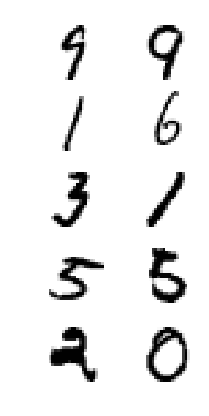

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6910328
0 테스트 정확도: 0.542
1 훈련 손실: 0.6035354
2 훈련 손실: 0.54946035
3 훈련 손실: 0.47047248
4 훈련 손실: 0.4060757
5 훈련 손실: 0.38308156
5 테스트 정확도: 0.824
6 훈련 손실: 0.39047274
7 훈련 손실: 0.3390794
8 훈련 손실: 0.32106707
9 훈련 손실: 0.31792688
10 훈련 손실: 0.2449429
10 테스트 정확도: 0.8881
11 훈련 손실: 0.2929237
12 훈련 손실: 0.23225442
13 훈련 손실: 0.23180933
14 훈련 손실: 0.1987794
15 훈련 손실: 0.20065445
15 테스트 정확도: 0.9203
16 훈련 손실: 0.19700491
17 훈련 손실: 0.18893161
18 훈련 손실: 0.19965447
19 훈련 손실: 0.24071628
20 훈련 손실: 0.18882038
20 테스트 정확도: 0.9367
21 훈련 손실: 0.124192126
22 훈련 손실: 0.14013433
23 훈련 손실: 0.12078955
24 훈련 손실: 0.1572117
25 훈련 손실: 0.11507861
25 테스트 정확도: 0.948
26 훈련 손실: 0.13891122
27 훈련 손실: 0.1526085
28 훈련 손실: 0.12343664
29 훈련 손실: 0.11543139
30 훈련 손실: 0.114027984
30 테스트 정확도: 0.9507
31 훈련 손실: 0.11897168
32 훈련 손실: 0.09546753
33 훈련 손실: 0.082994424
34 훈련 손실: 0.13659343
35 훈련 손실: 0.068016864
35 테스트 정확도: 0.9592
36 훈련 손실: 0.11016745
37 훈련 손실: 0.049501855
38 훈련 손실: 0.081338964
39 훈련 손실: 0.094419934
40 훈련 손실: 0.08737196
40 테

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9455
10 테스트 정확도: 0.9641
20 테스트 정확도: 0.9657
30 테스트 정확도: 0.9655
40 테스트 정확도: 0.9656
50 테스트 정확도: 0.9658
60 테스트 정확도: 0.9658
70 테스트 정확도: 0.9657
80 테스트 정확도: 0.9657
90 테스트 정확도: 0.9657


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8694
10 테스트 정확도: 0.9276
20 테스트 정확도: 0.9319
30 테스트 정확도: 0.9431
40 테스트 정확도: 0.9439
50 테스트 정확도: 0.9438
60 테스트 정확도: 0.944
70 테스트 정확도: 0.9437
80 테스트 정확도: 0.9437
90 테스트 정확도: 0.9437
100 테스트 정확도: 0.9439
110 테스트 정확도: 0.9439
120 테스트 정확도: 0.9441
130 테스트 정확도: 0.9439
140 테스트 정확도: 0.944


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!